# Task 1: Generating descriptions for musicians


## Initialization
**Run this to start up the notebook.**

In [1]:
import ipywidgets as widgets
from IPython.display import display
import sys

#Get/set path to workspace
savepath_w = widgets.Combobox(
    value="./",
    placeholder='Define project path',
    options=['/content/drive/MyDrive/Connactz/','./'],
    description='Project path:',
    ensure_option=False
)
refresh = widgets.Button(
    description='Add to dir sys path'
)

def AddPath(x): 
    sys.path.append(savepath_w.value)
    print("Added %s to path" % savepath_w.value)

refresh.on_click(AddPath)

display(savepath_w,refresh)

Combobox(value='./', description='Project path:', options=('/content/drive/MyDrive/Connactz/', './'), placehol…

Button(description='Add to dir sys path', style=ButtonStyle())

In [ ]:
#RUN THIS FIRST

# Connect to google drive
#from google.colab import drive
#drive.mount('/content/drive')

# Install dependencies
#!pip -q install transformers
#!pip -q install sentencepiece
#!pip -q install openai tiktoken
#!pip -q install pymysql
#!pip -q install langchain

# Load dependencies
#import pymysql
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import torch
import os
import openai
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from transformers.optimization import Adafactor
import matplotlib.pyplot as plt
import tqdm
import random
import tiktoken

# from IPython.display import display, Markdown
# display(Markdown("# &uarr; Start up Notebook here &uarr;"))

# # For wrapping text in output
# from IPython.display import HTML, display
# def set_css():
#   display(HTML('''
#   <style>
#     pre {
#         white-space: pre-wrap;
#     }
#   </style>
#   '''))
# get_ipython().events.register('pre_run_cell', set_css)

#Load env variables from file
load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
openai.api_key = OPENAI_API_KEY

# Load in custom functions (requires Projectpath to be set correctly)
savepath = savepath_w.value
import prepare
import evaluation
import train

#Load GPT3.4 and 4 encodings
encoding = tiktoken.get_encoding("cl100k_base")

train.py: savepath is hardcoded to ./


## Refresh data

In [3]:
button = widgets.Button(description="Refresh Data")
output = widgets.Output()

def on_button_clicked(b):
  # Display the message within the output widget.
  with output:
    print("Button clicked.")
  task1_in = prepare.refreshTask1(savepath=savepath)

button.on_click(on_button_clicked)
display(button, output)

task1_in =  pd.read_csv(savepath + "Datasets/ConnactzTask1.csv", sep=",", index_col=False)
#task1_in

#task1_in = translate.translateCol2EN(task1_in, backup=True, filepath=savepath + "Datasets/ConnactzTask1.csv")
#task1_in_triples = clean.createTriplets(task1_in, backup=True, filepath=savepath + "Datasets/task1_in_triples.csv")

task1_quality = pd.read_excel(savepath + "Datasets/Synthetic1.xlsx", index_col=False)
task1_quality['f_description'] = task1_quality['f_description'].str.replace('_x000D_', '')
task1_quality = pd.merge(task1_quality, task1_in[['f_key','description_en','triples_input','region']], on='f_key', how='left')

Button(description='Refresh Data', style=ButtonStyle())

Output()

In [5]:
len(task1_in)

448

## Preparing data


In [6]:
#Create triples
#LEGACY:
task1_in_triples = prepare.createTriplets(task1_in, backup=False)
task1_in['triples_input'] = task1_in_triples['input_text']


#LEGACY:
#Separate Train Test and most importantly "no target"
#No target is currently removed when refreshing the data
#task1_in_noTarget = task1_in_triples[task1_in_triples.target_text_de.isnull()]
#print("no target:" + str(len(task1_in_noTarget)))
#task1_in_ready = task1_in_triples[~task1_in_triples.target_text_de.isnull()]
#print("with target:" + str(len(task1_in_ready)))

task1_in = task1_in.drop_duplicates(subset='f_key', keep='first', ignore_index=True)
# task1_in_train = task1_in.sample(frac=0.8,random_state=369)
# task1_in_test = task1_in.drop(task1_in_train.index)
# task1_in_train = task1_in_train.reset_index(drop=True)
# task1_in_test = task1_in_test.reset_index(drop=True)
# print("train:"+str(len(task1_in_train)))
# print("test:"+str(len(task1_in_test)))



In [7]:
# The bands are hardocded to always keep the same dataset

# Dataset for parameter variation/tuning
para_keys = ["djdenki", "djsoundbar", "entprimalivepoploungedan", "livehouse", "djpartybombe2", "bandwarning", "troublemakersriot", "n8vision", "intakt", "martyhisrockincomets"]
task1_para = task1_in[task1_in['f_key'].isin(para_keys)]

# Dataset for diversity experiments
div_keys = ['bandwarning', 'intakt', 'partyband-nonplusultra', 'bayernlive-band', 'troublemakersriot', 'n8vision', 'connectionfive', 'luckies', 'martyhisrockincomets', 'baxtage',
            'atlascube', 'kubusm', 'theroses', 'huhnerbachmusi', 'theroaringzucchinis', 'thevioletband', 'happybavarians', 'gotthebeat', 'linofriends', 'topsound2', 'tromposaund',
            'loopsliveband', 'takeiteasy', 'pianissimo-dieeventband', 'koana', 'krohnband2', 'rotzfrechpartyband', 'de5blousadn6', 'daisyultra', 'bigbeat', 'bavariasound',
            'woodsidejumpers', 'alleinunterhalterpetergent', 'airplay', 'stephanworbs', 'musikduowirsindwir', 'stingrays', 'quincy', 'support', 'partybandsappralot', 'mix2max',
            'zwoastoa', 'theletters', 'undercoverlover', 'woistrosi', 'brasstacks', 'dannysangels', 'theswingingjangos', 'dinner-undbarmusik', 'happyhour']
task1_div = task1_in[task1_in['f_key'].isin(div_keys)]
#XXX: join task1_in and ResultsDF to get the highest scoring bavarian bands. Then compare with manual scores

task1_in_train = task1_quality[~task1_quality['f_key'].isin(div_keys)].reset_index(drop=True)

#Code to recreate diversity dataset
# #Get bavarian bands with scores
# bay_keys = task1_in.loc[np.where(task1_in.region == "Bayern")[0], "f_key"]
# task1_quality_div = task1_quality[task1_quality.f_key.isin(bay_keys)]
# task1_quality_div = task1_quality_div.loc[~task1_quality_div.Quality.isna()]
# task1_quality_div = task1_quality_div.loc[~task1_quality_div.f_casts.str.contains("dj")]
# #Select the 50 best rated bands
# task1_quality_div = task1_quality_div.sort_values(by=['Quality'], ascending=False).head(50)
# task1_quality_div.f_key.tolist()


# Code to get band descriptions for few-shot experiments
task1_fewshot = task1_quality[(task1_quality.Quality > 6) | task1_quality.Quality.isna()]
task1_fewshot = task1_fewshot[(task1_fewshot.Length > 400) & (task1_fewshot.Length < 1000)]
task1_fewshot = task1_in[task1_in.f_key.isin(task1_fewshot.f_key.tolist())]
task1_fewshot_en = task1_fewshot.description_en.tolist()



In [8]:
set(para_keys).intersection(set(div_keys))


{'bandwarning',
 'intakt',
 'martyhisrockincomets',
 'n8vision',
 'troublemakersriot'}

## Data Exploration

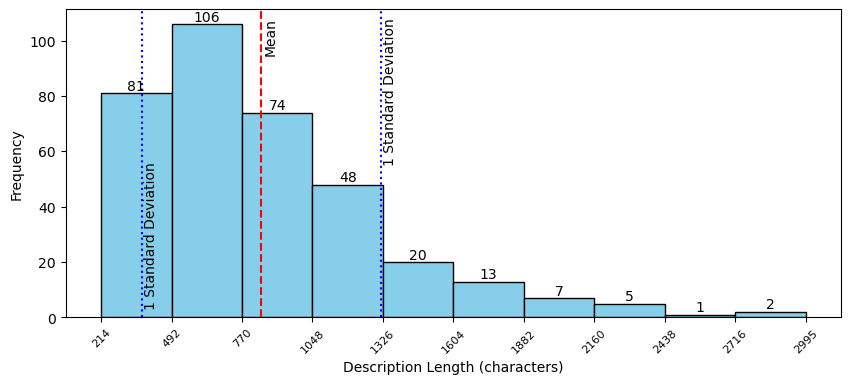

In [11]:
# Calculate the description lengths
string_lengths = task1_quality['f_description'].str.len().fillna(0)

# Create a histogram with automatic bin labels
n, bins, patches = plt.hist(string_lengths, bins=10, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Description Length (characters)')
plt.ylabel('Frequency')
#plt.title('Histogram of Description Lengths')

# Add frequency annotations to each bin
for i, freq in enumerate(n):
    plt.annotate(str(int(freq)), xy=(bins[i] + (bins[i+1] - bins[i]) / 2, freq), ha='center', va='bottom')

# Calculate and set automatic bin labels
bin_labels = [f'{int(bins[i])}' for i in range(len(bins) - 1)]

# Append the missing 11th label (adjust as needed)
bin_labels.append(f'{int(bins[-1])}')

# Set the ticks at the edges of each bin
plt.xticks(bins, bin_labels, rotation=45, fontsize=8)

# Adjust the figure size to prevent label overlap
plt.gcf().set_size_inches(10, 4)

# Calculate the mean and standard deviation
mean_length = np.mean(string_lengths)
std_dev = np.std(string_lengths)

# Add vertical lines for the mean and standard deviation
plt.axvline(mean_length, color='r', linestyle='--')
plt.axvline(mean_length - std_dev, color='b', linestyle=':')
plt.axvline(mean_length + std_dev, color='b', linestyle=':')

# Add vertical text next to the lines
plt.text(mean_length+10, plt.gca().get_ylim()[1]-3, 'Mean', rotation=90, verticalalignment='top')
plt.text(mean_length+10 - std_dev, plt.gca().get_ylim()[0]+3, '1 Standard Deviation', rotation=90, verticalalignment='bottom')
plt.text(mean_length+10 + std_dev, plt.gca().get_ylim()[1]-3, '1 Standard Deviation', rotation=90, verticalalignment='top')


# Show the histogram
plt.show()

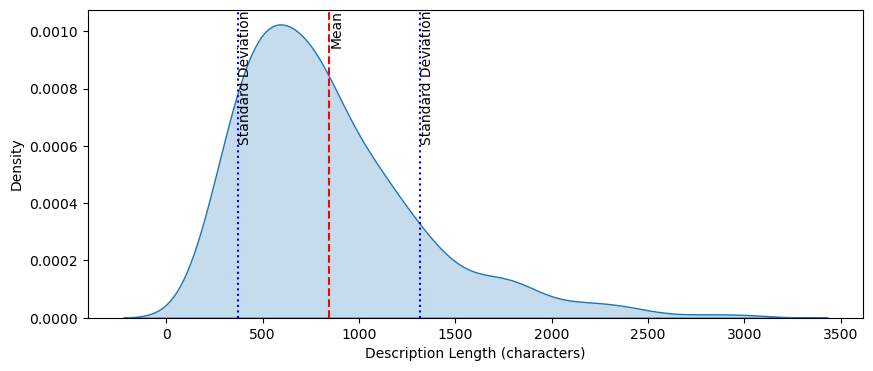

In [12]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Calculate the description lengths
string_lengths = task1_quality['f_description'].str.len().fillna(0)

# Calculate the mean and standard deviation
mean_length = np.mean(string_lengths)
std_dev = np.std(string_lengths)

# Create a KDE plot
sns.kdeplot(string_lengths, fill=True)

# Add vertical lines for the mean and standard deviation
plt.axvline(mean_length, color='r', linestyle='--')
plt.axvline(mean_length - std_dev, color='b', linestyle=':')
plt.axvline(mean_length + std_dev, color='b', linestyle=':')

# Add vertical text next to the lines
plt.text(mean_length, plt.gca().get_ylim()[1], 'Mean', rotation=90, verticalalignment='top')
plt.text(mean_length - std_dev, plt.gca().get_ylim()[1], 'Standard Deviation', rotation=90, verticalalignment='top')
plt.text(mean_length + std_dev, plt.gca().get_ylim()[1], 'Standard Deviation', rotation=90, verticalalignment='top')

# The rest of your code...

# Add labels and title
plt.xlabel('Description Length (characters)')
plt.ylabel('Density')

# Adjust the figure size to prevent label overlap
plt.gcf().set_size_inches(10, 4)

# Show the plot
plt.show()

In [13]:
task1_quality.columns

Index(['f_name', 'f_key', 'f_description', 'f_distance', 'f_locality',
       'f_locality_lat', 'f_locality_lon', 'f_casts', 'f_genres',
       'f_eventtypes', 'f_musicians', 'Quality', 'Uniqueness', 'Length',
       'IsDJ', 'Selection', 'description_en', 'triples_input', 'region'],
      dtype='object')

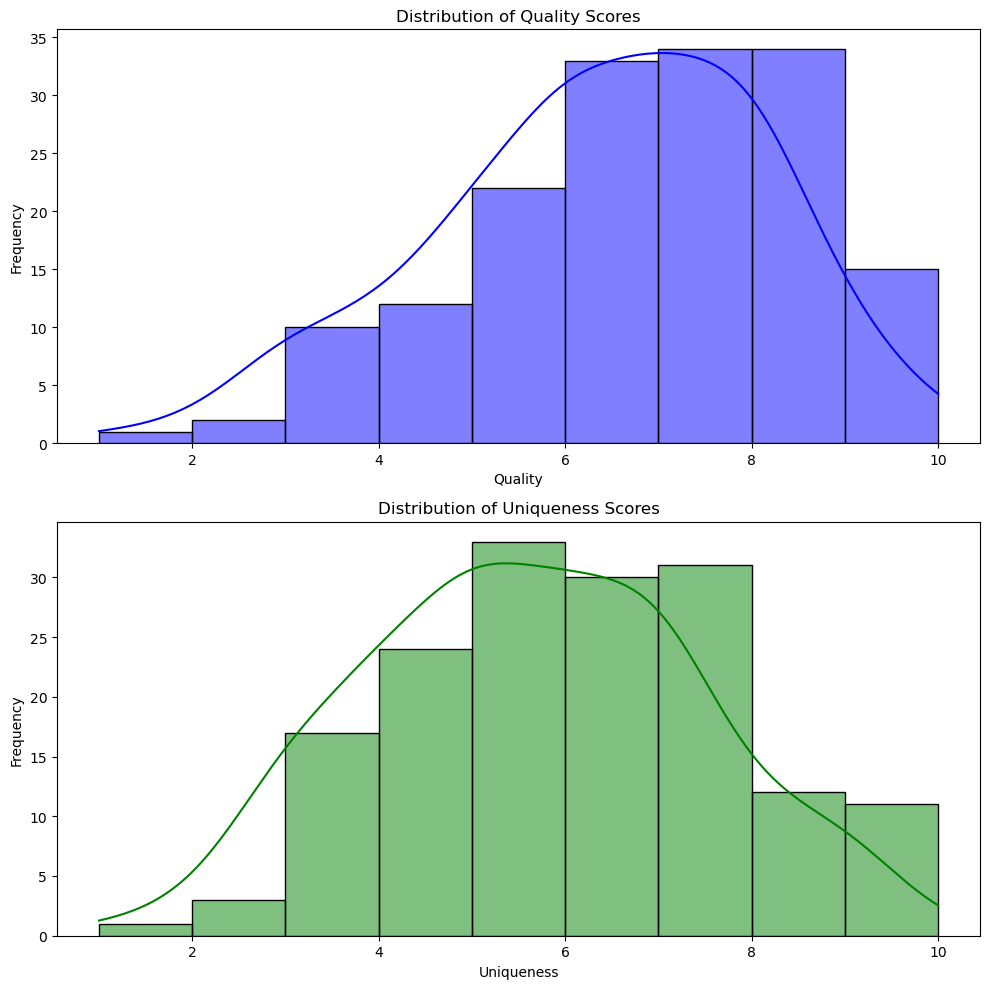

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Plot the distribution of quality scores
sns.histplot(task1_quality['Quality'], ax=ax[0], kde=True, color='blue')
ax[0].set_title('Distribution of Quality Scores')
ax[0].set_xlabel('Quality')
ax[0].set_ylabel('Frequency')

# Plot the distribution of uniqueness scores
sns.histplot(task1_quality['Uniqueness'], ax=ax[1], kde=True, color='green')
ax[1].set_title('Distribution of Uniqueness Scores')
ax[1].set_xlabel('Uniqueness')
ax[1].set_ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Description length')

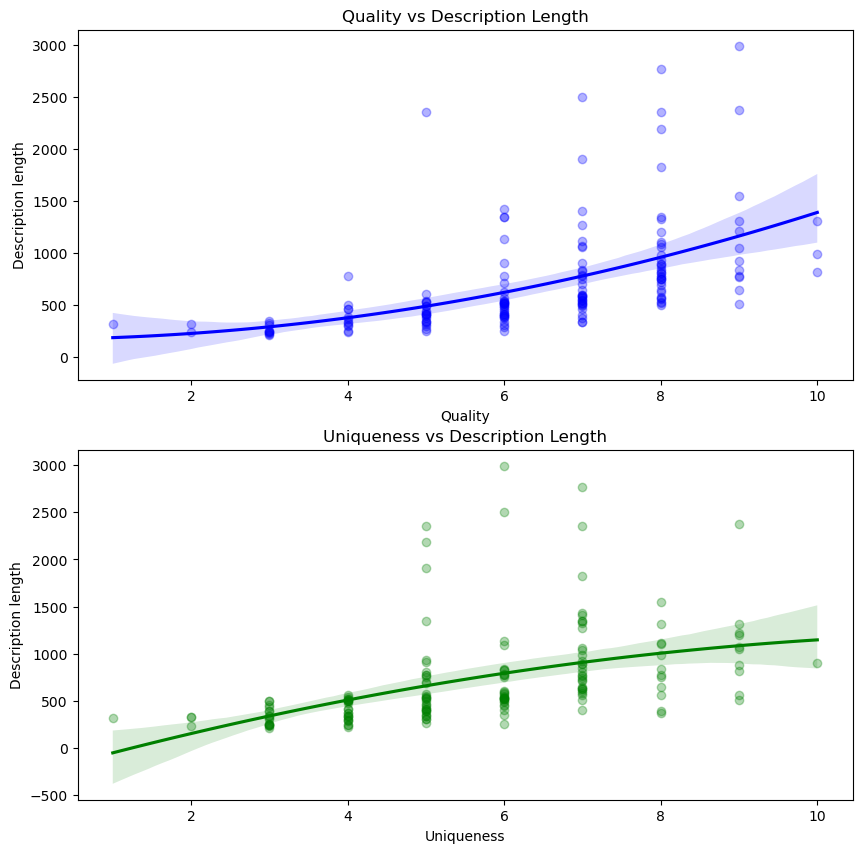

In [15]:
import matplotlib.pyplot as plt

# Calculate the description lengths
task1_quality['description_length'] = task1_quality['f_description'].str.len().fillna(0)

import seaborn as sns

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
# Create a scatter plot with a regression line for description_length and Quality
sns.regplot(y='description_length', x='Quality', data=task1_quality, ax=ax[0], color='blue', order=2, scatter_kws={'alpha':0.3})
ax[0].set_title('Quality vs Description Length')
ax[0].set_xlabel('Quality')
ax[0].set_ylabel('Description length')

# Create a scatter plot with a regression line for description_length and Uniqueness
sns.regplot(y='description_length', x='Uniqueness', data=task1_quality, ax=ax[1], color='green', order=2, scatter_kws={'alpha':0.3})
ax[1].set_title('Uniqueness vs Description Length')
ax[1].set_xlabel('Uniqueness')
ax[1].set_ylabel('Description length')

# Create a scatter plot with a regression line for description_length and Uniqueness
# sns.lmplot(y='description_length', x='Uniqueness', data=task1_quality, order=2, scatter_kws={'alpha':0.3})
# ax[2].set_title('Uniqueness vs description_length')
# ax[2].set_xlabel('Uniqueness')
# ax[2].set_ylabel('description_length')


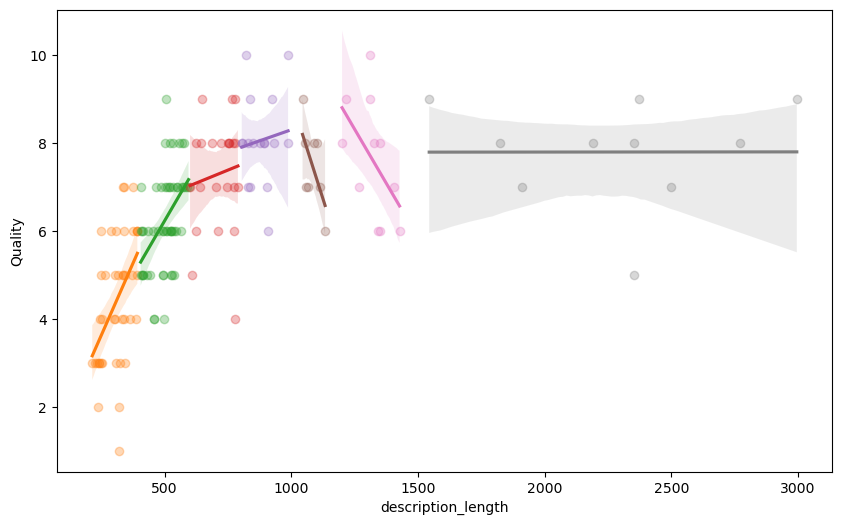

In [16]:
import numpy as np

# Define your breakpoints
breakpoints = [0, 200, 400,600,800,1000,1200,1500,4000]

# Create a list to store your segments
segments = []

# Split the data into segments at the breakpoints
for i in range(len(breakpoints) - 1):
    segments.append(task1_quality[(task1_quality['description_length'] >= breakpoints[i]) & (task1_quality['description_length'] < breakpoints[i+1])])

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot a regplot for each segment
for segment in segments:
    sns.regplot(x='description_length', y='Quality', data=segment, scatter_kws={'alpha':0.3})

plt.show()

In [17]:
# Calculate the correlation between description_length and Quality
quality_corr = task1_quality['description_length'].corr(task1_quality['Quality'])
print(f'Correlation between Description Length and Quality: {quality_corr}')

# Calculate the correlation between description_length and Uniqueness
uniqueness_corr = task1_quality['description_length'].corr(task1_quality['Uniqueness'])
print(f'Correlation between Description Length and Uniqueness: {uniqueness_corr}')

# Calculate the correlation between Quality and Uniqueness
uniqueness_corr = task1_quality['Quality'].corr(task1_quality['Uniqueness'])
print(f'Correlation between Quality and Uniqueness: {uniqueness_corr}')

Correlation between Description Length and Quality: 0.5139650867428455
Correlation between Description Length and Uniqueness: 0.460593101087879
Correlation between Quality and Uniqueness: 0.7296017194022834


In [18]:
# Find the index of the row with the shortest Length
index_of_shortest = task1_quality['Length'].idxmin()

# Get the f_description for this row
description_of_shortest = task1_quality.loc[index_of_shortest, 'f_description']

print(description_of_shortest)

Die Tanz- und Hochzeitsband für die Region Neckar-Alb, Bodensee, Stuttgart und Ostalbkreis.

Wir verwöhnen Sie mit einem breiten internationalen Repertoire, live gesungen und gespielt von erfahrenen Profimusikern. 


In [19]:
string_lengths.describe()

count     357.000000
mean      845.960784
std       472.835831
min       214.000000
25%       501.000000
50%       741.000000
75%      1068.000000
max      2995.000000
Name: f_description, dtype: float64

In [20]:
import folium

task1_in_loc = task1_in[~task1_in[['f_locality_lat', 'f_locality_lon']].isna().any(axis=1)]

# Create a map centered on Germany
m = folium.Map(location=[50.7657, 10.4515], zoom_start=6)

# Add a marker for each entry in the DataFrame
for index, row in task1_in_loc.iterrows():
    folium.Marker(location=[row['f_locality_lat'], row['f_locality_lon']], popup=row['f_key'], radius=1).add_to(m)

# Display the map
m

In [21]:
len(task1_in_loc)

443

In [22]:
import folium
from folium.plugins import MarkerCluster
import json

# Group the data by region
grouped = task1_in_loc.groupby('region')

# Create a map centered on Germany
m = folium.Map(location=[50.7657, 10.4515], zoom_start=6, 
               tiles='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}', 
               attr='Esri')

# Create a MarkerCluster for each region
for name, group in grouped:
    marker_cluster = MarkerCluster().add_to(m)

    # Add a marker for each entry in the group
    for index, row in group.iterrows():
        folium.Marker(location=[row['f_locality_lat'], row['f_locality_lon']], popup=row['f_key'], radius=1).add_to(marker_cluster)

# Load GeoJSON data
with open('MapData/DE.geo.json') as f:
    regions = json.load(f)

# Add GeoJSON layer to the map

folium.GeoJson(regions, name='regions').add_to(m)


# Display the map
m

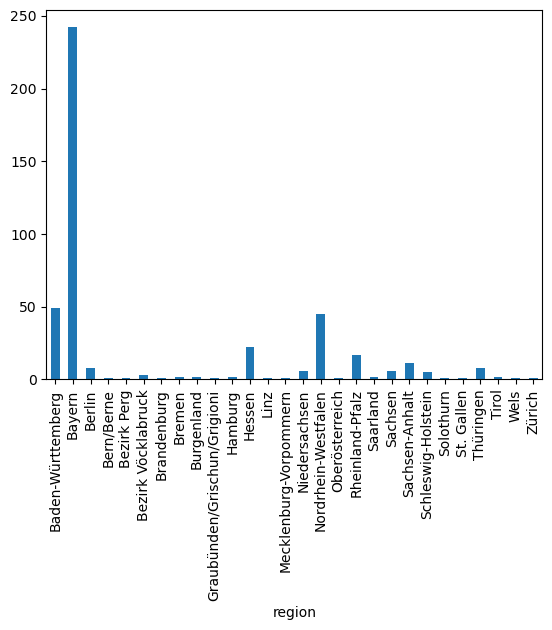

242 entries are from Bayern
206 entries are not from Bayern


In [23]:
# Group the addresses by country
grouped = task1_in['region'].groupby(task1_in['region']).count()

# Create a bar chart of the grouped data
grouped.plot(kind='bar')

# Display the chart
plt.show()

print(str((task1_in['region'] == 'Bayern').sum()) + " entries are from Bayern")
print(str((~(task1_in['region'] == 'Bayern')).sum()) + " entries are not from Bayern")

## Output dataframe

By default, load in the existing DF. Commented out, you can find the code to start anew.

In [24]:
ResultsDF = pd.read_pickle(savepath+"/Datasets/ResultsDF.pkl")
# ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

#For export only
#ResultsDF = pd.read_csv(savepath+"/Datasets/ResultsDF.csv", sep=",", index_col=False)
#ResultsDF.to_csv(savepath+"/Datasets/ResultsDF.csv", sep=",", index=False)

In [36]:
####### RUN THIS ONLY IF STARTING ANEW #######

# ResultsDF = pd.DataFrame( columns = ['f_key', 'Experiment', 'Model', 'Prompt', 'Answer', 'Parameters', 'Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'Geval_qua, 'TTR', 'OverallScore'])

# #Add original data to evaluation
# # Assuming task1_in is a pandas DataFrame
# EvalOriginal = task1_div[['f_key','description_en']].rename(columns={'description_en':'Answer'})
# EvalOriginal['Experiment'] = 'OriginalDiv_en'
# ResultsDF = pd.concat([ResultsDF, EvalOriginal], ignore_index=True)

# #Eval original data
# #bad_responses = evaluation.run_gpt4_eval(ResultsDF, savepath + '/Prompts/g_eval_eng.txt', 'Geval_eng')
# bad_responses = evaluation.eval(ResultsDF, savepath=savepath)


In [26]:
# ####### If you ever have the Parameters column as a string, use this to convert it back to a dictionary

# import ast

# # Convert string to dictionary in 'Parameters' column
# ResultsDF['Parameters'] = ResultsDF['Parameters'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [27]:
ResultsDF

f_key            Experiment             Model  \
0               partybandhilight              Original               NaN   
1                          fonix              Original               NaN   
2                     theletters              Original               NaN   
3                  die4lustigen3              Original               NaN   
4     rainerseidl-schlagersanger              Original               NaN   
...                          ...                   ...               ...   
1509                    n8vision  Base-Llama2-13b-chat  Llama-2-13b-chat   
1510        martyhisrockincomets  Base-Llama2-13b-chat  Llama-2-13b-chat   
1511           troublemakersriot  Base-Llama2-13b-chat  Llama-2-13b-chat   
1512                   livehouse  Base-Llama2-13b-chat  Llama-2-13b-chat   
1513               djpartybombe2  Base-Llama2-13b-chat  Llama-2-13b-chat   

                                                 Prompt  \
0                                                   NaN   
1                                                   NaN   
2                                                   NaN   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
1509  Create a captivating and comprehensive band de...   
1510  Create a captivating and comprehensive band de...   
1511  Create a captivating and comprehensive band de...   
1512  Create a captivating and comprehensive band de...   
1513  Create a captivating and comprehensive band de...   

                                                 Answer  \
0                              Jetzt auf deutsch bitte.   
1     Servus miteinander. Wir, die Band "Fönix" sind...   
2     Wir machen Ihr Fest zu einem unvergessenem Erl...   
3     Die4Lustigen3 sind ein Stimmunstrio für Feste ...   
4     Damit eine Party zum Erfolg wird, ist neben gu...   
...                                                 ...   
1509    Introducing N8Vision - the ultimate party st...   
1510    Sure! Here's a captivating and comprehensive...   
1511    Introducing Troublemaker's Riot - the ultima...   
1512    Introducing LIVE HOUSE - the ultimate party ...   
1513    Introducing DJ PARTYBOMBE - the ultimate par...   

                                             Parameters  Geval_eng  Geval_flu  \
0     [{'gendata': 'name = Partyband Hi!light,
homet...  -1.000000   0.000000   
1     [{'gendata': 'name = Fönix,
hometown = Frauena...   3.350000   2.900000   
2     [{'gendata': 'name = The Letters,
hometown = N...   3.631579   2.888889   
3     [{'gendata': 'name = Die 4 Lustigen 3,
hometow...   3.850000   2.944444   
4     [{'gendata': 'name = Rainer Seidl - Schlagersä...   4.050000   2.700000   
...                                                 ...        ...        ...   
1509  [{'genpara': {'Temperature': 0.9}, 'gendata': ...        NaN        NaN   
1510  [{'genpara': {'Temperature': 0.9}, 'gendata': ...        NaN        NaN   
1511  [{'genpara': {'Temperature': 0.9}, 'gendata': ...        NaN        NaN   
1512  [{'genpara': {'Temperature': 0.9}, 'gendata': ...        NaN        NaN   
1513  [{'genpara': {'Temperature': 0.9}, 'gendata': ...        NaN        NaN   

      Geval_nat  Geval_inf       TTR  OverallScore  Geval_qua  
0     -1.000000  -1.000000  1.000000     -0.195833      -1.00  
1      2.944444   2.315789  0.691275      0.799274       3.30  
2      2.900000   2.684211  0.534884      0.831750       3.85  
3      3.000000   2.368421  0.741379      0.835897       3.20  
4      2.944444   2.000000  0.790123      0.797870       3.60  
...         ...        ...       ...           ...        ...  
1509        NaN        NaN       NaN           NaN        NaN  
1510        NaN        NaN       NaN           NaN        NaN  
1511        NaN        NaN       NaN           NaN        NaN  
1512        NaN        NaN       NaN           NaN        NaN  
1513        NaN    

In [38]:
ResultsDF.Experiment.unique()

array(['Original', 'Original_Quality', 'Temp-GPT3.5-1106',
       'Base-GPT-3.5-1106', 'Base-GPT-4-1106', 'Temp-GPT4', 'Topp-GPT3.5',
       'Shuffle-GPT4', 'Shuffle-GPT3.5', 'Fewshot-GPT3.5', 'Fewshot-GPT4',
       'AltIns-GPT3.5', 'AltIns-GPT4', 'Original_para', 'Original_div',
       'Base-Para-GPT3.5', 'Base-Para-GPT4', 'T5-div', 'T5-div-2',
       'logitBias-GPT3.5', 'LogitBias-GPT4', 'Shuffle-Llama2-13b-chat',
       'AltIns-Llama2-13b-chat', 'adaptlogitBias-GPT3.5',
       'AdaptLogitBias-GPT4', 'OriginalDiv_en', 'FlanT5-div-2',
       'AltInsDiv-GPT3.5', 'AltInsDiv-GPT4', 'FewshotDiv-GPT3.5',
       'FewshotDiv-GPT4', 'ShuffleDiv-GPT3.5', 'ShuffleDiv-GPT4',
       'Base-Triplets-GPT3.5', 'Base-Llama2-13b-chat'], dtype=object)

In [29]:
# EvalOriginal = task1_quality[['f_key','f_description']].rename(columns={'f_description':'Answer'})
# EvalOriginal['Experiment'] = 'Original_Quality'
# ResultsDF = pd.concat([ResultsDF, EvalOriginal], ignore_index=True)

# bad_responses = evaluation.eval(ResultsDF, savepath)
# ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

In [30]:
# print(bad_responses.shape)
# print(bad_responses['f_key'].to_list())

In [31]:
#ResultsDF[(ResultsDF[['Geval_eng','Geval_flu','Geval_nat','Geval_inf','TTR']] < 0).any(axis=1)]

In [32]:
# results_para = ResultsDF.loc[(ResultsDF['Experiment'] == 'Original_Quality') & (ResultsDF['f_key'].isin(para_keys))]
# results_para['Experiment'] = 'Original_para'
# results_div = ResultsDF.loc[(ResultsDF['Experiment'] == 'Original_Quality') & (ResultsDF['f_key'].isin(div_keys))]
# results_div['Experiment'] = 'Original_div'

# ResultsDF = pd.concat([ResultsDF, results_para, results_div], ignore_index=True)

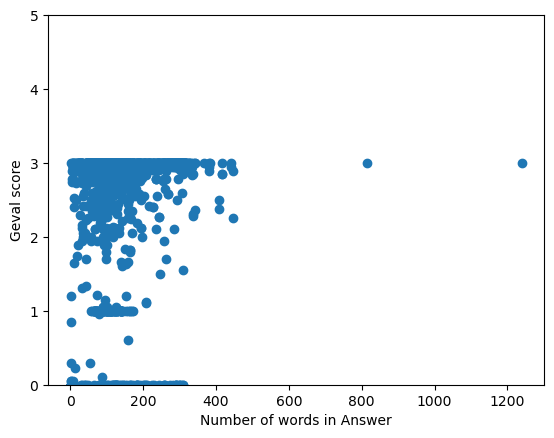

In [33]:
import matplotlib.pyplot as plt

# Assuming ResultsDF is a pandas DataFrame containing the data
x = ResultsDF['Answer'].apply(lambda x: len(x.split())) # Number of words in Answer column
y = ResultsDF['Geval_nat'] # Geval scores

plt.scatter(x, y)
plt.xlabel('Number of words in Answer')
plt.ylabel('Geval score')
plt.ylim(0, 5)
plt.show()

In [34]:
matrix, mean = evaluation.jaccard_sim_score(ResultsDF, 'Original_Quality', n={2,3,4})
print(mean)
print(matrix)


0.0015131887194369366
          448       449      450       451       452       453  454       455  \
448       NaN       0.0      0.0  0.380531       0.0       0.0  0.0       0.0   
449       0.0       NaN      0.0       0.0       0.0       0.0  0.0       0.0   
450       0.0       0.0      NaN   0.00578       0.0       0.0  0.0       0.0   
451  0.380531       0.0  0.00578       NaN       0.0       0.0  0.0       0.0   
452       0.0       0.0      0.0       0.0       NaN       0.0  0.0  0.005263   
..        ...       ...      ...       ...       ...       ...  ...       ...   
809  0.001825       0.0      0.0  0.001786       0.0       0.0  0.0  0.001786   
810   0.00175  0.000866      0.0    0.0026       0.0  0.001732  0.0  0.000865   
811  0.002402  0.000792      0.0  0.002379  0.000778       0.0  0.0  0.000792   
812  0.000758       0.0      0.0  0.000751  0.000738       0.0  0.0       0.0   
813       0.0       0.0      0.0       0.0  0.000708  0.002163  0.0   0.00072   

     

In [35]:
SimText = evaluation.inspectSimMatrix(matrix, ResultsDF, top=15)
#evaluation.highlightNgram()
SimText

f_key1  \
0                 markusmuller   
1              dj-niederbayern   
2                     lookback   
3        hochzeitsbandprestige   
4   rainerseidl-schlagersanger   
5         thepierrelenhardband   
6               taintedthunder   
7                         naja   
8                thetaylorboys   
9                  soundcircle   
10    partybandhans-peterweisz   
11                    hotmusic   
12                   rockwartz   
13             thesoundsection   
14                   pichijogo   

                                              Answer1  \
0   Ob Hochzeiten, Firmenfeiern, Vereinsfeste, Geb...   
1   "DJ-Niederbayern" Ihr DJ für den Raum Bayern u...   
2   Die Oldieformation Look Back präsentiert bei L...   
3   Die Tanz- und Hochzeitsband für die Region Nec...   
4   Damit eine Party zum Erfolg wird, ist neben gu...   
5   Sie haben doch auch diese besonderen Erinnerun...   
6   Wir sind eine Rock Cover Band aus dem Bayrisch...   
7   Servus! Du suchst noch eine Band für deine Ver...   
8   The Taylor Boys sind ein vielseitiges Gitarren...   
9   Ohne zusätzlichen Schnickschnack serviert Soun...   
10  Wir sind eine flexible professionelle Party-& ...   
11  IHRE Band für: Privatfete, Gala, Vereinsfest, ...   
12  Wir, die Band "Rockwärtz" bringen Eure Bühne z...   
13  Mit begeisternden Bühnenperformances ist The S...   
14  Pichi und Jogo, zwei waschechte Live-Musiker m...   

                      f_key2  \
0              markusmuller2   
1           dj-niederbayern2   
2                  lookback2   
3               bandprestige   
4                partyfieber   
5   thepierrelenhardbandreme   
6              thetaylorboys   
7                 Uberfallig   
8             happybavarians   
9             atticunleashed   
10       eventbandnightflash   
11                  livetime   
12                     trixx   
13                  topsound   
14    tanz-undpartybandvocal   

                                              Answer2     Score  
0   Ob Hochzeiten, Firmenfeiern, Vereinsfeste, Geb...  1.000000  
1   Party-DJ für den Raum Bayern und Österreich.\n...  0.843137  
2   Die Formation Look Back präsentiert bei Live-A...  0.733438  
3   Die Tanz- und Hochzeitsband Prestige sorgt für...  0.380531  
4   Mit der Band âPartyfieberâ wird Ihre Party...  0.113924  
5   Remember the good old days.\n\nSie haben sie d...  0.040435  
6   The Taylor Boys sind ein vielseitiges Gitarren...  0.034602  
7   Wir sind "Überfällig", eine junge fünfköpfige ...  0.034156  
8   Die "Happy Bavarians" sind eine durch Film, Fu...  0.033708  
9   Sie suchen eine Band, die ihre Feier mit Livem...  0.032110  
10  Nightflash ist eine professionelle Tanz-, Part...  0.031579  
11  Live Time - hier spielt die MUSIK!!! Eine mitr...  0.030233  
12  Professionelle Coverband, spielt von Party übe...  0.029221  
13  "Topsound" - die Hochzeits- und Party Profis a...  0.027149  
14  Liveband, bei der jeder Musiker seinen Gesangs...  0.026316

In [36]:
row = 10
#TODO: make this a proper function with button
print("Score: " + str(SimText.loc[row,'Score']))
evaluation.highlightNgram(SimText.loc[row,'Answer1'], SimText.loc[row,'Answer2'], max_n=4)

Score: 0.031578947368421054
n = 2
Wir sind eine flexible professionelle Party-& Galaband mit 1-6 Musikern. Wir verfügen über ein breitgefächertes Repertoire für jeden Anlass und sind seit über 30 Jahren in ganz Deutschland für Sie unterwegs. Mit unserer umfangreichen Erfahrung, Top-Equipment, einer modernen Licht-Show und vor allem dem nötigen Fingerspitzengefühl für unser jeweiliges Publikum garantieren wir immer eine super Stimmung für Ihre Feier. 

Nightflash ist eine professionelle Tanz-, Party-, Cover- und Live-Band mit bemerkenswerter Programmvielfalt und modernem Sound. Eine Band, die es mit Charme, Authentizität und mitreißender Freude an der Musik versteht, ihr Publikum perfekt zu unterhalten. Rock&#39;n&#39;Roll und Jazz, Musik für die kirchliche Trauung und Tanzmusik für die Hochzeitsfeier, Dinner- und Loungemusik, diskreter Hintergrundsound oder ausgelassene Partystimmung wir verfügen über ein sehr breites Repertoire an Musikstücken für jeden Anlass. Mit flexibler Besetzung

## T5

### T5 small
#### Train

Change training parameters in train.py.\
Model is saved as modelv1.

T5-div is a diversity test on fine tuned T5-small with the original text 'Generate a band description from the following information:'
T5-div2 only uses 'Data:'


In [37]:
ResultsDF.Prompt[ResultsDF.Experiment == 'T5-div'].iloc[0]

'Generate a band description from the following information: band | name | The_Letters && The_Letters | locality | Nittendorf && The_Letters | distance | 110.0 && The_Letters | cast | band_duet && The_Letters | genre | dancemusic_lightmusic_party_pop_rock && The_Letters | eventtype | birthday_church_club_clubfestival_corporateevent_gala_summerparty_wedding_weddingparty'

In [38]:
RunT5 = widgets.Checkbox(
    value=False,
    description='Run T5',
    disabled=False,
    indent=False
)
FinetuneT5 = widgets.Checkbox(
    value=False,
    description='Finetune T5',
    disabled=False,
    indent=False
)

display(RunT5, FinetuneT5)

Checkbox(value=False, description='Run T5', indent=False)

Checkbox(value=False, description='Finetune T5', indent=False)

In [39]:
#Apparently cuda runs out of memory on my laptop and I don't have time to see why right now...
#This is obviously not a viable solution for the real work ahead of me.
# For future reference: https://huggingface.co/docs/transformers/main/en/perf_train_gpu_one
if RunT5.value:
  tokenizerT5small = T5Tokenizer.from_pretrained("t5-small")
  dev = torch.device("cuda")
  if FinetuneT5.value:

    #model = T5Model.from_pretrained("t5-small") #choose one
    modelT5small = T5ForConditionalGeneration.from_pretrained("t5-small", return_dict=True)
    modelT5small.to(dev)
    loss_per_10_steps = train.finetuneT5 (dev, task1_in_train, modelT5small, tokenizerT5small, num_of_epochs=10, batch_size=5)

    
    modelT5small.save_pretrained(savepath + "Models/modelT5small", from_pt=True)
    #model = T5ForConditionalGeneration.from_pretrained("modelv1")
  else:
    modelT5small = T5ForConditionalGeneration.from_pretrained(savepath + "Models/modelT5small")

#### Query

In [40]:
if RunT5.value:
  row=0 # @param {type:"integer"}

  #T5-small
  modelT5small.to(dev)
  modelT5small.eval()
  input_ids = tokenizerT5small.encode("Data: "+ task1_div['triples_input'].iloc[row], return_tensors="pt")
  input_ids=input_ids.to(dev)
  outputT5small = modelT5small.generate(input_ids, max_length=200)
  print(tokenizerT5small.decode(outputT5small[0], skip_special_tokens=True))
  print("\nExpected german:\n\n" + task1_div['f_description'].iloc[row])
  print("\nExpected english:\n\n" + task1_div['description_en'].iloc[row])

In [41]:
# T5 div eval

def divTest_Model(task1_div, experiment, model, tokenizer, modelName, evalModel = 'gpt-4-1106-preview', ):
  """Test a base query on a given dataset and model.
  Returns a new ResultsDF"""
  
  def promptGen(row):
    return "Data: " + row['triples_input']

  #create a new result DF
  data =  [(task1_div.iloc[r]['f_key'], experiment, modelName, [{'genpara':{'Temperature': 1.0}}], promptGen(task1_div.iloc[r]))  \
         for r in range(len(task1_div))]
  tmp_ResultsDF = pd.DataFrame(data, columns=['f_key', 'Experiment', 'Model', 'Parameters', 'Prompt'])
  tmp_ResultsDF = tmp_ResultsDF.reindex(columns=['f_key', 'Experiment', 'Model', 'Prompt', 'Answer', 'Parameters', 'Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'TTR', 'OverallScore', 'Geval_qua'])
  evaluation.addGendata2ResultsDF(tmp_ResultsDF, task1_div)

  model.to(dev)
  model.eval()

  #run queries
  for index, row in tqdm.tqdm(tmp_ResultsDF.iterrows()):
    input_ids = tokenizer.encode(row['Prompt'], return_tensors="pt")
    input_ids=input_ids.to(dev)
    outputModel = model.generate(input_ids, max_length=200)

    tmp_ResultsDF.loc[index, 'Answer'] = tokenizer.decode(outputModel[0], skip_special_tokens=True)
    #tmp_ResultsDF.loc[index, 'Prompt'] = row.Prompt

  #run eval
  try:
    errors = evaluation.eval(tmp_ResultsDF, savepath=savepath, model=evalModel)
  except:
    print("Evaluation failed")
    return tmp_ResultsDF, None
  return tmp_ResultsDF, errors
  #ResultsDF = pd.concat([ResultsDF, tmp_ResultsDF], ignore_index=True)
  #return ResultsDF

In [42]:
# ######### Uncomment if you wish to rerun the base test
# ResultsDF_tmp, errors = divTest_Model(task1_div, experiment = 'T5-div-2', model = modelT5small, tokenizer= tokenizerT5small, modelName='T5-small')
# ResultsDF = pd.concat([ResultsDF, ResultsDF_tmp], ignore_index=True)
# print(errors)
# ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

#### Plot loss
Only runs when the model is finetuned again

In [43]:
if FinetuneT5.value:
  steps = [i*100 for i in range(len(loss_per_10_steps))]

  plt.plot(steps, loss_per_10_steps)
  plt.title('Loss')
  plt.xlabel('Steps')
  plt.ylabel('Loss')
  plt.show()

In [44]:
matrix, mean = evaluation.jaccard_sim_score(ResultsDF, 'T5-div', n={2,3,4})
print(mean)
print(matrix)


0.024600934889496683
          1404      1405      1406      1407      1408      1409      1410  \
1404       NaN   0.02277  0.008065  0.020134  0.045064  0.083582  0.045614   
1405   0.02277       NaN  0.002688  0.043243  0.051724  0.010395       0.0   
1406  0.008065  0.002688       NaN   0.00346  0.009434       0.0       0.0   
1407  0.020134  0.043243   0.00346       NaN  0.079918  0.015113       0.0   
1408  0.045064  0.051724  0.009434  0.079918       NaN  0.030879       0.0   
1409  0.083582  0.010395       0.0  0.015113  0.030879       NaN  0.084071   
1410  0.045614       0.0       0.0       0.0       0.0  0.084071       NaN   
1411       0.0  0.010776  0.005587  0.010471       0.0  0.003425       0.0   
1412    0.0282  0.011864  0.023256  0.021869  0.050096  0.122667  0.034884   
1413  0.086681  0.011111       0.0  0.051233  0.099624  0.029018  0.010204   
1414  0.025424  0.016736       0.0  0.015113  0.006961    0.0299  0.012397   
1415  0.093373  0.025316  0.005102  0.08333

In [45]:
SimText = evaluation.inspectSimMatrix(matrix, ResultsDF, top=15)
#evaluation.highlightNgram()
SimText

f_key1                                            Answer1  \
0       connectionfive  We are a five-piece cover band from Munich and...   
1       connectionfive  We are a five-piece cover band from Munich and...   
2              baxtage  BaXtage - the party and party band from Dingol...   
3       connectionfive  We are a five-piece cover band from Munich and...   
4           takeiteasy  The right thing for every party! Then you are ...   
5       connectionfive  We are a five-piece cover band from Munich and...   
6           takeiteasy  The right thing for every party! Then you are ...   
7              baxtage  BaXtage - the party and party band from Dingol...   
8              baxtage  BaXtage - the party and party band from Dingol...   
9   dinner-undbarmusik  You have them! We are a professional entertain...   
10       thevioletband  The River Band is a versatile band that combin...   
11      happybavarians  We are a duo (duo with guitar, cajon, cajon, c...   
12          takeiteasy  The right thing for every party! Then you are ...   
13      connectionfive  We are a five-piece cover band from Munich and...   
14              intakt  We are a versatile cover band from Biberbach a...   

                f_key2                                            Answer2  \
0              baxtage  BaXtage - the party and party band from Dingol...   
1              bigbeat  BigBeat is a cover band from the Hengersberg a...   
2       happybavarians  We are a duo (duo with guitar, cajon, cajon, c...   
3       happybavarians  We are a duo (duo with guitar, cajon, cajon, c...   
4       connectionfive  We are a five-piece cover band from Munich and...   
5   dinner-undbarmusik  You have them! We are a professional entertain...   
6              baxtage  BaXtage - the party and party band from Dingol...   
7              bigbeat  BigBeat is a cover band from the Hengersberg a...   
8   dinner-undbarmusik  You have them! We are a professional entertain...   
9              bigbeat  BigBeat is a cover band from the Hengersberg a...   
10   troublemakersriot  The "Turbo Troublemaker's Riot" is a cover ban...   
11  dinner-undbarmusik  You have them! We are a professional entertain...   
12             bigbeat  BigBeat is a cover band from the Hengersberg a...   
13               koana  We are a young, dynamic and versatile band fro...   
14  dinner-undbarmusik  You have them! We are a professional entertain...   

       Score  
0   0.382812  
1   0.279476  
2   0.276316  
3   0.274390  
4   0.255000  
5   0.237374  
6   0.235602  
7   0.230088  
8   0.223404  
9   0.222615  
10  0.215613  
11  0.207373  
12  0.205479  
13  0.194656  
14  0.189112

In [46]:
row = 0
#TODO: make this a proper function with button
print("Score: " + str(SimText.loc[row,'Score']))
evaluation.highlightNgram(SimText.loc[row,'Answer1'], SimText.loc[row,'Answer2'], max_n=4)

Score: 0.3828125
n = 2
We are a five-piece cover band from Munich and play from the Munich area. We offer you a wide repertoire, sung live and played by experienced professional musicians. We offer you a wide range of repertoire, sung live and played by experienced professional musicians. 

BaXtage the party and party band from Dingolfing for your event. We offer you a wide range of repertoire, sung live and played by experienced professional musicians. We offer you a wide range of repertoire, sung live and played by experienced professional musicians. 


n = 3
We are a five-piece cover band from Munich and play from the Munich area. We offer you a wide repertoire, sung live and played by experienced professional musicians. We offer you a wide range of repertoire, sung live and played by experienced professional musicians. 

BaXtage the party and party band from Dingolfing for your event. We offer you a wide range of repertoire, sung live and played by experienced professional musician

### FlanT5

#### Train
Change training parameters in train.py.\
Model is saved as modelv1.

In [47]:
RunFlanT5 = widgets.Checkbox(
    value=False,
    description='Run FlanT5',
    disabled=False,
    indent=False
)
FinetuneFlanT5 = widgets.Checkbox(
    value=False,
    description='Finetune FlanT5',
    disabled=False,
    indent=False
)

display(RunFlanT5, FinetuneFlanT5)

Checkbox(value=False, description='Run FlanT5', indent=False)

Checkbox(value=False, description='Finetune FlanT5', indent=False)

In [48]:
#Apparently cuda runs out of memory on my laptop and I don't have time to see why right now...
#This is obviously not a viable solution for the real work ahead of me.
# For future reference: https://huggingface.co/docs/transformers/main/en/perf_train_gpu_one

if RunFlanT5.value:
  tokenizerFlanT5 = AutoTokenizer.from_pretrained("google/flan-t5-base")
  dev = torch.device("cuda")
  if FinetuneFlanT5.value:
    modelFlanT5 = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
    modelFlanT5.to(dev)
    loss_per_10_steps = train.finetuneT5 (dev, task1_in_train, modelFlanT5, tokenizerFlanT5, num_of_epochs=10, batch_size=1)

    
    modelFlanT5.save_pretrained(savepath + "Models/modelFlanT5", from_pt=True)
  else:
    modelFlanT5 = T5ForConditionalGeneration.from_pretrained(savepath + "Models/modelFlanT5")

#### Query

In [49]:
if RunFlanT5.value:
  row=1 # @param {type:"integer"}

  #T5-small
  modelFlanT5.to(dev)
  modelFlanT5.eval()
  input_ids2 = tokenizerFlanT5.encode("Generate a band description from the following information: "+ task1_div['triples_input'].iloc[row], return_tensors="pt")
  input_ids2=input_ids2.to(dev)
  outputFlanT5 = modelFlanT5.generate(input_ids2, max_length=200)
  print(tokenizerFlanT5.decode(outputFlanT5[0], skip_special_tokens=True))
  print("\nExpected german:\n\n" + task1_in_test['f_description'].iloc[row])
  print("\nExpected english:\n\n" + task1_in_test['description_en'].iloc[row])

In [177]:
ResultsDF_Flan = pd.read_pickle(savepath+"Datasets/ResultsDF_FlanT5.pkl")

#### Plot loss

Only runs when the model is finetuned again

In [50]:
if FinetuneFlanT5.value:
  steps = [i*100 for i in range(len(loss_per_10_steps))]

  plt.plot(steps, loss_per_10_steps)
  plt.title('Loss')
  plt.xlabel('Steps')
  plt.ylabel('Loss')
  plt.show()

# Openai API (GPT3.5)

In [51]:
# 

# #response = openai.ChatCompletion.create(model="gpt-3.5-turbo", messages=[{"role": "user", "content": "Say this is a test"}], temperature=0, max_tokens=7)
# #response

# def generate_prompt(row, task1_in):
#   return """Write a short description for this band in the first person. Here are fact provided as triplets: """ + task1_in.triples_input.iloc[row]

# # Remind: generic prompt
# # List of basic prompt blocs. [0:7] contain basic blocs, [7:12] contain alternative beginnings, [12:17] contain alternative endings, [17:22] contain alternative endings for the alternative beginnings.
# Generic_Prompt = open(savepath + "Prompts/task1_zeroshot.txt", "r").read().split(";")


# def generate_prompt_new(row, task1_in):
#   prompt = ''.join(Generic_Prompt[0:7]).replace('{{Name}}', task1_in.loc[row, 'f_name'])
#   prompt = prompt.replace('{{Location}}', task1_in.loc[row, 'f_locality'])
#   prompt = prompt.replace('{{Genres}}', task1_in.loc[row, 'f_genres'])
#   prompt = prompt.replace('{{Events}}', task1_in.loc[row, 'f_eventtypes'])
#   prompt = prompt.replace('{{Type}}', task1_in.loc[row, 'f_casts'])
#   prompt = prompt.replace('{{Radius}}', str(task1_in.loc[row, 'f_distance']))
#   return prompt

# def gen_prompt1(row):
#   """Like generate_prompt_new but pass it a single row of a dataframe"""
#   prompt = ''.join(Generic_Prompt[0:7]).replace('{{Name}}', row.f_name)
#   prompt = prompt.replace('{{Location}}', row.f_locality)
#   prompt = prompt.replace('{{Genres}}', row.f_genres)
#   prompt = prompt.replace('{{Events}}', row.f_eventtypes)
#   prompt = prompt.replace('{{Type}}', row.f_casts)
#   prompt = prompt.replace('{{Radius}}', str(row.f_distance))
#   return prompt

# def gen_prompt1_rand(row):
#   """Like generate_prompt_new but pass it a single row of a dataframe.
#      Randomizes the order of the facts in the prompt.
#   """
#   order = random.sample([1,2,3,4,5],5)
#   prompt = ''.join([Generic_Prompt[i] for i in [0] + test + [6]])
#   .replace('{{Name}}', row.f_name)



## Testing Grounds

In [52]:
#### Choose row
rowInt = widgets.BoundedIntText(
    value=0,
    min=0,
    max=task1_in.shape[0]-1,
    step=1,
    description='Row:',
    disabled=False
)

#### Query on selected row
#OLD
def SingleGPTQuery1(x):
  row = rowInt.value
  outputChatGPT = openai.ChatCompletion.create(model="gpt-3.5-turbo", messages=[{"role": "user", "content": train.generate_prompt(row, task1_in)}], temperature=1.3, max_tokens=500)
  print("\nChatGPt: " + outputChatGPT.choices[0].message.content) # type: ignore
  print("\nExpected german:\n\n" + str(task1_in.loc[row,'f_description']))
  print("\nExpected english:\n\n" + str(task1_in.loc[row, 'description_en']))
  
#### Query on selected row
#NEW
def SingleGPTQuery2(x):
  row = rowInt.value
  outputChatGPT = openai.ChatCompletion.create(model="gpt-3.5-turbo", messages=[{"role": "user", "content": train.generate_prompt_new(row, task1_in)}], temperature=0.8, max_tokens=500)
  #print("\nChatGPt:\n\n " + outputChatGPT.choices[0].message.content) # type: ignore
  display_output(row, outputChatGPT.choices[0].message.content)

#### Preview of prompt
caption = widgets.Output()
#Default row
with caption:
    print(train.generate_prompt_new(0, task1_in), end='\r')
#Update preview on row change
def onchange(change):
    with caption:
        caption.clear_output()
        print(train.generate_prompt_new(change.new, task1_in), end='\r')

#### Query button
btn = widgets.Button(description='Query GPT')

#### Output widget
outputWidget = widgets.Output()
def display_output(row, outputChatGPT):
    with outputWidget:
        # Clear the output widget
        outputWidget.clear_output()
        
        # Print the output
        print("\nChatGPt:\n\n " + outputChatGPT) # type: ignore
        print("\nExpected german:\n\n" + str(task1_in.loc[row, 'f_description']))
        print("\nExpected english:\n\n" + str(task1_in.loc[row, 'description_en']))




display(rowInt, caption, btn, outputWidget)

#Event handling
rowInt.observe(onchange, names=['value'], type='change')
btn.on_click(SingleGPTQuery2)

BoundedIntText(value=0, description='Row:', max=447)

Output()

Button(description='Query GPT', style=ButtonStyle())

Output()

## Motivational Tests (3.5)
This initial test runs the same query for 50 different bands so that we can develop a baseline diversity score.

In [289]:
# Base test 

# REMIND: This one doesn't use the triplet style prompt! (change it back?)
# "captivating and comprehensive" was not in the prompt at the time
def baseTripletsTest(task1_div, experiment, model = 'gpt-3.5-turbo-1106', evalModel = 'gpt-4-1106-preview', promptGen = train.gen_prompt1):
  """Test a base query on a given dataset and model.
  Returns a new ResultsDF"""
  #create a new result DF
  data =  [(task1_div.iloc[r]['f_key'], experiment, model, [{'genpara':{'Temperature': 1.4}}], train.generate_prompt(task1_div.iloc[r]))  \
         for r in range(len(task1_div))]
  tmp_ResultsDF = pd.DataFrame(data, columns=['f_key', 'Experiment', 'Model', 'Parameters', 'Prompt'])
  tmp_ResultsDF = tmp_ResultsDF.reindex(columns=['f_key', 'Experiment', 'Model', 'Prompt', 'Answer', 'Parameters', 'Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'TTR', 'OverallScore', 'Geval_qua'])
  evaluation.addGendata2ResultsDF(tmp_ResultsDF, task1_div)

  #run queries
  for index, row in tqdm.tqdm(tmp_ResultsDF.iterrows()):
    APIquery = openai.ChatCompletion.create(
      model= model,
      messages=[{"role": "user", "content": row.Prompt}],
      temperature=1.4,
      max_tokens=500
    )
    tmp_ResultsDF.loc[index, 'Answer'] = APIquery.choices[0].message.content
    tmp_ResultsDF.loc[index, 'Prompt'] = row.Prompt

  #run eval
  try:
    errors = evaluation.eval(tmp_ResultsDF, savepath=savepath, model=evalModel)
  except:
    print("Evaluation failed")
    return tmp_ResultsDF, None
  return tmp_ResultsDF, errors
  #ResultsDF = pd.concat([ResultsDF, tmp_ResultsDF], ignore_index=True)
  #return ResultsDF


def baseTest(task1_div, experiment, model = 'gpt-3.5-turbo-1106', evalModel = 'gpt-4-1106-preview', promptGen = train.gen_prompt1):
  """Test a base query on a given dataset and model.
  Returns a new ResultsDF"""
  #create a new result DF
  data =  [(task1_div.iloc[r]['f_key'], experiment, model, [{'genpara':{'Temperature': 1.4}}], promptGen(task1_div.iloc[r]))  \
         for r in range(len(task1_div))]
  tmp_ResultsDF = pd.DataFrame(data, columns=['f_key', 'Experiment', 'Model', 'Parameters', 'Prompt'])
  tmp_ResultsDF = tmp_ResultsDF.reindex(columns=['f_key', 'Experiment', 'Model', 'Prompt', 'Answer', 'Parameters', 'Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'TTR', 'OverallScore', 'Geval_qua'])
  evaluation.addGendata2ResultsDF(tmp_ResultsDF, task1_div)

  #run queries
  for index, row in tqdm.tqdm(tmp_ResultsDF.iterrows()):
    APIquery = openai.ChatCompletion.create(
      model= model,
      messages=[{"role": "user", "content": row.Prompt}],
      temperature=1.4,
      max_tokens=500
    )
    tmp_ResultsDF.loc[index, 'Answer'] = APIquery.choices[0].message.content
    tmp_ResultsDF.loc[index, 'Prompt'] = row.Prompt

  #run eval
  try:
    errors = evaluation.eval(tmp_ResultsDF, savepath=savepath, model=evalModel)
  except:
    print("Evaluation failed")
    return tmp_ResultsDF, None
  return tmp_ResultsDF, errors
  #ResultsDF = pd.concat([ResultsDF, tmp_ResultsDF], ignore_index=True)
  #return ResultsDF

In [290]:
# ######### Uncomment if you wish to rerun the base test
# ResultsDF_tmp, errors = baseTripletsTest(task1_div, experiment = 'Base-Triplets-GPT3.5')
# ResultsDF = pd.concat([ResultsDF, ResultsDF_tmp], ignore_index=True)
# print(errors)
# ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

0it [00:00, ?it/s]C:\Users\alex\AppData\Local\Temp\ipykernel_18672\2965837924.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'We are The Letters, a dynamic band duet from Nittendorf. With 110.0 clubs distance, we bring high energy dancemusic, lightmusic, party, pop, and rock to events including birthdays, church services, club events, corporate functions, galas, summer parties, and wedding receptions. We love to get the party started with our vibrant, upbeat musical performances.' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tmp_ResultsDF.loc[index, 'Answer'] = APIquery.choices[0].message.content
50it [02:26,  2.92s/it]


Running G-Eval Engagingness


100%|██████████| 50/50 [01:13<00:00,  1.46s/it]


Running G-Eval Fluidity


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


Running G-Eval Naturalness


100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


Running G-Eval Informativeness


100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


Running G-eval Quality 


100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


  Response_en ResClean_en  Score_en Error_en               f_key  \
0         NaN         NaN       NaN      NaN        bavariasound   
1         NaN         NaN       NaN      NaN        stephanworbs   
2         NaN         NaN       NaN      NaN  musikduowirsindwir   
3         NaN         NaN       NaN      NaN          gotthebeat   
4         NaN         NaN       NaN      NaN   troublemakersriot   
5         NaN         NaN       NaN      NaN          krohnband2   

             Experiment                                             Answer  \
0  Base-Triplets-GPT3.5  Hey there! We are Bavaria Sound, and we come f...   
1  Base-Triplets-GPT3.5  Hey there! We're Stephan Worbs, a dynamic band...   
2  Base-Triplets-GPT3.5  We are MUSIKDUO_WIRsindWIR, a dynamic band of ...   
3  Base-Triplets-GPT3.5  Hey there! We are Got_the_Beat_, a band duet h...   
4  Base-Triplets-GPT3.5  Hey there, we're the Troublemaker's Riot, a ba...   
5  Base-Triplets-GPT3.5  Hey there! We are KROHN_BAND, 

In [55]:
divTest = ResultsDF[ResultsDF.Experiment == "Base-GPT-3.5-1106"]
matrix, mean = evaluation.jaccard_sim_score(divTest, "Base-GPT-3.5-1106", n={3,4})
print(mean)
#print(matrix)
divTest.head(1)

0.035258013207472086


f_key         Experiment               Model  \
924  theletters  Base-GPT-3.5-1106  gpt-3.5-turbo-1106   

                                                Prompt  \
924  Create a band description with the following d...   

                                                Answer  \
924  The Letters is a versatile band based in Nitte...   

                                            Parameters  Geval_eng  Geval_flu  \
924  [{'genpara': {'Temperature': 1.0}, 'gendata': ...       3.95        3.0   

     Geval_nat  Geval_inf       TTR  OverallScore  Geval_qua  
924       2.95        3.0  0.606061      0.880833        4.0

In [56]:
SimText = evaluation.inspectSimMatrix(matrix, divTest, top=15)
SimText

f_key1  \
0                 dannysangels   
1       partyband-nonplusultra   
2                      luckies   
3           partybandsappralot   
4           partybandsappralot   
5                 dannysangels   
6               connectionfive   
7                thevioletband   
8                 de5blousadn6   
9                      airplay   
10          partybandsappralot   
11                     airplay   
12             bayernlive-band   
13  alleinunterhalterpetergent   
14      partyband-nonplusultra   

                                              Answer1  \
0   Danny's Angels is an unplugged band based in E...   
1   Partyband-Non Plus Ultra is a high-energy band...   
2   Luckies is a vibrant band from Binswangen, spe...   
3   Partyband Sappralot is a dynamic and versatile...   
4   Partyband Sappralot is a dynamic and versatile...   
5   Danny's Angels is an unplugged band based in E...   
6   Connection Five is a vibrant band based in Mün...   
7   The Violet Band, based in München, specializes...   
8   de 5 blousad'n 6 is a brass band hailing from ...   
9   Airplay is a versatile band based in Donauwört...   
10  Partyband Sappralot is a dynamic and versatile...   
11  Airplay is a versatile band based in Donauwört...   
12  Based in Forstern, the BayernLive-Band is a ve...   
13  Alleinunterhalter Peter Gent is a versatile en...   
14  Partyband-Non Plus Ultra is a high-energy band...   

                        f_key2  \
0                    stingrays   
1              bayernlive-band   
2           partybandsappralot   
3                  bandwarning   
4                    stingrays   
5           musikduowirsindwir   
6                  bandwarning   
7                 dannysangels   
8                    stingrays   
9                  linofriends   
10                  brasstacks   
11                  brasstacks   
12  alleinunterhalterpetergent   
13          partybandsappralot   
14                     luckies   

                                              Answer2     Score  
0   The Stingrays are a rocknroll band based in Mü...  0.245902  
1   Based in Forstern, the BayernLive-Band is a ve...  0.189873  
2   Partyband Sappralot is a dynamic and versatile...  0.142857  
3   Band WARNING hails from Dingolfing and special...  0.137405  
4   The Stingrays are a rocknroll band based in Mü...  0.132530  
5   MUSIKDUO WIRsindWIR is a versatile band based ...  0.126984  
6   Band WARNING hails from Dingolfing and special...  0.119048  
7   Danny's Angels is an unplugged band based in E...  0.117021  
8   The Stingrays are a rocknroll band based in Mü...  0.116541  
9   Lino & Friends is a versatile band based in Mü...  0.116105  
10  Based in München, Brass Tacks is a versatile b...  0.114094  
11  Based in München, Brass Tacks is a versatile b...  0.113553  
12  Alleinunterhalter Peter Gent is a versatile en...  0.113553  
13  Partyband Sappralot is a dynamic and versatile...  0.112628  
14  Luckies is a vibrant band from Binswangen, spe...  0.111940

In [57]:
row = 0

print("Score: " + str(SimText.loc[row,'Score']))
evaluation.highlightNgram(SimText.loc[row,'Answer1'], SimText.loc[row,'Answer2'], max_n=4)

Score: 0.2459016393442623
n = 2
Danny's Angels is an unplugged band based in Eching, available for birthday parties, Christmas parties, church events, club festivals, corporate events, and summer parties. We are willing to travel to cities within a 100.0km radius such as Munich, Augsburg, and Ingolstadt. Our repertoire includes popular songs from well-known bands like [The Beatles], [Ed Sheeran], and [John Mayer]. 

The Stingrays are a rocknroll band based in München. We are available for birthday parties, Christmas parties, city festivals, club festivals, corporate events, and summer parties. We are willing to travel to cities within a 100.0km radius such as Nuremberg, Augsburg, and Ingolstadt for gigs. Our music is influenced by iconic rocknroll bands like [The Rolling Stones], [The Beatles], and [Elvis Presley]. 


n = 3
Danny's Angels is an unplugged band based in Eching, available for birthday parties, Christmas parties, church events, club festivals, corporate events, and summer 

## Compare GPT3.5 to GPT4

Obviously we want to compare multiple models. We have the base results with GPT-3.5 so, we can simply reuse the same dataset with the same parameters but use GPT4 this time.

First analysis shows that GPT4 usually outputs much longer texts, with added details and richness in the language. Nevertheless, the base query could use some improvement: There is little to no spacing in the text, actually making it harder to read or get the important information at a glance. Actually, here we encounter the problem, that we sometimes reach the tokenlimit before the end of the text. 

Interestingly, some GPT3.5 texts were rated higher than their GPT4 counterparts with Geval. Upon inspection, 2 factors play into that:
  - Overall the scores are very high
  - GPT4 looses some points in the fluidity score, probably due to the text being dense and hard to read.
The case were Geval_qua was higher with GPT3.5 only occurred when also the Combined score was higher. -> Analyze whether that means anything.

TTR can only really be used on texts of the same length. Here it is useless.

Manual evaluation reveals that while GPT3.5 seems to report the facts in a short and precise way, GPT4 improves on that by adding a lot more details about each eventtype or genre. While this artificially lengthens the overall paragraph without adding much relevant information, GPT4 seems to be able to use expressions designed to engage the reader/event planner. We therefore judge the GPT4 results to be overall better. We believe will proceed with GPT4, as this base text can be further improved with prompt engineering and parameter optimization, whereas GPT3.5 would require a lot more work to increase the models creativity. In essence, it is easier to trim down a long text, than to add onto a very short one.

Our ngram based similarity metric (jaccard) also reveals that texts generated with GPT3.5 have an average of 0.035 while GPT4  goes as low as 0.004 on average. While the text lengths are drastically different, this shows that GPT4 is able to generate highly diverse text even with oftentimes similar input. Highlighting the ngrams further below, we can still nevertheless see, that in some instances, the same formulation appears in different texts, but some key adjectives might be different, throwing off the simple ngram metric!

Here is an example of two generated texts that have multiple ngram similarities. A human can easily identify these sentences as being the same, with just minor changes: \
`an infectious blend of dancemusic, hit anthems, pop favorites, classic rock, and the timeless vibes of rocknroll`\
`a fusion of dancemusic, hit anthems, pop melodies, classic rock, and the timeless grooves of rocknroll.`

In [58]:
# ######### Uncomment if you wish to rerun the base test
# ResultsDF_tmp, errors = baseTest(task1_div, experiment = 'Base-GPT-4-1106', model = 'gpt-4-1106-preview')
# ResultsDF = pd.concat([ResultsDF, ResultsDF_tmp], ignore_index=True)
# print(errors)
# ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

In [59]:
ResultsDF[(ResultsDF.Experiment == 'Base-GPT-4-1106') & (ResultsDF.f_key == 'airplay')]['Prompt'].iloc[0
]

'Create a band description with the following details:\nName: Airplay\nLocation: Donauwörth\nMusic Genres: dance,lightmusic,loungemusic,party,unplugged\nEvent Type(s): birthday,christmasparty,cityfestival,club,clubfestival,corporateevent,fairground,gala,summerparty,weddingparty\nWe are a band\nMention in the description some cities within a 1000.0km radius (without specifying the distance) to which we can travel for gigs, and also mention suitable well-known bands or songs if you believe we play them. Bands and songs should be enclosed in []. The text should be concise but include all the important information.'

In [60]:
#Compare GPT3.5 and GPT4 results
compGPT = ResultsDF[ResultsDF.Experiment.isin(["Base-GPT-3.5-1106","Base-GPT-4-1106"])]
compGPT = compGPT.pivot(index='f_key', columns='Experiment', values=['Answer','OverallScore','Geval_qua']).reset_index()  #'Geval_eng','Geval_nat','Geval_flu','Geval_inf',

# Add a length column for each answer
compGPT['LenGPT3.5'] = compGPT['Answer']['Base-GPT-3.5-1106'].str.len()
compGPT['LenGPT4'] = compGPT['Answer']['Base-GPT-4-1106'].str.len()

#Added a score comparison
# NOTE: Better = True means, GPT3.5 was scored better by Geval
compGPT['BetterQua'] = compGPT['Geval_qua']['Base-GPT-3.5-1106'] > compGPT['Geval_qua']['Base-GPT-4-1106']
compGPT['BetterOverall'] = compGPT['OverallScore']['Base-GPT-3.5-1106'] > compGPT['OverallScore']['Base-GPT-4-1106']


In [61]:
def highlight_true(val):
    color = 'red' if val == True else 'lightblue'
    return 'color: %s' % color

#display bands where GPT3.5 has higher scored than GPT4
compGPT[(compGPT.BetterQua == True) | (compGPT.BetterOverall == True)].style.map(highlight_true, subset=['BetterQua', 'BetterOverall'])

In [62]:
row = 2
print('Original: \n')
print(task1_div[task1_div['f_key'] == compGPT['f_key'].loc[row]].f_description.iloc[0])
print('\n')
evaluation.highlightNgram(compGPT.loc[row,'Answer']['Base-GPT-3.5-1106'], compGPT.loc[row,'Answer']['Base-GPT-4-1106'], max_n=4)

Original: 

Atlas Cube - Progressive Rock Martin Mies - Gitarre Sebastian Beer - Bass Helmar Weiß - Drums, Keyboards Anfang des zwanzigsten Jahrhunderts begründeten Maler in Frankreich den Kubismus und lösten sich damit konzeptionell von den vorherrschenden Regeln der Malerei. Hundert Jahre später blickten drei Regensburger Prog-Rocker darauf zurück und dachten sich âWir klingen ein bischen so, wie das hier aussieht...â Atlas Cube aus Regensburg haben nun ihre selbstbetitelte Debüt-EP mit vier Eigenkompositionen veröffentlicht. Das instrumentale Progressive-Rock-Trio vereint vertrackte Grooves, virtuose Gitarren-Soli und verspielte Bassläufe zu einem pikanten Sound, der an manchen Stellen mit Piano und Synthysounds verfeinert wird. Martin Mies (Gitarre), Sebastian Beer (Bass) und Helmar Weiß (Drums, Keyboards) zelebrieren fette Unisonoriffs, lange melodiöse Spannungsbögen, sowie ausgefeilte Harmoniestrukturen. In ihren musikalischen Thermomix kommen verschiedenste Spieltechniken, R

In [63]:
# diversity test
divTest = ResultsDF[ResultsDF.Experiment == "Base-GPT-4-1106"]
matrix, mean = evaluation.jaccard_sim_score(divTest, "Base-GPT-4-1106", n={3,4})
print(mean)
#print(matrix)
#divTest[divTest['f_key'] == 'bayernlive-band']

0.004378418763276618


In [64]:
SimText = evaluation.inspectSimMatrix(matrix, divTest, top=15)
SimText

f_key1  \
0    partyband-nonplusultra   
1            connectionfive   
2                 topsound2   
3                gotthebeat   
4                    intakt   
5                    kubusm   
6                    intakt   
7   pianissimo-dieeventband   
8                    intakt   
9               bandwarning   
10              linofriends   
11               theletters   
12                woistrosi   
13             bavariasound   
14                   intakt   

                                              Answer1  \
0   Partyband-Non Plus Ultra is the quintessential...   
1   Introducing Connection Five, the vibrant heart...   
2   Introducing TOP SOUND, the versatile and vibra...   
3   Introducing Got the Beat, München's premier mu...   
4   Intakt is your go-to band for an unforgettable...   
5   Introducing Kubus M, Regensburg's dynamic rock...   
6   Intakt is your go-to band for an unforgettable...   
7   Based in the vibrant city of München, Pianissi...   
8   Intakt is your go-to band for an unforgettable...   
9   Hailing from the energetic streets of Dingolfi...   
10  Introducing "Lino & Friends" – the soulful ens...   
11  Introducing "The Letters," an energetic duet h...   
12  Band Description:\n\nWelcome to the lively wor...   
13  Bavaria Sound is München's premiere live music...   
14  Intakt is your go-to band for an unforgettable...   

                        f_key2  \
0               connectionfive   
1              bayernlive-band   
2                      support   
3           dinner-undbarmusik   
4               connectionfive   
5                  bandwarning   
6              bayernlive-band   
7                  linofriends   
8                      support   
9                    woistrosi   
10                  brasstacks   
11                      intakt   
12                   stingrays   
13  alleinunterhalterpetergent   
14                   happyhour   

                                              Answer2     Score  
0   Introducing Connection Five, the vibrant heart...  0.034627  
1   Introducing BayernLive-Band, the quintessentia...  0.025471  
2   Introducing SUPPORT, the versatile and dynamic...  0.023343  
3   Dinner- und Barmusik is a vibrant and soulful ...  0.019678  
4   Introducing Connection Five, the vibrant heart...  0.019129  
5   Hailing from the energetic streets of Dingolfi...  0.019123  
6   Introducing BayernLive-Band, the quintessentia...  0.018359  
7   Introducing "Lino & Friends" – the soulful ens...  0.018066  
8   Introducing SUPPORT, the versatile and dynamic...  0.017757  
9   Band Description:\n\nWelcome to the lively wor...  0.017391  
10  Introducing Brass Tacks, the illustrious ensem...  0.016995  
11  Intakt is your go-to band for an unforgettable...  0.016409  
12  Hailing from the heart of München, the Stingra...  0.015894  
13  Alleinunterhalter Peter Gent is your premier m...  0.015740  
14  Step into the lively beat of HAPPY HOUR, Münch...  0.015674

In [65]:
row = 0

print("Score: " + str(SimText.loc[row,'Score']))
evaluation.highlightNgram(SimText.loc[row,'Answer1'], SimText.loc[row,'Answer2'], max_n=2)

Score: 0.03462749213011543
n = 2
Partyband-Non Plus Ultra is the quintessential powerhouse of energy and entertainment based in the picturesque town of Obererlbach. As a versatile ensemble, we master an infectious blend of dancemusic, hit anthems, pop favorites, classic rock, and the timeless vibes of rocknroll, ensuring that every event we grace is turned into an unforgettable dance extravaganza. Whether you're planning to blow out candles at a birthday bash, revel in the communal spirit of a city festival or club festival, impress at a corporate event, enjoy the merriments at a fairground, add sophistication to a gala, soak up the sun at a summer party, or celebrate love at a wedding party, Partyband-Non Plus Ultra is your gateway to a night filled with rhythm and joy. We are no strangers to the regional scene and frequently bring our musical flair to neighboring cities such as Nuremberg, Fürth, Erlangen, and Ansbach, filling each venue with the soundtracks of a perfect evening. Our 

## Llama preparations

Due to ressource constraints, I will be repeating the base test with task1_para in the hopes that llama is able to generate all the results for that dataset before colab crashes.

In [66]:
######### Uncomment if you wish to rerun the base test
# ResultsDF_tmp, errors = baseTest(task1_para, experiment = 'Base-Para-GPT3.5', model = 'gpt-3.5-turbo-1106')
# ResultsDF = pd.concat([ResultsDF, ResultsDF_tmp], ignore_index=True)
# print(errors)
# ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

In [67]:
# ######## Uncomment if you wish to rerun the base test
# ResultsDF_tmp, errors = baseTest(task1_para, experiment = 'Base-Para-GPT4', model = 'gpt-4-1106-preview')
# ResultsDF = pd.concat([ResultsDF, ResultsDF_tmp], ignore_index=True)
# print(errors)
# ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

In [68]:
# # Uncomment to merge and eval LLama results
# ResultsLLama = pd.read_pickle(savepath+"/Datasets/llama_ResultsDF.pkl")
# ResultsDF = pd.concat([ResultsDF, ResultsLLama], ignore_index=True)
# bad_responses = evaluation.eval(ResultsDF, savepath, model='gpt-4-1106-preview')
# print(bad_responses)
ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

In [69]:
Results_comp = ResultsDF[ResultsDF.Experiment.isin(["Base-Para-GPT3.5","Base-Para-GPT4","Base-Llama2-13b-chat"])]
Results_comp['Length'] = Results_comp['Answer'].str.len()
Results_comp.groupby('Experiment')[['Geval_eng','Geval_flu','Geval_nat','Geval_inf','TTR','Geval_qua','Length']].apply(lambda x: x[x >= 0].mean())

C:\Users\alex\AppData\Local\Temp\ipykernel_18296\3525698678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Results_comp['Length'] = Results_comp['Answer'].str.len()


Geval_eng  Geval_flu  Geval_nat  Geval_inf       TTR  \
Experiment                                                                   
Base-Llama2-13b-chat      4.000   3.000000   2.979737      3.005  0.520429   
Base-Para-GPT3.5          4.000   3.000000   2.980000      3.005  0.564352   
Base-Para-GPT4            3.995   2.609444   2.864737      3.010  0.539272   

                      Geval_qua  Length  
Experiment                               
Base-Llama2-13b-chat   4.135000  1831.7  
Base-Para-GPT3.5       4.125000  1170.0  
Base-Para-GPT4         4.181813  1885.4

In [70]:
#Compare GPT3.5, GPT4 an₫ LLama results
compGPT = ResultsDF[ResultsDF.Experiment.isin(["Base-Para-GPT3.5","Base-Para-GPT4","Base-Llama2-13b-chat"])]
compGPT = compGPT.pivot(index='f_key', columns='Experiment', values=['Answer','OverallScore','Geval_qua']).reset_index()  #'Geval_eng','Geval_nat','Geval_flu','Geval_inf',

# Add a length column for each answer
compGPT['LenGPT3.5'] = compGPT['Answer']['Base-Para-GPT3.5'].str.len()
compGPT['LenGPT4'] = compGPT['Answer']['Base-Para-GPT4'].str.len()
compGPT['LenLLama'] = compGPT['Answer']['Base-Llama2-13b-chat'].str.len()

#Added a score comparison
# NOTE: Better = True means, GPT3.5 was scored better by Geval
compGPT['BetterQua'] = compGPT.apply(lambda x : np.argsort([x['Geval_qua']['Base-Llama2-13b-chat'], x['Geval_qua']['Base-Para-GPT3.5'], x['Geval_qua']['Base-Para-GPT4']])[0], axis=1)
compGPT['BetterOverall'] = compGPT.apply(lambda x : np.argsort([x['OverallScore']['Base-Llama2-13b-chat'], x['OverallScore']['Base-Para-GPT3.5'], x['OverallScore']['Base-Para-GPT4']])[0], axis=1)

compGPT['BetterQua'] = compGPT['BetterQua'].replace({0: 'llama', 1: 'GPT3.5', 2: 'GPT4'})
compGPT['BetterOverall'] = compGPT['BetterOverall'].replace({0: 'llama', 1: 'GPT3.5', 2: 'GPT4'})



ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
compGPT

f_key  \
Experiment                             
0                        bandwarning   
1                            djdenki   
2                      djpartybombe2   
3                         djsoundbar   
4           entprimalivepoploungedan   
5                             intakt   
6                          livehouse   
7               martyhisrockincomets   
8                           n8vision   
9                  troublemakersriot   

                                                       Answer  \
Experiment                               Base-Llama2-13b-chat   
0             Introducing Band WARNING - the ultimate part...   
1             Introducing DJ Denki, the ultimate party sta...   
2             Introducing DJ PARTYBOMBE - the ultimate par...   
3             Introducing DJ Soundbär - The Ultimate Party...   
4             Introducing Entprima Live - The Ultimate Pop...   
5             Introducing Intakt - The Ultimate Dance, Fun...   
6             Introducing LIVE HOUSE - the ultimate party ...   
7             Sure! Here's a captivating and comprehensive...   
8             Introducing N8Vision - the ultimate party st...   
9             Introducing Troublemaker's Riot - the ultima...   

                                                               \
Experiment                                   Base-Para-GPT3.5   
0           WARNING is a high-energy band hailing from Din...   
1           Based in Röthlein, DJ Denki is a versatile and...   
2           Introducing DJ PARTYBOMBE, your go-to party en...   
3           Introducing DJ Soundbär, the ultimate choice f...   
4           Entprima Live is a dynamic and versatile Pop L...   
5           Intakt is a dynamic and versatile band hailing...   
6           LIVE HOUSE is a dynamic and versatile band and...   
7           Marty & his Rockin' Comets is a dynamic and ve...   
8           N8Vision is a high-energy band hailing from Di...   
9           Introducing Troublemaker's Riot, a dynamic and...   

                                                               \
Experiment                                     Base-Para-GPT4   
0           Hailing from the vibrant town of Dingolfing, B...   
1           Embark on an electrifying auditory journey wit...   
2           Step into the vibrant world of DJ PARTYBOMBE, ...   
3           Introducing DJ Soundbär, the quintessential ma...   
4           Entprima Live, also known as Pop Lounge Dan on...   
5           Intakt: Grooving Through the Heart of Biberbac...   
6           Welcome to the eclectic rhythms of LIVE HOUSE,...   
7           Embark on a musical journey through time with ...   
8           Immerse yourself in the pulsating heart of vib...   
9           Introducing "Troublemaker's Riot," the versati...   

                   OverallScore                                  \
Experiment Base-Llama2-13b-chat Base-Para-GPT3.5 Base-Para-GPT4   
0                        0.8875           0.8875       0.875359   
1                      0.882292         0.884375       0.890625   
2                        0.8875           0.8875       0.890625   
3                      0.884375           0.8875       0.890625   
4                        0.8875           0.8875       0.884375   
5                        0.8875           0.8875       0.890625   
6                      0.890625         0.890625         0.6375   
7                        0.8875           0.8875           0.89   
8                      0.883333         0.890625         0.8925   
9                      0.883114         0.870833       0.698333   

                      Geval_qua                                 LenGPT3.5  \
Experiment Base-Llama2-13b-chat Base-Para-GPT3.5 Base-Para-GPT4             
0                          4.65              4.0           4.15       897   
1                           4.1             4.15           4.45      1337   
2                          4.05              4.0            4.4      1109   
3                

In [ ]:
#TODO: fix/finish for LLama
def highlight_true(val):
    if val == "llama":
        color = 'green'
    elif val == "GPT3.5":
        color = 'red'
    else:
        color = 'lightblue'
    return 'color: %s' % color

#display bands where GPT3.5 has higher scored than GPT4
compGPT.style.map(highlight_true, subset=['BetterQua', 'BetterOverall'])

## Parameter Variation
### Temperature Variation

In [ ]:
# Temperature test 

def tempVarTest(task1_para, experiment, model = 'gpt-3.5-turbo-1106', evalModel = 'gpt-4-1106-preview'):
  """Test temperature variation on a given dataset and model.
  Returns a new ResultsDF"""
  #create a new result DF
  data =  [(task1_para.iloc[r]['f_key'], experiment, model, [{'genpara':{'Temperature': float('%.3f'%(j))}}], train.gen_prompt1(task1_para.iloc[r]))  \
         for r in range(len(task1_para)) \
         for j in np.linspace(0, 2, num=6, endpoint=True)]
  tmp_ResultsDF = pd.DataFrame(data, columns=['f_key', 'Experiment', 'Model', 'Parameters', 'Prompt'])
  tmp_ResultsDF = tmp_ResultsDF.reindex(columns=['f_key', 'Experiment', 'Model', 'Prompt', 'Answer', 'Parameters', 'Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'TTR', 'OverallScore', 'Geval_qua'])
  evaluation.addGendata2ResultsDF(tmp_ResultsDF, task1_para)

  #run queries
  for index, row in tqdm.tqdm(tmp_ResultsDF.iterrows()):
    APIquery = openai.ChatCompletion.create(
      model= model,
      messages=[{"role": "user", "content": row.Prompt}],
      temperature=row.Parameters[0]['genpara']['Temperature'],
      max_tokens=500
    )
    tmp_ResultsDF.loc[index, 'Answer'] = APIquery.choices[0].message.content
    tmp_ResultsDF.loc[index, 'Prompt'] = row.Prompt

  #run eval
  try:
    errors = evaluation.eval(tmp_ResultsDF, savepath=savepath, model=evalModel)
  except:
    print("Evaluation failed")
    return tmp_ResultsDF, None

  return tmp_ResultsDF, errors
  #ResultsDF = pd.concat([ResultsDF, tmp_ResultsDF], ignore_index=True)
  #return ResultsDF


In [161]:
ResultsDF.Experiment.unique()

array(['Original', 'Original_Quality', 'Temp-GPT3.5-1106',
       'Base-GPT-3.5-1106', 'Base-GPT-4-1106', 'Temp-GPT4', 'Topp-GPT3.5',
       'Shuffle-GPT4', 'Shuffle-GPT3.5', 'Fewshot-GPT3.5', 'Fewshot-GPT4',
       'AltIns-GPT3.5', 'AltIns-GPT4', 'Original_para', 'Original_div',
       'Base-Llama2-13b-chat', 'Base-Para-GPT3.5', 'Base-Para-GPT4',
       'T5-div', 'T5-div-2', 'logitBias-GPT3.5', 'LogitBias-GPT4'],
      dtype=object)

In [ ]:
# ######### Uncomment if you wish to rerun the temperature test
# ResultsDF_tmp, errors = tempVarTest(task1_para, experiment = 'Temp-GPT3.5-1106')
# ResultsDF = pd.concat([ResultsDF, ResultsDF_tmp], ignore_index=True)
# print(errors)
# ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

Inspecting the generated texts directly, we can imediately dismiss temperatures above 1.8 as most of the resulting texts become start out correctly and then only become random tokens. Changing the model to both older and newer options didn't change the outcome. On the contrary, in openai's Playground the same problem occured with temperatures as low as 1.5. For this reason we recommend keeping the temperature under 1.6 under all circumstances. `So far we didn't experiment whether we could reduce or completely eliminate the problem with prompt engineering.` \
Letting Geval evaluate the texts, we can compare the averages over the small dataset in the figure below. Interestingly, gpt4 seems to score the engagingness higher with increasing temperature. Examining the fluidity and the Overall score, best results seem to be achieved with a low temperature value around 0.4 or again with higher values above 1.4. There appears to be a noticeable dip in quality around T1.0 for **some reason**. `Geval generally rates LLM generated text higher than human written one, this is clearly visible here where every single temperature test except T1.8 and T2.0 has higher scores than the human-written descriptions that were manually rated as some of the best in the dataset.` **Geval_qua is not factored into OverallScore as of now, because not satisfied with it's values**

In [199]:
testTemp = ResultsDF[ResultsDF.Experiment == "Temp-GPT3.5-1106"].explode('Parameters')
testTemp['Temperature'] = testTemp['Parameters'].apply(lambda x: float('%.2f'%x['genpara']['Temperature']) if isinstance(x, dict) else None)
#test.groupby(['Temperature'])[['Geval_eng','Geval_flu','Geval_nat','Geval_inf','TTR','OverallScore']].apply(lambda x: x[x >= 0].mean())

# Define the maximum values for each column
max_values = {'Geval_eng': 5, 'Geval_flu': 3, 'Geval_nat': 3, 'Geval_inf': 4, 'Geval_qua': 5}
min_val = 0

# Apply the normalization
for col in ['Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'Geval_qua']:
    testTemp[col] = (testTemp[col]-min_val) / (max_values[col]-min_val)

styled = (testTemp.groupby(['Temperature'])[['Geval_eng','Geval_flu','Geval_nat','Geval_inf', 'Geval_qua','OverallScore']] #TTR left out
 .apply(lambda x: x.mean()) #can remove values of -1 [x >= 0]
 .style.background_gradient(cmap='viridis', vmin=0.6, vmax=1) #, vmin=0, vmax=1
)

# Convert the styled DataFrame to an HTML string
html = styled.to_html(table_attributes="border=3px")

# Write the HTML string to a file
with open(savepath + '/Output/TempTestGPT35.html', 'w') as f:
    f.write(html)
#TODO: convert to png/vectorfile or other

styled

In [200]:
#get original scores for comparison
f_keys = ResultsDF[ResultsDF.Experiment == "Temp-GPT3.5-1106"]['f_key'].unique()
OrigPara = ResultsDF[ResultsDF.Experiment == "Original_Quality"]
OrigPara = OrigPara[OrigPara['f_key'].isin(f_keys)]

# Define the maximum values for each column
max_values = {'Geval_eng': 5, 'Geval_flu': 3, 'Geval_nat': 3, 'Geval_inf': 4, 'Geval_qua': 5}
# Apply the normalization
for col in ['Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'Geval_qua']:
    OrigPara[col] = (OrigPara[col]-1) / (max_values[col]-1)

(OrigPara.groupby('Experiment')[['Geval_eng','Geval_flu','Geval_nat','Geval_inf','Geval_qua','OverallScore']] #TTR left out
 .apply(lambda x: x.mean())
 .style.background_gradient(cmap='viridis', vmin=0, vmax=1)
)

In [201]:
testTemp[(testTemp.f_key =='intakt') & (testTemp.Temperature == 0.0)]

f_key        Experiment               Model  \
825  intakt  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   

                                                Prompt  \
825  Create a band description with the following d...   

                                                Answer  \
825  Intakt is a versatile band based in Biberbach,...   

                                            Parameters  Geval_eng  Geval_flu  \
825  {'genpara': {'Temperature': 0.0}, 'gendata': '...        0.8        1.0   

     Geval_nat  Geval_inf  ...  Geval_qua  OverallRank  Geval_eng_Rank  \
825        1.0       0.75  ...       0.81          NaN             NaN   

     Geval_flu_Rank  Geval_nat_Rank  Geval_inf_Rank  TTR_Rank  \
825             NaN             NaN             NaN       NaN   

     OverallScore_Rank  Geval_qua_Rank  Temperature  
825                NaN             NaN          0.0  

[1 rows x 22 columns]

In [202]:
#Study of the effect of temperature on the generated text by band.
#Lower temperature text should and is more similar to the deterministic text. No surprise here.

#If you get an error in the future after rerunning the experiment, change the 11 to 6
columnNames = ['%.2f'%x for x in np.linspace(0, 2, num=11, endpoint=True)]

compareTemp = pd.DataFrame(columns=columnNames)
for key in testTemp.f_key.unique():
  matrix, mean = evaluation.jaccard_sim_score(testTemp[testTemp.f_key == key], 'Temp-GPT3.5-1106', n={2,3,4})
  matrix = matrix.apply(pd.to_numeric, errors='coerce')
  matrix.columns = columnNames
  matrix['f_key'] = key
  compareTemp = pd.concat([compareTemp, matrix.iloc[[0]]], ignore_index=False)

compareTemp = compareTemp.drop(columns=['0.00'])
compareTemp.style.background_gradient(cmap='viridis', vmin=0, vmax=1)

C:\Users\alex\AppData\Local\Temp\ipykernel_18672\3866143371.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  compareTemp = pd.concat([compareTemp, matrix.iloc[[0]]], ignore_index=False)


In [203]:
#Study of the effect of temperature on the generated text diversity
#No significant differences can be detected, temp 0 generations are marginally more similar to each other



#If you get an error in the future after rerunning the experiment, change the 11 to 6
columnNames = ['%.2f'%x for x in np.linspace(0, 2, num=11, endpoint=True)]

compareTempDiv = []
for temp in testTemp.Temperature.unique():
  matrix, mean = evaluation.jaccard_sim_score(testTemp[testTemp.Temperature == temp], 'Temp-GPT3.5-1106', n={2,3,4})
  compareTempDiv.append({temp: mean})
compareTempDiv

[{0.0: 0.07320054709315042},
 {0.2: 0.06261967402295102},
 {0.4: 0.06555511747871108},
 {0.6: 0.05662382538489409},
 {0.8: 0.038953498341459614},
 {1.0: 0.05389184558403284},
 {1.2: 0.04739103770772652},
 {1.4: 0.026069159627688694},
 {1.6: 0.033398179554502784},
 {1.8: 0.010406485556220372},
 {2.0: 0.005537792849989082}]

In [208]:
testTemp.groupby(['Temperature'])[['OverallScore']].apply(lambda x: x.mean())

OverallScore
Temperature              
0.0              0.809790
0.2              0.782806
0.4              0.851853
0.6              0.812277
0.8              0.860462
1.0              0.781111
1.2              0.826854
1.4              0.857039
1.6              0.862209
1.8              0.408678
2.0             -0.059191

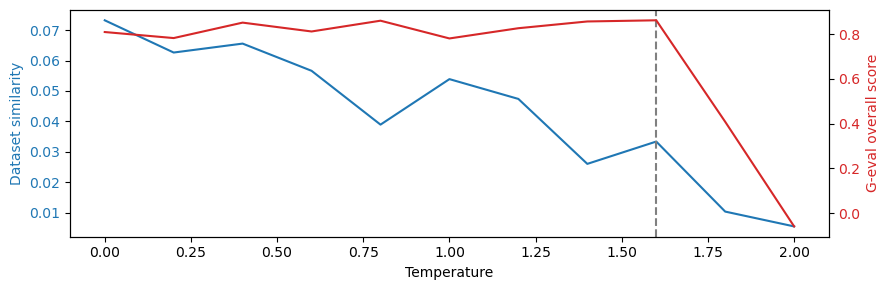

In [213]:
# Assuming Scores is a DataFrame with index as 'Temperature' and 'OverallScore' as column
Scores = testTemp.groupby(['Temperature'])[['OverallScore']].apply(lambda x: x.mean())

# Extract x and y values
x = [list(item.keys())[0] for item in compareTempDiv]
y = [list(item.values())[0] for item in compareTempDiv]

# Create the plot
fig, ax1 = plt.subplots(figsize=(9,3))

color = 'tab:blue'
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Dataset similarity', color=color)
ax1.plot(x, y, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis with a different scale
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('G-eval overall score', color=color)
ax2.plot(Scores.index, Scores['OverallScore'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.axvline(x=1.6, color='gray', linestyle='--')

# Display the plot
fig.tight_layout()
plt.show()

In [ ]:
testTemp

f_key        Experiment               Model  \
814  entprimalivepoploungedan  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   
815  entprimalivepoploungedan  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   
816  entprimalivepoploungedan  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   
817  entprimalivepoploungedan  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   
818  entprimalivepoploungedan  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   
..                        ...               ...                 ...   
919             djpartybombe2  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   
920             djpartybombe2  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   
921             djpartybombe2  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   
922             djpartybombe2  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   
923             djpartybombe2  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   

                                                Prompt  \
814  Create a band description with the following d...   
815  Create a band description with the following d...   
816  Create a band description with the following d...   
817  Create a band description with the following d...   
818  Create a band description with the following d...   
..                                                 ...   
919  Create a band description with the following d...   
920  Create a band description with the following d...   
921  Create a band description with the following d...   
922  Create a band description with the following d...   
923  Create a band description with the following d...   

                                                Answer  \
814  Entprima Live is a Pop Lounge band based in Ke...   
815  Entprima Live is a versatile Pop Lounge Dan ba...   
816  Entprima Live is a dynamic Pop Lounge Dan band...   
817  Entprima Live is a versatile Pop Lounge Dan ba...   
818  Entprima Live is a versatile Pop Lounge Dan ba...   
..                                                 ...   
919  Hailing from Friedberg, DJ PARTYBOMBE is a ver...   
920  Based in Friedberg, DJ PARTYBOMBE is a versati...   
921  DJ PARTYBOMBE is a versatile DJ and entertaine...   
922  Based in Friedberg, DJ PARTYBOMBE is the perfe...   
923  Based in Friedberg, DJ PARTYBOMBE is a versati...   

                                            Parameters  Geval_eng  Geval_flu  \
814  {'genpara': {'Temperature': 0.0}, 'gendata': '...   0.700000   1.000000   
815  {'genpara': {'Temperature': 0.2}, 'gendata': '...   0.788235  -0.333333   
816  {'genpara': {'Temperature': 0.4}, 'gendata': '...   0.612500   0.925926   
817  {'genpara': {'Temperature': 0.6}, 'gendata': '...   0.757895   0.916667   
818  {'genpara': {'Temperature': 0.8}, 'gendata': '...   0.752941   0.687500   
..                                                 ...        ...        ...   
919  {'genpara': {'Temperature': 1.2}, 'gendata': '...   0.529412   0.916667   
920  {'genpara': {'Temperature': 1.4}, 'gendata': '...   0.705882   1.000000   
921  {'genpara': {'Temperature': 1.6}, 'gendata': '...   0.789474   1.000000   
922  {'genpara': {'Temperature': 1.8}, 'gendata': '...   0.800000   0.982456   
923  {'genpara': {'Temperature': 2.0}, 'gendata': '...  -0.200000   0.333333   

     Geval_nat  Geval_inf       TTR  OverallScore  Geval_qua  Temperature  
814   0.982456   0.684211  0.612403      0.841667       0.80          0.0  
815   0.921569   0.611111  0.639344      0.496895       0.80          0.2  
816   0.977778   0.652778  0.690476      0.792245       0.80          0.4  
817   0.901961   0.633333  0.701031      0.802464       0.80          0.6  
818   0.800000   0.763889  0.618644      0.751083       0.80          0.8  
..         ...        ...       ...           ...        ...          ...  
919   0.980392   0.750000  0.635659      0.794118       0.77          1.2  
920   1.000000   0.722222  0.641667      0.857026       0.79          1.4  
921   0.980392   0.750000  0.579310      0.879966       0.80          1.6  
922   1.000000   0.718750  0.647619      0.875302       

In [ ]:
testTemp_pivot = testTemp.pivot(index='f_key', columns='Temperature', values='Answer')
testTemp_pivot.head(1)

Temperature                                                0.0  \
f_key                                                            
bandwarning  Band WARNING is a dynamic group based in Dingo...   

Temperature                                                0.2  \
f_key                                                            
bandwarning  Band WARNING is a high-energy group based in D...   

Temperature                                                0.4  \
f_key                                                            
bandwarning  Band WARNING is a dynamic group based in Dingo...   

Temperature                                                0.6  \
f_key                                                            
bandwarning  Band WARNING is a high-energy band based in Di...   

Temperature                                                0.8  \
f_key                                                            
bandwarning  Band WARNING is a dynamic group based in Dingo...   

Temperature                                                1.0  \
f_key                                                            
bandwarning  Band WARNING is a lively band based in Dingolf...   

Temperature                                                1.2  \
f_key                                                            
bandwarning  Band WARNING is a versatile group hailing from...   

Temperature                                                1.4  \
f_key                                                            
bandwarning  Band WARNING is a high-energy cover band based...   

Temperature                                                1.6  \
f_key                                                            
bandwarning  Based in Dingolfing, Band WARNING specializes ...   

Temperature                                                1.8  \
f_key                                                            
bandwarning  Band WARNING is a high-energy band hailing fro...   

Temperature                                                2.0  
f_key                                                           
bandwarning  Band WARNING is a vibrant live group hailing f...

In [ ]:
band = "djdenki"
Temperature = 1.6

evaluation.highlightNgram(testTemp_pivot.loc[band,0.0], testTemp_pivot.loc[band,Temperature], max_n=4)

n = 2
DJ Denki is a versatile DJ based in Röthlein, specializing in dance, house, lounge music, party, and rap. With experience in a wide range of events including baptisms, birthdays, Christmas parties, city festivals, and weddings, we bring the perfect mix of music to keep the crowd moving. We are available to travel to cities within a 125.0km radius, including Würzburg, Schweinfurt, and Nuremberg. Our playlist includes hits from popular bands like [The Chainsmokers], [Calvin Harris], and [David Guetta]. Let DJ Denki bring the energy and excitement to your next event! 

DJ Denki is a vibrant DJ group based in Röthlein, specializing in dance, house, lounge music, and rap. With our energetic mix of music genres, we are ready to bring the party to your event, be it a baptism, birthday bash, carnival, Christmas party, corporate event, or any other occasion. Whether it's a club, concert, or open-air festival, we deliver top-notch entertainment for all. We are available to perform in citie

In [ ]:
matrix, mean = evaluation.jaccard_sim_score(testTemp, 'Temp-GPT3.5-1106', n={2,3,4})
print(mean)
#matrix.iloc[np.where(testTemp['Temperature'] == 0.00)]
#(matrix.style.background_gradient(cmap='viridis', vmin=0, vmax=1))


0.04755186078013354


In [ ]:
SimText = evaluation.inspectSimMatrix(matrix, testTemp, top=15)
#evaluation.highlightNgram()
print(SimText)

                  f_key1                                            Answer1  \
0      troublemakersriot  Troublemaker's Riot is a blues, country, rock,...   
1          djpartybombe2  Based in Friedberg, DJ PARTYBOMBE is a versati...   
2            bandwarning  Band WARNING is a dynamic group based in Dingo...   
3   martyhisrockincomets  Marty & his Rockin' Comets is a blues, rock 'n...   
4   martyhisrockincomets  Marty & his Rockin' Comets is a blues, rock 'n...   
5      troublemakersriot  Troublemaker's Riot is a blues, country, rock,...   
6      troublemakersriot  Troublemaker's Riot is a blues, country, rock,...   
7             djsoundbar  Based in Bad Reichenhall, DJ Soundbär speciali...   
8   martyhisrockincomets  Marty & his Rockin' Comets is a blues, rock 'n...   
9                 intakt  Intakt is a versatile band based in Biberbach,...   
10                intakt  Intakt is a versatile band based in Biberbach,...   
11           bandwarning  Band WARNING is a high-ene

In [ ]:
row = 1

print("Score: " + str(SimText.loc[row,'Score']))
evaluation.highlightNgram(SimText.loc[row,'Answer1'], SimText.loc[row,'Answer2'], max_n=4)

Score: 0.8426573426573427
n = 2
Based in Friedberg, DJ PARTYBOMBE is a versatile DJ and entertainer specializing in country, dance music, folk music, light music, and party hits. With a wide range of event types including baptisms, birthdays, Christmas parties, weddings, and corporate events, we bring the party to you. Available for gigs in cities within a 200.0km radius such as Frankfurt, Wiesbaden, and Mannheim, we keep the dance floor packed with hits from popular bands like [The Beatles], [ABBA], and [Michael Jackson]. Let DJ PARTYBOMBE bring the energy and fun to your next event! 

Based in Friedberg, DJ PARTYBOMBE is a versatile DJ and entertainer specializing in country, dance music, folk music, light music, and party hits. With a wide range of event types including baptisms, birthdays, Christmas parties, weddings, and corporate events, we bring the party to you. Available for gigs in cities within a 200.0km radius such as Frankfurt, Wiesbaden, and Mannheim, we keep the dance fl

In [ ]:
testTemp

f_key        Experiment               Model  \
814  entprimalivepoploungedan  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   
815  entprimalivepoploungedan  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   
816  entprimalivepoploungedan  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   
817  entprimalivepoploungedan  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   
818  entprimalivepoploungedan  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   
..                        ...               ...                 ...   
919             djpartybombe2  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   
920             djpartybombe2  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   
921             djpartybombe2  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   
922             djpartybombe2  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   
923             djpartybombe2  Temp-GPT3.5-1106  gpt-3.5-turbo-1106   

                                                Prompt  \
814  Create a band description with the following d...   
815  Create a band description with the following d...   
816  Create a band description with the following d...   
817  Create a band description with the following d...   
818  Create a band description with the following d...   
..                                                 ...   
919  Create a band description with the following d...   
920  Create a band description with the following d...   
921  Create a band description with the following d...   
922  Create a band description with the following d...   
923  Create a band description with the following d...   

                                                Answer  \
814  Entprima Live is a Pop Lounge band based in Ke...   
815  Entprima Live is a versatile Pop Lounge Dan ba...   
816  Entprima Live is a dynamic Pop Lounge Dan band...   
817  Entprima Live is a versatile Pop Lounge Dan ba...   
818  Entprima Live is a versatile Pop Lounge Dan ba...   
..                                                 ...   
919  Hailing from Friedberg, DJ PARTYBOMBE is a ver...   
920  Based in Friedberg, DJ PARTYBOMBE is a versati...   
921  DJ PARTYBOMBE is a versatile DJ and entertaine...   
922  Based in Friedberg, DJ PARTYBOMBE is the perfe...   
923  Based in Friedberg, DJ PARTYBOMBE is a versati...   

                                            Parameters  Geval_eng  Geval_flu  \
814  {'genpara': {'Temperature': 0.0}, 'gendata': '...   0.700000   1.000000   
815  {'genpara': {'Temperature': 0.2}, 'gendata': '...   0.788235  -0.333333   
816  {'genpara': {'Temperature': 0.4}, 'gendata': '...   0.612500   0.925926   
817  {'genpara': {'Temperature': 0.6}, 'gendata': '...   0.757895   0.916667   
818  {'genpara': {'Temperature': 0.8}, 'gendata': '...   0.752941   0.687500   
..                                                 ...        ...        ...   
919  {'genpara': {'Temperature': 1.2}, 'gendata': '...   0.529412   0.916667   
920  {'genpara': {'Temperature': 1.4}, 'gendata': '...   0.705882   1.000000   
921  {'genpara': {'Temperature': 1.6}, 'gendata': '...   0.789474   1.000000   
922  {'genpara': {'Temperature': 1.8}, 'gendata': '...   0.800000   0.982456   
923  {'genpara': {'Temperature': 2.0}, 'gendata': '...  -0.200000   0.333333   

     Geval_nat  Geval_inf       TTR  OverallScore  Geval_qua  Temperature  
814   0.982456   0.684211  0.612403      0.841667       0.80          0.0  
815   0.921569   0.611111  0.639344      0.496895       0.80          0.2  
816   0.977778   0.652778  0.690476      0.792245       0.80          0.4  
817   0.901961   0.633333  0.701031      0.802464       0.80          0.6  
818   0.800000   0.763889  0.618644      0.751083       0.80          0.8  
..         ...        ...       ...           ...        ...          ...  
919   0.980392   0.750000  0.635659      0.794118       0.77          1.2  
920   1.000000   0.722222  0.641667      0.857026       0.79          1.4  
921   0.980392   0.750000  0.579310      0.879966       0.80          1.6  
922   1.000000   0.718750  0.647619      0.875302       

In [ ]:
ResultsDF.groupby('Experiment')[['Geval_eng','Geval_flu','Geval_nat','Geval_inf','TTR', 'OverallScore', 'Geval_qua']].apply(lambda x: x.mean())

Geval_eng  Geval_flu  Geval_nat  Geval_inf       TTR  \
Experiment                                                                   
AltIns-GPT3.5          3.986667   2.983945   2.993333   2.918333  0.640938   
AltIns-GPT4            4.040351   2.998333   2.993158   3.016754  0.573479   
Base-GPT-3.5-1106      3.658947   2.740890   2.986000   2.968000  0.658355   
Base-GPT-4-1106        4.008000   2.943621   2.978000   3.007000  0.563228   
Base-Llama2-13b-chat   4.000000   3.000000   2.979737   3.005000  0.520429   
Base-Para-GPT3.5       4.000000   3.000000   2.980000   3.005000  0.564352   
Base-Para-GPT4         3.995000   2.609444   2.864737   3.010000  0.539272   
Fewshot-GPT3.5         4.645717   0.097778   1.798039   3.949201  0.578420   
Fewshot-GPT4           4.712906   0.000000   2.198333   3.978158  0.546142   
Original               3.413080   2.462393   2.725884   2.145434  0.747255   
Original_Quality       3.313560   2.347586   2.602805   2.425474  0.714519   
Original_div           3.547421   2.485881   2.750060   2.634770  0.696386   
Original_para          3.462632   2.478624   2.747522   2.632632  0.696732   
Shuffle-GPT3.5         3.998333   2.673407   2.965663   2.996667  0.612918   
Shuffle-GPT4           4.031667   2.995556   2.993333   3.030000  0.546570   
T5-div                 1.164805   1.089738   1.009452   1.205105  0.371175   
T5-div-2               1.201394   1.137091   0.987053   1.256947  0.340243   
Temp-GPT3.5-1106       3.117371   2.235795   2.479975   2.554974  0.676371   
Temp-GPT4              2.696842   1.935293   1.993991   2.157588  0.663234   
Topp-GPT3.5            4.182955   2.784090   1.855046   3.811942  0.623765   

                      OverallScore  Geval_qua  
Experiment                                     
AltIns-GPT3.5             0.879836   4.058596  
AltIns-GPT4               0.889856   4.635107  
Base-GPT-3.5-1106         0.845688   4.011105  
Base-GPT-4-1106           0.881806   4.361000  
Base-Llama2-13b-chat      0.886124   4.135000  
Base-Para-GPT3.5          0.886146   4.125000  
Base-Para-GPT4            0.844057   4.181813  
Fewshot-GPT3.5            0.637096   0.073333  
Fewshot-GPT4              0.667475   0.000000  
Original                  0.737100   3.240555  
Original_Quality          0.729803   3.686202  
Original_div              0.778373   3.843316  
Original_para             0.773183   3.857778  
Shuffle-GPT3.5            0.857131   4.119990  
Shuffle-GPT4              0.890032   4.374493  
T5-div                    0.308492   1.318526  
T5-div-2                  0.315641   1.384579  
Temp-GPT3.5-1106          0.708535   3.446722  
Temp-GPT4                 0.597132   3.008772  
Topp-GPT3.5               0.833989   4.060000

### Top-p

As expected a low value reduces the diversity in generated text. As we already start with the highest possible value by default, this parameter can only negatively impact our generational ability.

In [ ]:
# Top-p test 

def toppVarTest(task1_para, experiment, model = 'gpt-3.5-turbo-1106', evalModel = 'gpt-4-1106-preview'):
  """Test top-p variation on a given dataset and model.
  Returns a new ResultsDF"""
  #create a new result DF
  data =  [(task1_para.iloc[r]['f_key'], experiment, model, [{'genpara':{'Top_p': float('%.3f'%(j))}}], train.gen_prompt1(task1_para.iloc[r]))  \
         for r in range(len(task1_para)) \
         for j in [0.1,0.3,0.5,0.7,1]]
  tmp_ResultsDF = pd.DataFrame(data, columns=['f_key', 'Experiment', 'Model', 'Parameters', 'Prompt'])
  tmp_ResultsDF = tmp_ResultsDF.reindex(columns=['f_key', 'Experiment', 'Model', 'Prompt', 'Answer', 'Parameters', 'Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'TTR', 'OverallScore', 'Geval_qua'])
  evaluation.addGendata2ResultsDF(tmp_ResultsDF, task1_para)

  #run queries
  for index, row in tqdm.tqdm(tmp_ResultsDF.iterrows()):
    APIquery = openai.ChatCompletion.create(
      model= model,
      messages=[{"role": "user", "content": row.Prompt}],
      top_p=row.Parameters[0]['genpara']['Top_p'],
      max_tokens=500
    )
    tmp_ResultsDF.loc[index, 'Answer'] = APIquery.choices[0].message.content
    tmp_ResultsDF.loc[index, 'Prompt'] = row.Prompt

  #run eval
  try:
    errors = evaluation.eval(tmp_ResultsDF, savepath=savepath, model=evalModel)
  except:
    print("Evaluation failed")
    return tmp_ResultsDF, None
  return tmp_ResultsDF, errors
  #ResultsDF = pd.concat([ResultsDF, tmp_ResultsDF], ignore_index=True)
  #return ResultsDF


In [ ]:
# ######### Uncomment if you wish to rerun the top_p test
# ResultsDF_tmp, errors = toppVarTest(task1_para, experiment = 'Topp-GPT3.5', model='gpt-3.5-turbo-1106', evalModel='gpt-3.5-turbo-1106')
# ResultsDF = pd.concat([ResultsDF, ResultsDF_tmp], ignore_index=True)
# print(errors)
# ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

In [ ]:
testTopp = ResultsDF[ResultsDF.Experiment == "Topp-GPT3.5"].explode('Parameters')
testTopp['Topp'] = testTopp['Parameters'].apply(lambda x: float('%.2f'%x['genpara']['Top_p']) if isinstance(x, dict) else None)

# Define the maximum values for each column
max_values = {'Geval_eng': 5, 'Geval_flu': 3, 'Geval_nat': 3, 'Geval_inf': 4, 'Geval_qua': 5}
min_val = 0

# Apply the normalization
for col in ['Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'Geval_qua']:
    testTopp[col] = (testTopp[col]-min_val) / (max_values[col]-min_val)

styled = (testTopp.groupby(['Topp'])[['Geval_eng','Geval_flu','Geval_nat','Geval_inf', 'Geval_qua','OverallScore']] #TTR left out
 .apply(lambda x: x.mean()) #can remove values of -1 [x >= 0]
 .style.background_gradient(cmap='viridis', vmin=0, vmax=1) #, vmin=0, vmax=1
)

# Convert the styled DataFrame to an HTML string
html = styled.to_html(table_attributes="border=3px")

# Write the HTML string to a file
with open(savepath + '/Output/ToppTest.html', 'w') as f:
    f.write(html)
#TODO: convert to png/vectorfile or other

styled

In [ ]:
matrix, mean = evaluation.jaccard_sim_score(testTopp, "Topp-GPT3.5", n={3,4})
print(mean)
#print(matrix)

0.048082722458916934


In [ ]:
#Study of the effect of top_p on the generated text by band.
#Similarity for top_p

columnNames = ["0.1","0.3","0.5","0.7","1"]

compareTopp = pd.DataFrame(columns=columnNames)
for key in testTopp.f_key.unique():
  matrix, mean = evaluation.jaccard_sim_score(testTopp[testTopp.f_key == key], 'Topp-GPT3.5', n={2,3,4})
  matrix = matrix.apply(pd.to_numeric, errors='coerce')
  matrix.columns = columnNames
  matrix['f_key'] = key
  # 4 means we compare to top_p=1; 0 means we compare to top_p=0.1
  compareTopp = pd.concat([compareTopp, matrix.iloc[[4]]], ignore_index=False)

#compareTopp = compareTopp.drop(columns=['0.1'])
compareTopp.style.background_gradient(cmap='viridis', vmin=0, vmax=1)

C:\Users\alex\AppData\Local\Temp\ipykernel_28312\1567924471.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  compareTopp = pd.concat([compareTopp, matrix.iloc[[4]]], ignore_index=False)


In [ ]:
testTopp_pivot = testTopp.pivot(index='f_key', columns='Topp', values='Answer')
testTopp_pivot.head(3)

Topp                                                         0.1  \
f_key                                                              
bandwarning    WARNING is a dynamic band based in Dingolfing,...   
djdenki        Based in Röthlein, DJ Denki is a dynamic and v...   
djpartybombe2  Based in Friedberg, DJ PARTYBOMBE is a dynamic...   

Topp                                                         0.3  \
f_key                                                              
bandwarning    WARNING is a dynamic band based in Dingolfing,...   
djdenki        Based in Röthlein, DJ Denki is a dynamic and v...   
djpartybombe2  Based in Friedberg, DJ PARTYBOMBE is a dynamic...   

Topp                                                         0.5  \
f_key                                                              
bandwarning    Band WARNING is a high-energy party band based...   
djdenki        Based in Röthlein, DJ Denki is a dynamic and v...   
djpartybombe2  Based in Friedberg, DJ PARTYBOMBE is a versati...   

Topp                                                         0.7  \
f_key                                                              
bandwarning    Band WARNING is a dynamic and versatile band b...   
djdenki        Based in Röthlein, DJ Denki is a dynamic and v...   
djpartybombe2  Based in Friedberg, DJ PARTYBOMBE is a dynamic...   

Topp                                                         1.0  
f_key                                                             
bandwarning    Band WARNING is a dynamic and versatile group ...  
djdenki        Hailing from Röthlein, DJ Denki is a dynamic a...  
djpartybombe2  Based in Friedberg, DJ PARTYBOMBE is a dynamic...

In [ ]:
print(testTopp_pivot.loc['livehouse'].iloc[0])

LIVE HOUSE is a dynamic band and DJ duo based in Düsseldorf, specializing in dancemusic, lightmusic, loungemusic, and party vibes. Our versatile repertoire makes us the perfect choice for a wide range of events, including birthdays, Christmas parties, city festivals, clubs, concerts, corporate events, galas, open-air gatherings, summer parties, and wedding celebrations.

We are willing to travel to cities within a 1000.0km radius, such as Amsterdam, Brussels, and Paris, to bring our electrifying performances to audiences far and wide.

Our setlist includes popular hits from well-known bands like [Daft Punk], [The Chainsmokers], and [Calvin Harris], ensuring that everyone at your event will be on their feet and dancing the night away. Whether you're looking for a live band or a DJ to keep the party going, LIVE HOUSE is the ultimate choice for an unforgettable musical experience.


## Prompt variation

### Logit Bias

works token-wise, might not be as effective as hoped

In [81]:
# logit bias test 

# "captivating and comprehensive" was not in the prompt at the time
import tiktoken
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
import string

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.casefold() not in stop_words]
    return " ".join(filtered_text)

def logitBiasTest(task1_div, experiment, model = 'gpt-3.5-turbo-1106', evalModel = 'gpt-4-1106-preview', promptGen = train.gen_prompt1):
  """Test a base query with logit bias on a given dataset and model.
  Returns a new ResultsDF"""
  #create a new result DF
  data =  [(task1_div.iloc[r]['f_key'], experiment, model, [{'genpara':{'Temperature': 1.0}}], promptGen(task1_div.iloc[r]))  \
         for r in range(len(task1_div))]
  tmp_ResultsDF = pd.DataFrame(data, columns=['f_key', 'Experiment', 'Model', 'Parameters', 'Prompt'])
  tmp_ResultsDF = tmp_ResultsDF.reindex(columns=['f_key', 'Experiment', 'Model', 'Prompt', 'Answer', 'Parameters', 'Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'TTR', 'OverallScore', 'Geval_qua'])
  evaluation.addGendata2ResultsDF(tmp_ResultsDF, task1_div)

  tiktokenizer = tiktoken.get_encoding("cl100k_base")
  #save most used words without stopwords
  allTokens = []
  logit_bias = {}
  logit_bias_factor = {}
  logit_bias_hist = []
  token_counts_hist = []

  #run queries
  for index, row in tqdm.tqdm(tmp_ResultsDF.iterrows()):
    APIquery = openai.ChatCompletion.create(
      model= model,
      messages=[{"role": "user", "content": row.Prompt}],
      temperature=1.0,
      max_tokens=500,
      logit_bias=logit_bias
    )
    tmp_ResultsDF.loc[index, 'Answer'] = APIquery.choices[0].message.content
    tmp_ResultsDF.loc[index, 'Prompt'] = row.Prompt

    answer = APIquery.choices[0].message.content
    #remove stopwords
    answer_tokens = tiktokenizer.encode(answer)
    #append to allWords
    # allWords +=  ' ' + answer
    
    #remove tokens with less than 4 characters as we don't care about punctuation etc.
    to_rem = []
    for t in answer_tokens:
      if len(tiktokenizer.decode_single_token_bytes(t)) < 5:
        to_rem.append(t)
    answer_tokens_sanitized = [t for t in answer_tokens if t not in to_rem]
    
    allTokens.extend(answer_tokens_sanitized)
    # tokens = tiktokenizer.encode(allWords)
    token_counts = Counter(allTokens)
    # Find the 100 most frequent tokens
    most_frequent_tokens = [token for token, _ in token_counts.most_common(100)]

    token_counts_hist.append(token_counts)
    
    #Count how often a token has already appeared in the previous generations 
    # old occurence get less influencial each time
    for token in logit_bias_factor:
      if token in most_frequent_tokens:
        logit_bias_factor[token] += 1
      elif logit_bias_factor[token] > 0:
        logit_bias_factor[token] += -1
    
    for token in most_frequent_tokens:
      if token not in logit_bias_factor:
        logit_bias_factor[token] = 1

    # Create a logit bias dictionary with a negative bias for the most frequent tokens
    logit_bias = {token: max(logit_bias_factor[token]*(-10), -100) for token in most_frequent_tokens}
    #TODO: change such that each time a token appears here, increase negative bias

    #keep history of logit bias factor
    logit_bias_hist.append(logit_bias_factor.copy())

  #run eval
  # try:
  #   errors = evaluation.eval(tmp_ResultsDF, savepath=savepath, model=evalModel)
  # except:
  #   print("Evaluation failed")
  #   return tmp_ResultsDF, None
  return tmp_ResultsDF, token_counts_hist, logit_bias_hist
  #ResultsDF = pd.concat([ResultsDF, tmp_ResultsDF], ignore_index=True)
  #return ResultsDF

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [83]:
# ######### Uncomment if you wish to rerun the base test
# ResultsDF_tmp, token_counts_hist, logit_bias_hist = logitBiasTest(task1_div, 'adaptlogitBias-GPT3.5', model = 'gpt-3.5-turbo-1106', evalModel = 'gpt-4-1106-preview')
# ResultsDF = pd.concat([ResultsDF, ResultsDF_tmp], ignore_index=True)
# print(errors)
# ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

0it [00:00, ?it/s]C:\Users\alex\AppData\Local\Temp\ipykernel_18672\935892587.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Introducing The Letters, a dynamic and versatile band hailing from the vibrant city of Nittendorf. With a passion for dancemusic, lightmusic, party, pop, and rock, we specialize in delivering high-energy performances that leave audiences mesmerized and wanting more. As a talented duet, we bring a unique blend of vocal harmonies and instrumental skills that set the stage on fire.

Our versatile sound makes us the perfect choice for a wide range of events, including birthdays, churches, club appearances, club festivals, corporate events, galas, summer parties, weddings, and wedding parties. No matter the occasion, we pride ourselves on delivering an unforgettable musical experience that keeps the crowd on their feet and fully entertained.

From Nittendorf to nearby cities within a 110.0km 

In [243]:
encoding.encode(' where')

[1405]

In [244]:
# logb = logit_bias_hist[-1]
del logb[1405]

C:\Users\alex\AppData\Local\Temp\ipykernel_18672\2802238590.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top_cmap = cm.get_cmap('Reds', len(top_bias))
C:\Users\alex\AppData\Local\Temp\ipykernel_18672\2802238590.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  lower_cmap = cm.get_cmap('Blues', len(lower_bias))


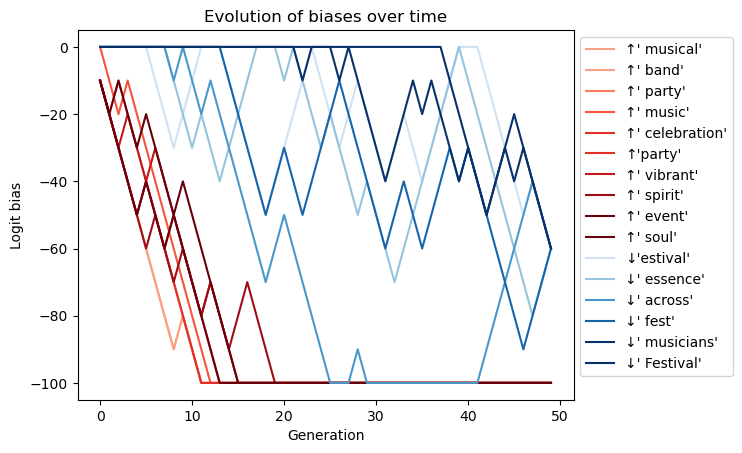

In [256]:
from matplotlib import cm

# logb = logit_bias_hist[-1]
top_bias = sorted(logb, key=logb.get, reverse=True)[:10]
lower_bias = sorted(logb, key=logb.get, reverse=True)[90:96]

#color maps
top_cmap = cm.get_cmap('Reds', len(top_bias))
lower_cmap = cm.get_cmap('Blues', len(lower_bias))

from matplotlib.colors import ListedColormap

# Define the lower limit for the color maps (0-1)
lower_limit = 0.3

# Create new color maps that start from the lower limit
top_cmap = ListedColormap(top_cmap(np.linspace(lower_limit, 1, len(top_bias))))
lower_cmap = ListedColormap(lower_cmap(np.linspace(lower_limit, 1, len(lower_bias))))

# token_bias_hist = []
for idx, token in enumerate(top_bias):
  #extract bias from each generation
  token_bias = []
  for i in range(len(logit_bias_hist)):
    if token not in logit_bias_hist[i]:
      token_bias.append(0)
    else:
      token_bias.append(max(logit_bias_hist[i][token]*(-10), -100))
      # token_bias.append(logit_bias_hist[i][token]) #for seeing how often token was in top100
  
  # token_bias_hist.append({token:token_bias})
  # print(token)
  token_name = "\u2191'" + encoding.decode_single_token_bytes(token).decode("utf-8") + "'"

  plt.plot(token_bias, color=top_cmap(idx), label=token_name)

for idx, token in enumerate(lower_bias):
  #extract bias from each generation
  token_bias = []
  for i in range(len(logit_bias_hist)):
    if token not in logit_bias_hist[i]:
      token_bias.append(0)
    else:
      token_bias.append(max(logit_bias_hist[i][token]*(-10), -100))
      # token_bias.append(logit_bias_hist[i][token]) #for seeing how often token was in top100
  
  # token_bias_hist.append({token:token_bias})
  # print(token)
  token_name = "\u2193'" + encoding.decode_single_token_bytes(token).decode("utf-8") + "'"

  plt.plot(token_bias, color=lower_cmap(idx), label=token_name)

# Add a legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

# Set the title and labels
plt.title('Evolution of biases over time')
plt.xlabel('Generation')
plt.ylabel('Logit bias')

# Show the plot
plt.show()

In [85]:
biased = []
for counter in token_counts_hist:
  biased.append([token for token, _ in counter.most_common(100)])

# Get the last Counter in the list
last_counter = token_counts_hist[-1]

# Get the top 10 most common tokens of last counter
top_10_tokens = last_counter.most_common(10)

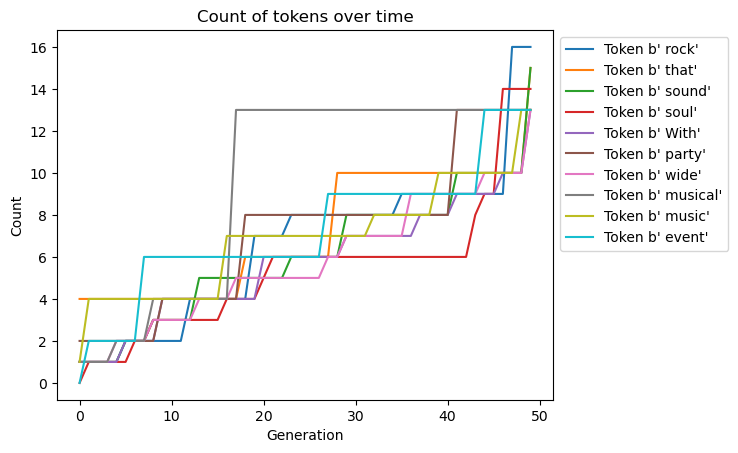

In [91]:
import matplotlib.pyplot as plt

n=10

# Get the last Counter in the list
last_counter = token_counts_hist[-1]

# Get the top 10 most common tokens of last counter
top_n_tokens = last_counter.most_common(n)

# Initialize an empty dictionary
token_indices = {}

# For each token in the top 10 tokens
for token, _ in top_n_tokens:
    # Initialize an empty list for the indices
    indices = []

    # For each list in biased
    for i, biased_list in enumerate(biased):
        # If the token is in the list
        if token in biased_list:
            # Add the index to the list
            indices.append(i)

    # Add the list of indices to the dictionary
    token_indices[token] = indices

# Tokens to track
tokens = [token for token, _ in top_n_tokens]

# For each token
for token in tokens:
    # Get the count of the token in each Counter
    counts = [counter[token] for counter in token_counts_hist]

    # Create a line plot of the counts
    plt.plot(counts, label=f'Token {encoding.decode_single_token_bytes(token)}') #.decode("utf-8")
    
    # # If the token is in token_indices
    # if token in token_indices:
    #     # For each index in token_indices[token]
    #     for index in token_indices[token]:
    #         # Add a 'x' marker at the index
    #         plt.scatter(index, counts[index], marker='|', color='red')

# Add a legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

# Set the title and labels
plt.title('Count of tokens over time')
plt.xlabel('Generation')
plt.ylabel('Count')

# Show the plot
plt.show()

In [131]:
token_counts_hist[-1]

Counter({71175: 27,
         86282: 23,
         61098: 18,
         8145: 17,
         1113: 16,
         4954: 16,
         4455: 15,
         220: 15,
         3363: 15,
         452: 14,
         4832: 14,
         4907: 14,
         11936: 14,
         18273: 14,
         3217: 14,
         4731: 14,
         5222: 14,
         24601: 14,
         473: 14,
         268: 14,
         4295: 14,
         10877: 14,
         743: 14,
         287: 14,
         9305: 14,
         16781: 14,
         23738: 14,
         90366: 14,
         1101: 14,
         18734: 14,
         4717: 13,
         7091: 13,
         23944: 13,
         9875: 13,
         1579: 13,
         15612: 13,
         5127: 13,
         5016: 13,
         32487: 13,
         15051: 13,
         34076: 13,
         603: 13,
         3196: 13,
         17226: 13,
         2134: 13,
         7029: 13,
         25975: 13,
         15553: 13,
         13306: 13,
         5873: 13,
         55090: 13,
         49277: 1

[Counter({1567: 4,
          4968: 3,
          652: 3,
          7675: 3,
          11406: 3,
          7200: 2,
          2477: 2,
          39032: 2,
          4731: 2,
          735: 2,
          21643: 2,
          268: 2,
          19309: 2,
          4832: 2,
          9875: 2,
          9919: 2,
          220: 2,
          8915: 1,
          33045: 1,
          58394: 1,
          5916: 1,
          15612: 1,
          4717: 1,
          90949: 1,
          20817: 1,
          23944: 1,
          32629: 1,
          93627: 1,
          5644: 1,
          4546: 1,
          17139: 1,
          16924: 1,
          3217: 1,
          13440: 1,
          13306: 1,
          13166: 1,
          6469: 1,
          3363: 1,
          584: 1,
          588: 1,
          2751: 1,
          6651: 1,
          2567: 1,
          15051: 1,
          7693: 1,
          77768: 1,
          56886: 1,
          85773: 1,
          13280: 1,
          11113: 1,
          55090: 1,
          302

### Data order and presence/modification

- reorder prompt
- shuffle data in genres and events

In [281]:
# Prompt shuffling test 

def promptVarTest(task1_para, experiment, model = 'gpt-3.5-turbo-1106', evalModel = 'gpt-4-1106-preview'):
  """Test temperature variation on a given dataset and model.
  Returns a new ResultsDF"""
  #create a new result DF
  data =  [(task1_para.iloc[r]['f_key'], experiment, model, [{'Rand': j}], train.gen_prompt1_rand(task1_para.iloc[r]))  \
         for r in range(len(task1_para)) \
         for j in range(3)]
  tmp_ResultsDF = pd.DataFrame(data, columns=['f_key', 'Experiment', 'Model', 'Parameters', 'Prompt'])
  tmp_ResultsDF = tmp_ResultsDF.reindex(columns=['f_key', 'Experiment', 'Model', 'Prompt', 'Answer', 'Parameters', 'Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'TTR', 'OverallScore', 'Geval_qua'])
  evaluation.addGendata2ResultsDF(tmp_ResultsDF, task1_para)

  #run queries
  for index, row in tqdm.tqdm(tmp_ResultsDF.iterrows()):
    APIquery = openai.ChatCompletion.create(
      model= model,
      messages=[{"role": "user", "content": row.Prompt}],
      temperature=1.0,
      max_tokens=500
    )
    tmp_ResultsDF.loc[index, 'Answer'] = APIquery.choices[0].message.content
    tmp_ResultsDF.loc[index, 'Prompt'] = row.Prompt

  #run eval
  try:
    errors = evaluation.eval(tmp_ResultsDF, savepath=savepath, model=evalModel)
  except:
    print("Evaluation failed")
    return tmp_ResultsDF, None

  return tmp_ResultsDF, errors
  #ResultsDF = pd.concat([ResultsDF, tmp_ResultsDF], ignore_index=True)
  #return ResultsDF

def promptVarDivTest(task1_div, experiment, model = 'gpt-3.5-turbo-1106', evalModel = 'gpt-4-1106-preview'):
  """Test temperature variation on a given dataset and model.
  Returns a new ResultsDF"""
  #create a new result DF
  data =  [(task1_div.iloc[r]['f_key'], experiment, model, [{}], train.gen_prompt1_rand(task1_div.iloc[r]))  \
         for r in range(len(task1_div))]
  tmp_ResultsDF = pd.DataFrame(data, columns=['f_key', 'Experiment', 'Model', 'Parameters', 'Prompt'])
  tmp_ResultsDF = tmp_ResultsDF.reindex(columns=['f_key', 'Experiment', 'Model', 'Prompt', 'Answer', 'Parameters', 'Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'TTR', 'OverallScore', 'Geval_qua'])
  evaluation.addGendata2ResultsDF(tmp_ResultsDF, task1_div)

  #run queries
  for index, row in tqdm.tqdm(tmp_ResultsDF.iterrows()):
    APIquery = openai.ChatCompletion.create(
      model= model,
      messages=[{"role": "user", "content": row.Prompt}],
      temperature=1.0,
      max_tokens=500
    )
    tmp_ResultsDF.loc[index, 'Answer'] = APIquery.choices[0].message.content
    tmp_ResultsDF.loc[index, 'Prompt'] = row.Prompt

  #run eval
  try:
    errors = evaluation.eval(tmp_ResultsDF, savepath=savepath, model=evalModel)
  except:
    print("Evaluation failed")
    return tmp_ResultsDF, None

  return tmp_ResultsDF, errors
  #ResultsDF = pd.concat([ResultsDF, tmp_ResultsDF], ignore_index=True)
  #return ResultsDF

In [285]:
# ######### Uncomment if you wish to rerun the base test
ResultsDF_tmp, errors = promptVarDivTest(task1_div, 'ShuffleDiv-GPT4', model = 'gpt-4-1106-preview', evalModel = 'gpt-4-1106-preview')
ResultsDF = pd.concat([ResultsDF, ResultsDF_tmp], ignore_index=True)
print(errors)
ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

0it [00:00, ?it/s]

C:\Users\alex\AppData\Local\Temp\ipykernel_18672\426565551.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Embark on a musical journey with The Letters, the dynamic duet hailing from the heart of Nittendorf, whose riveting performances have been the highlight of social gatherings near and far. This versatile pair is renowned for delivering an electrifying medley of music genres, encompassing the energy of rock, the rhythm of dance music, the soul of party anthems, the ubiquitous appeal of pop, and the soothing melodies of light music. 

When looking for the ultimate soundtrack to your event - whether it's the intimate vow exchanges of a wedding, the vibrant atmosphere of a club, the carefree joy of a summer party, the elegance of a gala, the festivities of a wedding party, the excitement of a club festival, the cherished moments at a birthday, the professionalism of a corporate event, or the sanctity of a chur

Running G-Eval Engagingness


100%|██████████| 50/50 [01:37<00:00,  1.95s/it]


Running G-Eval Fluidity


100%|██████████| 50/50 [01:43<00:00,  2.06s/it]


Running G-Eval Naturalness


100%|██████████| 50/50 [01:30<00:00,  1.81s/it]


Running G-Eval Informativeness


100%|██████████| 50/50 [02:00<00:00,  2.41s/it]


Running G-eval Quality 


100%|██████████| 50/50 [01:45<00:00,  2.10s/it]


  Response_en ResClean_en  Score_en Error_en    f_key       Experiment  \
0         NaN         NaN       NaN      NaN  mix2max  ShuffleDiv-GPT4   
1         NaN         NaN       NaN      NaN    koana  ShuffleDiv-GPT4   

                                              Answer  \
0  Hailing from the scenic vistas of Pollenfeld, ...   
1  Immerse yourself in the eclectic soundscape of...   

                                        Response_flu  \
0  3,3,3,3,3,3,3,3,Flu,3\n,2\n,Flu,2.,2.,3,Flu,2....   
1  Flu,3,3,3,Flu,3,3,3,Flu,2.,3,Flu,Flu,3,3,2,Flu...   

                ResClean_flu  Score_flu  ...  Score_nat Error_nat  \
0      3,3,3,3,3,3,3,3,3,3,3   3.000000  ...        NaN       NaN   
1  3,3,3,3,3,3,3,3,3,2,3,3,3   2.923077  ...        NaN       NaN   

  Response_inf  ResClean_inf Score_inf Error_inf Response_qua  ResClean_qua  \
0          NaN           NaN       NaN       NaN          NaN           NaN   
1          NaN           NaN       NaN       NaN          NaN           N

In [286]:
ResultsDF[ResultsDF.Experiment!='ShuffleDiv-GPT3.5']

f_key       Experiment               Model  \
0               partybandhilight         Original                 NaN   
1                          fonix         Original                 NaN   
2                     theletters         Original                 NaN   
3                  die4lustigen3         Original                 NaN   
4     rainerseidl-schlagersanger         Original                 NaN   
...                          ...              ...                 ...   
2169              happybavarians  ShuffleDiv-GPT4  gpt-4-1106-preview   
2170          dinner-undbarmusik  ShuffleDiv-GPT4  gpt-4-1106-preview   
2171                   stingrays  ShuffleDiv-GPT4  gpt-4-1106-preview   
2172                     bigbeat  ShuffleDiv-GPT4  gpt-4-1106-preview   
2173                  krohnband2  ShuffleDiv-GPT4  gpt-4-1106-preview   

                                                 Prompt  \
0                                                   NaN   
1                                                   NaN   
2                                                   NaN   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
2169  Create a captivating and comprehensive band de...   
2170  Create a captivating and comprehensive band de...   
2171  Create a captivating and comprehensive band de...   
2172  Create a captivating and comprehensive band de...   
2173  Create a captivating and comprehensive band de...   

                                                 Answer  \
0                              Jetzt auf deutsch bitte.   
1     Servus miteinander. Wir, die Band "Fönix" sind...   
2     Wir machen Ihr Fest zu einem unvergessenem Erl...   
3     Die4Lustigen3 sind ein Stimmunstrio für Feste ...   
4     Damit eine Party zum Erfolg wird, ist neben gu...   
...                                                 ...   
2169  Nestled in the heart of Sauerlach, the Happy B...   
2170  Step into the enchanting realm of Dinner- und ...   
2171  Ignite your event with the electrifying energy...   
2172  Hailing from the picturesque town of Hengersbe...   
2173  Dive into the soul-stirring melodies of KROHN ...   

                                             Parameters  Geval_eng  Geval_flu  \
0     [{'gendata': 'name = Partyband Hi!light,
homet...  -1.000000   0.000000   
1     [{'gendata': 'name = Fönix,
hometown = Frauena...   3.350000   2.900000   
2     [{'gendata': 'name = The Letters,
hometown = N...   3.631579   2.888889   
3     [{'gendata': 'name = Die 4 Lustigen 3,
hometow...   3.850000   2.944444   
4     [{'gendata': 'name = Rainer Seidl - Schlagersä...   4.050000   2.700000   
...                                                 ...        ...        ...   
2169  [{'gendata': 'name = Happy Bavarians,
hometown...   4.000000   3.000000   
2170  [{'gendata': 'name = Dinner- und Barmusik,
hom...   4.150000   2.947368   
2171  [{'gendata': 'name = Stingrays,
hometown = Mün...   4.050000   3.000000   
2172  [{'gendata': 'name = BigBeat,
hometown = Henge...   4.350000   3.000000   
2173  [{'gendata': 'name = KROHN BAND,
hometown = Mu...   4.050000   3.000000   

      Geval_nat  Geval_inf  ...  OverallScore  Geval_qua  OverallRank  \
0     -1.000000  -1.000000  ...     -0.195833  -1.000000          NaN   
1      2.944444   2.315789  ...      0.799274   3.300000          NaN   
2      2.900000   2.684211  ...      0.831750   3.850000          NaN   
3      3.000000   2.368421  ...      0.835897   3.200000          NaN   
4      2.944444   2.000000  ...      0.797870   3.600000          NaN   
...         ...        ...  ...           ...        ...          ...   
2169   3.000000   3.050000  ...      0.890625   4.052632          NaN   
2170   3.000000   3.050000  ...      0.893739   4.842105          NaN   
2171   3.000000   3.000000  ...      0.890000   4.950000          NaN   
2172   3.000000   3.000000  .

In [287]:
# ######### Uncomment if you wish to rerun the base test
ResultsDF_tmp, errors = promptVarDivTest(task1_div, 'ShuffleDiv-GPT3.5', model = 'gpt-3.5-turbo-1106', evalModel = 'gpt-4-1106-preview')
ResultsDF = pd.concat([ResultsDF, ResultsDF_tmp], ignore_index=True)
print(errors)
ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

0it [00:00, ?it/s]

C:\Users\alex\AppData\Local\Temp\ipykernel_18672\426565551.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'The Letters are a dynamic band from Nittendorf, specializing in pop, rock, dancemusic, lightmusic, and party genres. Whether you're planning a church event, wedding party, birthday celebration, club festival, corporate event, or gala, The Letters will be sure to get everyone on their feet and dancing. With the ability to travel to cities within a 110.0km radius, including Regensburg, Kelheim, and Ingolstadt, our band is ready to bring the party to you. Our diverse music repertoire includes well-known hits from [Coldplay], [Maroon 5], [Bruno Mars], and many more. Whether you're celebrating a special occasion or hosting a club summer party, The Letters is your ultimate choice for lively and captivating music entertainment.' has dtype incompatible with float64, please explicitly cast to a compatible dtype fi

Running G-Eval Engagingness


100%|██████████| 50/50 [01:42<00:00,  2.05s/it]


Running G-Eval Fluidity


100%|██████████| 50/50 [01:25<00:00,  1.71s/it]


Running G-Eval Naturalness


100%|██████████| 50/50 [01:33<00:00,  1.88s/it]


Running G-Eval Informativeness


100%|██████████| 50/50 [01:34<00:00,  1.89s/it]


Running G-eval Quality 


100%|██████████| 50/50 [01:32<00:00,  1.84s/it]


  Response_en ResClean_en  Score_en Error_en               f_key  \
0         NaN         NaN       NaN      NaN     undercoverlover   
1         NaN         NaN       NaN      NaN        dannysangels   
2         NaN         NaN       NaN      NaN        bavariasound   
3         NaN         NaN       NaN      NaN  rotzfrechpartyband   
4         NaN         NaN       NaN      NaN          gotthebeat   
5         NaN         NaN       NaN      NaN           stingrays   

          Experiment                                             Answer  \
0  ShuffleDiv-GPT3.5  Undercover Lover is an energetic and versatile...   
1  ShuffleDiv-GPT3.5  Danny's Angels is a versatile unplugged band w...   
2  ShuffleDiv-GPT3.5  Bavaria Sound, an energetic and versatile band...   
3  ShuffleDiv-GPT3.5  Introducing RotzFrech Partyband! Our versatile...   
4  ShuffleDiv-GPT3.5  Got the Beat is a dynamic band based in Münche...   
5  ShuffleDiv-GPT3.5  The Stingrays are a high-energy rock'n'roll ba...  

In [ ]:
testShuffle = ResultsDF[ResultsDF.Experiment == "Shuffle-GPT3.5"].explode('Parameters')
testShuffle['Instance'] = testShuffle['Parameters'].apply(lambda x: int(x['Rand']) if isinstance(x, dict) else None)

# Define the maximum values for each column
max_values = {'Geval_eng': 5, 'Geval_flu': 3, 'Geval_nat': 3, 'Geval_inf': 4, 'Geval_qua': 5}
min_val = 0

# Apply the normalization
for col in ['Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'Geval_qua']:
    testShuffle[col] = (testShuffle[col]-min_val) / (max_values[col]-min_val)

styled = (testShuffle.groupby(['Instance'])[['Geval_eng','Geval_flu','Geval_nat','Geval_inf', 'Geval_qua','OverallScore']] #TTR left out
 .apply(lambda x: x.mean()) #can remove values of -1 [x >= 0]
 .style.background_gradient(cmap='viridis', vmin=0.6, vmax=1) #, vmin=0, vmax=1
)

# Convert the styled DataFrame to an HTML string
html = styled.to_html(table_attributes="border=3px")

# Write the HTML string to a file
with open(savepath + '/Output/ShuffleTestGPT35.html', 'w') as f:
    f.write(html)
#TODO: convert to png/vectorfile or other

styled

In [ ]:
matrix, mean = evaluation.jaccard_sim_score(testShuffle, 'Shuffle-GPT3.5', n={3,4})
print(mean)
#print(matrix)

0.018437149535557307


In [ ]:
SimText = evaluation.inspectSimMatrix(matrix, testShuffle, top=15)
#evaluation.highlightNgram()
print(SimText)

                      f_key1  \
0                   n8vision   
1                   n8vision   
2                bandwarning   
3                     intakt   
4       martyhisrockincomets   
5                 djsoundbar   
6                     intakt   
7                     intakt   
8                  livehouse   
9   entprimalivepoploungedan   
10                  n8vision   
11                    intakt   
12                    intakt   
13         troublemakersriot   
14                    intakt   

                                              Answer1                f_key2  \
0   Based in Dingolfing, N8Vision is a versatile a...              n8vision   
1   Based in Dingolfing, N8Vision is a versatile a...              n8vision   
2   Introducing WARNING, the ultimate pop, party, ...             livehouse   
3   Intakt is a dynamic band based in Biberbach, o...                intakt   
4   Based in München, Marty & his Rockin' Comets a...  martyhisrockincomets   
5   Based in 

In [ ]:
row = 1

print("Score: " + str(SimText.loc[row,'Score']))
evaluation.highlightNgram(SimText.loc[row,'Answer1'], SimText.loc[row,'Answer2'], max_n=2)

Score: 0.07479224376731301
n = 2
Based in Dingolfing, N8Vision is a versatile and dynamic band perfect for corporate events, galas, and wedding parties. Our electrifying performances blend dancemusic, rock, party, and pop to keep the dance floor packed all night long. We are willing to travel to cities within a 250.0km radius such as Munich, Regensburg, and Nuremberg to deliver unforgettable live music experiences. With a diverse repertoire, N8Vision covers popular hits from bands like [Queen], [Coldplay], and [AC/DC], as well as iconic songs that keep the crowd moving. Whether you're looking for a high-energy rock performance or a setlist filled with pop favorites, N8Vision is the ultimate choice for any event. 

N8Vision is an electrifying band based in Dingolfing, specializing in providing top-notch entertainment for galas, corporate events, and wedding parties. Our diverse repertoire encompasses dancemusic, pop, rock, and party hits that are guaranteed to get the crowd moving. With

### Alternative instructions

In [186]:
# Alternative instructions test 

def altInsTest(task1_para, experiment, model = 'gpt-3.5-turbo-1106', evalModel = 'gpt-4-1106-preview'):
  """Test alternative instructions on a given dataset and model.
  Returns a new ResultsDF"""
  #create a new result DF
  data =  [(task1_para.iloc[r]['f_key'], experiment, model, [{'Rand': j}], train.gen_prompt1_alt(task1_para.iloc[r]))  \
         for r in range(len(task1_para)) \
         for j in range(3)]
  tmp_ResultsDF = pd.DataFrame(data, columns=['f_key', 'Experiment', 'Model', 'Parameters', 'Prompt'])
  tmp_ResultsDF = tmp_ResultsDF.reindex(columns=['f_key', 'Experiment', 'Model', 'Prompt', 'Answer', 'Parameters', 'Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'TTR', 'OverallScore', 'Geval_qua'])
  evaluation.addGendata2ResultsDF(tmp_ResultsDF, task1_para)

  #run queries
  for index, row in tqdm.tqdm(tmp_ResultsDF.iterrows()):
    APIquery = openai.ChatCompletion.create(
      model= model,
      messages=[{"role": "user", "content": row.Prompt}],
      temperature=1.0,
      max_tokens=500
    )
    tmp_ResultsDF.loc[index, 'Answer'] = APIquery.choices[0].message.content
    tmp_ResultsDF.loc[index, 'Prompt'] = row.Prompt

  #run eval
  try:
    errors = evaluation.eval(tmp_ResultsDF, savepath=savepath, model=evalModel)
  except:
    print("Evaluation failed")
    return tmp_ResultsDF, None

  return tmp_ResultsDF, errors
  #ResultsDF = pd.concat([ResultsDF, tmp_ResultsDF], ignore_index=True)
  #return ResultsDF

# Alternative instructions test 

def altInsDivTest(task1_div, experiment, model = 'gpt-3.5-turbo-1106', evalModel = 'gpt-4-1106-preview'):
  """Test alternative instructions variation on a given dataset and model.
  Returns a new ResultsDF"""
  #create a new result DF
  data =  [(task1_div.iloc[r]['f_key'], experiment, model, [{'genpara':{'Temperature': 1.0}}], train.gen_prompt1_alt(task1_div.iloc[r]))  \
         for r in range(len(task1_div))]
  tmp_ResultsDF = pd.DataFrame(data, columns=['f_key', 'Experiment', 'Model', 'Parameters', 'Prompt'])
  tmp_ResultsDF = tmp_ResultsDF.reindex(columns=['f_key', 'Experiment', 'Model', 'Prompt', 'Answer', 'Parameters', 'Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'TTR', 'OverallScore', 'Geval_qua'])
  evaluation.addGendata2ResultsDF(tmp_ResultsDF, task1_div)

  #run queries
  for index, row in tqdm.tqdm(tmp_ResultsDF.iterrows()):
    APIquery = openai.ChatCompletion.create(
      model= model,
      messages=[{"role": "user", "content": row.Prompt}],
      temperature=1.0,
      max_tokens=500
    )
    tmp_ResultsDF.loc[index, 'Answer'] = APIquery.choices[0].message.content
    tmp_ResultsDF.loc[index, 'Prompt'] = row.Prompt

  #run eval
  try:
    errors = evaluation.eval(tmp_ResultsDF, savepath=savepath, model=evalModel)
  except:
    print("Evaluation failed")
    return tmp_ResultsDF, None
  return tmp_ResultsDF, errors
  #ResultsDF = pd.concat([ResultsDF, tmp_ResultsDF], ignore_index=True)
  #return ResultsDF



In [188]:
# ######### Uncomment if you wish to rerun the base test
# ResultsDF_tmp, errors = altInsDivTest(task1_div, 'AltInsDiv-GPT4', model = 'gpt-4-1106-preview', evalModel = 'gpt-4-1106-preview')
# ResultsDF = pd.concat([ResultsDF, ResultsDF_tmp], ignore_index=True)
# # print(errors)
# ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

0it [00:00, ?it/s]C:\Users\alex\AppData\Local\Temp\ipykernel_18672\4121418818.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Captivating event organizers with their irresistible versatility, The Letters is Nittendorf's premier party band, set to electrify your next event with their eclectic mix of genres, from the pulsing beats of dance music to the infectious rhythms of rock, the easy-going vibes of light music, and the chart-topping allure of pop. This dynamic duo specializes in tailoring their performances to a wide array of events, whether it's setting the romantic tone at a wedding, adding a touch of reverence to church gatherings, or infusing energy into summer parties and galas.

Not just your average band, The Letters are the heartbeat of any birthday celebration, the soul of memorable wedding parties, and the life of the club scene. Their musical mastery makes them a perfect fit for corporate events 

Running G-Eval Engagingness


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


Running G-Eval Fluidity


100%|██████████| 50/50 [01:36<00:00,  1.93s/it]


Running G-Eval Naturalness


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


Running G-Eval Informativeness


100%|██████████| 50/50 [01:44<00:00,  2.10s/it]


Running G-eval Quality 


100%|██████████| 50/50 [01:37<00:00,  1.96s/it]


In [170]:
testAltIns = ResultsDF[ResultsDF.Experiment == "AltIns-GPT3.5"].explode('Parameters')
testAltIns['Instance'] = testAltIns['Parameters'].apply(lambda x: int(x['Rand']) if isinstance(x, dict) else None)

# Define the maximum values for each column
max_values = {'Geval_eng': 5, 'Geval_flu': 3, 'Geval_nat': 3, 'Geval_inf': 4, 'Geval_qua': 5}
min_val = 0

# Apply the normalization
for col in ['Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'Geval_qua']:
    testAltIns[col] = (testAltIns[col]-min_val) / (max_values[col]-min_val)

styled = (testAltIns.groupby(['Instance'])[['Geval_eng','Geval_flu','Geval_nat','Geval_inf', 'Geval_qua','OverallScore']] #TTR left out
 .apply(lambda x: x.mean()) #can remove values of -1 [x >= 0]
 .style.background_gradient(cmap='viridis', vmin=0, vmax=1) #, vmin=0, vmax=1
)

# Convert the styled DataFrame to an HTML string
html = styled.to_html(table_attributes="border=3px")

# Write the HTML string to a file
with open(savepath + '/Output/AltInsTestGPT35.html', 'w') as f:
    f.write(html)
#TODO: convert to png/vectorfile or other

styled


In [171]:
# Find the index of the row with the lowest 'OverallScore' or 'Geval_qua'
worst_index = testAltIns[['OverallScore', 'Geval_qua']].mean(axis=1).idxmin()

# Get the worst description
worst_description = testAltIns.loc[worst_index, 'Answer']

print(worst_description)

Intakt is a diverse band based in Biberbach, delivering a fusion of pop, jazz, loungemusic, dancemusic, and funk. With an electrifying sound, we bring the party to fairs, weddings, and corporate events.


In [172]:
testAltIns_pivot = testAltIns.pivot(index='f_key', columns='Instance', values='Answer')
testAltIns_pivot

Instance                                                                  0  \
f_key                                                                         
bandwarning               "Introducing WARNING, the ultimate party band ...   
djdenki                   DJ Denki is a dynamic and versatile DJ based i...   
djpartybombe2             Introducing DJ PARTYBOMBE – your go-to enterta...   
djsoundbar                Introducing DJ Soundbär, the premier DJ duo ha...   
entprimalivepoploungedan  Entprima Live is a dynamic and versatile Pop L...   
intakt                    Intakt is a diverse band based in Biberbach, d...   
livehouse                 LIVE HOUSE is a dynamic band and DJ duo based ...   
martyhisrockincomets      Looking for a band to make your event unforget...   
n8vision                  Introducing N8Vision, a versatile band based i...   
troublemakersriot         Troublemaker's Riot is a rock and roll band ha...   

Instance                                                                  1  \
f_key                                                                         
bandwarning               Welcome to WARNING - the ultimate party band r...   
djdenki                   DJ Denki is a versatile and dynamic DJ hailing...   
djpartybombe2             Are you looking for an unforgettable music exp...   
djsoundbar                DJ Soundbär is a versatile and dynamic DJ duo ...   
entprimalivepoploungedan  Entprima Live is a versatile and energetic ban...   
intakt                    Intakt is a versatile and vibrant band based i...   
livehouse                 LIVE HOUSE is the ultimate music experience ba...   
martyhisrockincomets      Marty & his Rockin' Comets, based in München, ...   
n8vision                  If you're looking for the perfect live music e...   
troublemakersriot         Troublemaker's Riot is a high-energy band hail...   

Instance                                                                  2  
f_key                                                                        
bandwarning               Band WARNING is a high-energy, versatile group...  
djdenki                   DJ Denki is a versatile DJ based in Röthlein, ...  
djpartybombe2             Get ready to party with DJ PARTYBOMBE! Hailing...  
djsoundbar                Introducing the dynamic and versatile DJ Sound...  
entprimalivepoploungedan  Entprima Live is a dynamic and versatile band ...  
intakt                    Intakt, a dynamic band hailing from Biberbach,...  
livehouse                 LIVE HOUSE is the ultimate choice for all your...  
martyhisrockincomets      Get ready to dance the night away with Marty &...  
n8vision                  N8Vision is a versatile band from Dingolfing, ...  
troublemakersriot         Troublemaker's Riot is a versatile band hailin...

In [173]:
matrix, mean = evaluation.jaccard_sim_score(testAltIns, 'AltIns-GPT3.5', n={3,4})
print(mean)
#print(matrix)

0.013629593049070427


In [174]:
SimText = evaluation.inspectSimMatrix(matrix, testAltIns, top=15)
#evaluation.highlightNgram()
SimText
#SimText = SimText[SimText.f_key1 == SimText.f_key2].reset_index(drop=True)

f_key1  \
0                    djdenki   
1                    djdenki   
2                    djdenki   
3       martyhisrockincomets   
4                bandwarning   
5                bandwarning   
6                   n8vision   
7   entprimalivepoploungedan   
8                bandwarning   
9                 djsoundbar   
10         troublemakersriot   
11  entprimalivepoploungedan   
12                djsoundbar   
13  entprimalivepoploungedan   
14      martyhisrockincomets   

                                              Answer1  \
0   DJ Denki is a versatile and dynamic DJ hailing...   
1   DJ Denki is a dynamic and versatile DJ based i...   
2   DJ Denki is a dynamic and versatile DJ based i...   
3   Looking for a band to make your event unforget...   
4   Band WARNING is a high-energy, versatile group...   
5   "Introducing WARNING, the ultimate party band ...   
6   Introducing N8Vision, a versatile band based i...   
7   Entprima Live is a dynamic and versatile Pop L...   
8   Band WARNING is a high-energy, versatile group...   
9   DJ Soundbär is a versatile and dynamic DJ duo ...   
10  Troublemaker's Riot is a rock and roll band ha...   
11  Entprima Live is a versatile and energetic ban...   
12  Introducing the dynamic and versatile DJ Sound...   
13  Entprima Live is a versatile and energetic ban...   
14  Looking for a band to make your event unforget...   

                      f_key2  \
0                    djdenki   
1                    djdenki   
2                    djdenki   
3       martyhisrockincomets   
4                   n8vision   
5       martyhisrockincomets   
6                  livehouse   
7   entprimalivepoploungedan   
8                   n8vision   
9                    djdenki   
10         troublemakersriot   
11               bandwarning   
12         troublemakersriot   
13                  n8vision   
14             djpartybombe2   

                                              Answer2     Score  
0   DJ Denki is a versatile DJ based in Röthlein, ...  0.143382  
1   DJ Denki is a versatile DJ based in Röthlein, ...  0.088737  
2   DJ Denki is a versatile and dynamic DJ hailing...  0.087324  
3   Get ready to dance the night away with Marty &...  0.061728  
4   Introducing N8Vision, a versatile band based i...  0.059459  
5   Get ready to dance the night away with Marty &...  0.056872  
6   LIVE HOUSE is the ultimate choice for all your...  0.055446  
7   Entprima Live is a versatile and energetic ban...  0.055405  
8   If you're looking for the perfect live music e...  0.052500  
9   DJ Denki is a versatile and dynamic DJ hailing...  0.051491  
10  Troublemaker's Riot is a versatile band hailin...  0.051282  
11  Band WARNING is a high-energy, versatile group...  0.050000  
12  Troublemaker's Riot is a high-energy band hail...  0.049383  
13  If you're looking for the perfect live music e...  0.046552  
14  Are you looking for an unforgettable music exp...  0.043764

In [ ]:
row = 0

print("Score: " + str(SimText.loc[row,'Score']))
evaluation.highlightNgram(SimText.loc[row,'Answer1'], SimText.loc[row,'Answer2'], max_n=2)

Score: 0.14338235294117646
n = 2
DJ Denki is a versatile and dynamic DJ hailing from Röthlein, specializing in house, loungemusic, party, rap, and dance music genres. With experience in a wide range of event types including baptisms, weddings, club festivals, open airs, birthdays, corporate events, and more, DJ Denki knows how to keep the party going and the crowd on their feet. Whether it's a summer party, city festival, or Christmas party, DJ Denki is the perfect choice to keep the energy high and the music pumping. Book DJ Denki for your next event and ensure a memorable and unforgettable experience for all. 

DJ Denki is a versatile DJ based in Röthlein, specializing in dance, house, party, rap, and loungemusic. With experience in a wide range of event types including openair, gala, clubfestival, cityfestival, corporateevent, and more, DJ Denki is the perfect choice to get the party started. Whether it's a wedding, summer party, or Christmas party, DJ Denki will bring the right vib

## Few shot learning
3 samples will be provided to the model ahead of the actual data.

In [194]:
# Few shot test 

def fewShotTest(task1_para, experiment, model = 'gpt-3.5-turbo-1106', evalModel = 'gpt-4-1106-preview'):
  """Test few shot performance on a given dataset and model.
  Returns a new ResultsDF"""
  #create a new result DF
  data =  [(task1_para.iloc[r]['f_key'], experiment, model, [{'Rand': j}], train.gen_prompt1(task1_para.iloc[r]))  \
         for r in range(len(task1_para)) \
         for j in range(3)]
  tmp_ResultsDF = pd.DataFrame(data, columns=['f_key', 'Experiment', 'Model', 'Parameters', 'Prompt'])
  tmp_ResultsDF = tmp_ResultsDF.reindex(columns=['f_key', 'Experiment', 'Model', 'Prompt', 'Answer', 'Parameters', 'Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'TTR', 'OverallScore', 'Geval_qua'])
  evaluation.addGendata2ResultsDF(tmp_ResultsDF, task1_para)


  #run queries
  for index, row in tqdm.tqdm(tmp_ResultsDF.iterrows()):
    #get the fewshot examples
    fewshot_samples = random.sample(task1_fewshot_en, 3)

    #run query
    APIquery = openai.ChatCompletion.create(
      model= model,
      messages=[{"role": "system", "content": "You write band descriptions based on examples provided to you and specific data that will be sent afterwards."},
                {"role": "user", "content": fewshot_samples[0]},
                {"role": "user", "content": fewshot_samples[1]},
                {"role": "user", "content": fewshot_samples[2]},
                {"role": "user", "content": row.Prompt}],
      temperature=1.0,
      max_tokens=500
    )
    tmp_ResultsDF.loc[index, 'Answer'] = APIquery.choices[0].message.content
    tmp_ResultsDF.loc[index, 'Prompt'] = '\n\n'.join(fewshot_samples + [row.Prompt])

  #run eval
  try:
    errors = evaluation.eval(tmp_ResultsDF, savepath=savepath, model=evalModel)
  except:
    print("Evaluation failed")
    return tmp_ResultsDF, None

  return tmp_ResultsDF, errors
  #ResultsDF = pd.concat([ResultsDF, tmp_ResultsDF], ignore_index=True)
  #return ResultsDF

def fewShotDivTest(task1_div, experiment, model = 'gpt-3.5-turbo-1106', evalModel = 'gpt-4-1106-preview'):
  """Test few shot performance on a given dataset and model.
  Returns a new ResultsDF"""
  #get random samples for few shot
  #get the fewshot examples
  fewshot_samples = random.sample(task1_fewshot_en, len(task1_div))

  #create a new result DF
  data =  [(task1_div.iloc[r]['f_key'], experiment, model, [{'genpara':{'Temperature': 1.0}}], train.gen_prompt1_few(task1_div.iloc[r], fewshot_samples[r]))  \
         for r in range(len(task1_div))]
  tmp_ResultsDF = pd.DataFrame(data, columns=['f_key', 'Experiment', 'Model', 'Parameters', 'Prompt'])
  tmp_ResultsDF = tmp_ResultsDF.reindex(columns=['f_key', 'Experiment', 'Model', 'Prompt', 'Answer', 'Parameters', 'Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'TTR', 'OverallScore', 'Geval_qua'])
  evaluation.addGendata2ResultsDF(tmp_ResultsDF, task1_div)

  #run queries
  for index, row in tqdm.tqdm(tmp_ResultsDF.iterrows()):
    APIquery = openai.ChatCompletion.create(
      model= model,
      messages=[{"role": "user", "content": row.Prompt}],
      temperature=1.4,
      max_tokens=500
    )
    tmp_ResultsDF.loc[index, 'Answer'] = APIquery.choices[0].message.content
    tmp_ResultsDF.loc[index, 'Prompt'] = row.Prompt

  #run eval
  try:
    errors = evaluation.eval(tmp_ResultsDF, savepath=savepath, model=evalModel)
  except:
    print("Evaluation failed")
    return tmp_ResultsDF, None
  return tmp_ResultsDF, errors


In [195]:
# ######### Uncomment if you wish to rerun the fewshot test
# ResultsDF_tmp, errors = fewShotTest(task1_para, experiment = 'Fewshot-GPT3.5', model='gpt-3.5-turbo-1106', evalModel='gpt-4-1106-preview')
# ResultsDF = pd.concat([ResultsDF, ResultsDF_tmp], ignore_index=True)
# print(errors)
# ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

In [198]:
# ######### Uncomment if you wish to rerun the fewshot test
ResultsDF_tmp, errors = fewShotDivTest(task1_div, experiment = 'FewshotDiv-GPT4', model='gpt-4-1106-preview', evalModel='gpt-4-1106-preview')
ResultsDF = pd.concat([ResultsDF, ResultsDF_tmp], ignore_index=True)
print(errors)
ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

0it [00:00, ?it/s]

C:\Users\alex\AppData\Local\Temp\ipykernel_18672\3230052056.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Introducing 'The Letters' – Your All-inclusive Music Experience!

Get ready to elevate your celebration with The Letters, your premium choice for electrifying dancemusic, soothing lightmusic, unforgettable party anthems, chart-topping pop, and no-apologies rock for any special event. Lighting up Nittendorf and beyond, the versatile musical duo comes highly-recommended for all ceremonial tintinnabulations flowing through birthdays, spirited declarations of faith at churches, thumping crescendos at ranks of heaving clubs and coveted club festivals, impactful showcase pieces for every corporate mantra, octave dedications at statuesque galas, high-dimensional fortissimos carrying through ebullient summerparties, and impassioned personalised moments adding emotional textures on wedding days and exultations wi

Running G-Eval Engagingness


  2%|▏         | 1/50 [00:01<00:51,  1.04s/it]

Row:  0
Error: division by zero


  4%|▍         | 2/50 [00:03<01:30,  1.88s/it]

Row:  1
Error: division by zero


  8%|▊         | 4/50 [00:06<01:21,  1.77s/it]

Row:  3
Error: division by zero


 10%|█         | 5/50 [00:07<01:07,  1.51s/it]

Row:  4
Error: division by zero


 22%|██▏       | 11/50 [00:19<01:07,  1.74s/it]

Row:  10
Error: division by zero


 26%|██▌       | 13/50 [00:24<01:21,  2.21s/it]

Row:  12
Error: division by zero


 28%|██▊       | 14/50 [00:26<01:19,  2.20s/it]

Row:  13
Error: division by zero


 30%|███       | 15/50 [00:27<01:04,  1.83s/it]

Row:  14
Error: division by zero


 32%|███▏      | 16/50 [00:29<01:03,  1.88s/it]

Row:  15
Error: division by zero


 34%|███▍      | 17/50 [00:31<01:04,  1.95s/it]

Row:  16
Error: division by zero


 36%|███▌      | 18/50 [00:34<01:06,  2.09s/it]

Row:  17
Error: division by zero


 42%|████▏     | 21/50 [00:39<00:55,  1.90s/it]

Row:  20
Error: division by zero


 44%|████▍     | 22/50 [00:42<00:59,  2.13s/it]

Row:  21
Error: division by zero


 46%|████▌     | 23/50 [00:44<00:57,  2.13s/it]

Row:  22
Error: division by zero


 50%|█████     | 25/50 [00:46<00:38,  1.55s/it]

Row:  24
Error: division by zero


 52%|█████▏    | 26/50 [00:47<00:33,  1.39s/it]

Row:  25
Error: division by zero


 56%|█████▌    | 28/50 [00:51<00:32,  1.49s/it]

Row:  27
Error: division by zero


 60%|██████    | 30/50 [00:55<00:39,  2.00s/it]

Row:  29
Error: division by zero


 68%|██████▊   | 34/50 [01:06<00:40,  2.56s/it]

Row:  33
Error: division by zero


 74%|███████▍  | 37/50 [01:12<00:28,  2.19s/it]

Row:  36
Error: division by zero


 76%|███████▌  | 38/50 [01:14<00:25,  2.12s/it]

Row:  37
Error: division by zero


 78%|███████▊  | 39/50 [01:14<00:18,  1.72s/it]

Row:  38
Error: division by zero


 80%|████████  | 40/50 [01:16<00:15,  1.59s/it]

Row:  39
Error: division by zero


 84%|████████▍ | 42/50 [01:19<00:13,  1.68s/it]

Row:  41
Error: division by zero


 86%|████████▌ | 43/50 [01:20<00:09,  1.41s/it]

Row:  42
Error: division by zero


 88%|████████▊ | 44/50 [01:23<00:11,  1.98s/it]

Row:  43
Error: division by zero


100%|██████████| 50/50 [01:32<00:00,  1.85s/it]


Row:  49
Error: division by zero
Running G-Eval Fluidity


 22%|██▏       | 11/50 [01:23<03:04,  4.73s/it]

Row:  10
Error: division by zero


 28%|██▊       | 14/50 [01:29<01:39,  2.76s/it]

Row:  13
Error: division by zero


 34%|███▍      | 17/50 [01:34<01:09,  2.11s/it]

Row:  16
Error: division by zero


 36%|███▌      | 18/50 [01:36<01:07,  2.11s/it]

Row:  17
Error: division by zero


 44%|████▍     | 22/50 [01:45<01:00,  2.16s/it]

Row:  21
Error: division by zero


 74%|███████▍  | 37/50 [02:12<00:19,  1.50s/it]

Row:  36
Error: division by zero


100%|██████████| 50/50 [02:37<00:00,  3.14s/it]


Running G-Eval Naturalness


  2%|▏         | 1/50 [00:01<00:55,  1.13s/it]

Row:  0
Error: division by zero


  4%|▍         | 2/50 [00:03<01:24,  1.75s/it]

Row:  1
Error: division by zero


  8%|▊         | 4/50 [00:08<01:49,  2.37s/it]

Row:  3
Error: division by zero


 20%|██        | 10/50 [00:22<01:41,  2.53s/it]

Row:  9
Error: division by zero


 22%|██▏       | 11/50 [00:25<01:34,  2.43s/it]

Row:  10
Error: division by zero


 26%|██▌       | 13/50 [00:29<01:26,  2.34s/it]

Row:  12
Error: division by zero


 28%|██▊       | 14/50 [00:31<01:20,  2.25s/it]

Row:  13
Error: division by zero


 32%|███▏      | 16/50 [00:37<01:30,  2.65s/it]

Row:  15
Error: division by zero


 34%|███▍      | 17/50 [00:39<01:21,  2.46s/it]

Row:  16
Error: division by zero


 36%|███▌      | 18/50 [00:41<01:13,  2.30s/it]

Row:  17
Error: division by zero


 38%|███▊      | 19/50 [00:43<01:08,  2.20s/it]

Row:  18
Error: division by zero


 42%|████▏     | 21/50 [00:47<01:03,  2.19s/it]

Row:  20
Error: division by zero


 44%|████▍     | 22/50 [00:49<00:58,  2.10s/it]

Row:  21
Error: division by zero


 50%|█████     | 25/50 [00:57<00:59,  2.38s/it]

Row:  24
Error: division by zero


 52%|█████▏    | 26/50 [00:59<00:54,  2.28s/it]

Row:  25
Error: division by zero


 58%|█████▊    | 29/50 [01:05<00:44,  2.13s/it]

Row:  28
Error: division by zero


 60%|██████    | 30/50 [01:07<00:41,  2.09s/it]

Row:  29
Error: division by zero


 74%|███████▍  | 37/50 [01:20<00:23,  1.81s/it]

Row:  36
Error: division by zero


 76%|███████▌  | 38/50 [01:22<00:22,  1.87s/it]

Row:  37
Error: division by zero


 78%|███████▊  | 39/50 [01:23<00:17,  1.56s/it]

Row:  38
Error: division by zero


 80%|████████  | 40/50 [01:25<00:16,  1.66s/it]

Row:  39
Error: division by zero


 84%|████████▍ | 42/50 [01:31<00:19,  2.46s/it]

Row:  41
Error: division by zero


 86%|████████▌ | 43/50 [01:32<00:13,  1.94s/it]

Row:  42
Error: division by zero


 88%|████████▊ | 44/50 [01:34<00:12,  2.10s/it]

Row:  43
Error: division by zero


100%|██████████| 50/50 [01:46<00:00,  2.12s/it]


Running G-Eval Informativeness


100%|██████████| 50/50 [01:43<00:00,  2.08s/it]


Running G-eval Quality 


  2%|▏         | 1/50 [00:01<01:34,  1.94s/it]

Row:  0
Error: division by zero


 74%|███████▍  | 37/50 [01:08<00:30,  2.36s/it]

Row:  36
Error: division by zero


100%|██████████| 50/50 [01:32<00:00,  1.85s/it]


                         f_key       Experiment  \
0                   theletters  FewshotDiv-GPT4   
1                  tromposaund  FewshotDiv-GPT4   
2       partyband-nonplusultra  FewshotDiv-GPT4   
3                      luckies  FewshotDiv-GPT4   
4                    topsound2  FewshotDiv-GPT4   
5          theroaringzucchinis  FewshotDiv-GPT4   
6               connectionfive  FewshotDiv-GPT4   
7      pianissimo-dieeventband  FewshotDiv-GPT4   
8              bayernlive-band  FewshotDiv-GPT4   
9                    atlascube  FewshotDiv-GPT4   
10                dannysangels  FewshotDiv-GPT4   
11                bavariasound  FewshotDiv-GPT4   
12                   happyhour  FewshotDiv-GPT4   
13                 linofriends  FewshotDiv-GPT4   
14  alleinunterhalterpetergent  FewshotDiv-GPT4   
15                  daisyultra  FewshotDiv-GPT4   
16               loopsliveband  FewshotDiv-GPT4   
17                stephanworbs  FewshotDiv-GPT4   
18          rotzfrechpartyband 

In [ ]:
testFewshot = ResultsDF[ResultsDF.Experiment == "Fewshot-GPT3.5"].explode('Parameters')
testFewshot['Instance'] = testFewshot['Parameters'].apply(lambda x: int(x['Rand']) if isinstance(x, dict) else None)

# Define the maximum values for each column
max_values = {'Geval_eng': 5, 'Geval_flu': 3, 'Geval_nat': 3, 'Geval_inf': 4, 'Geval_qua': 5}
min_val = 0

# Apply the normalization
for col in ['Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'Geval_qua']:
    testFewshot[col] = (testFewshot[col]-min_val) / (max_values[col]-min_val)

styled = (testFewshot.groupby(['Instance'])[['Geval_eng','Geval_flu','Geval_nat','Geval_inf', 'Geval_qua','OverallScore']] #TTR left out
 .apply(lambda x: x.mean()) #can remove values of -1 [x >= 0]
 .style.background_gradient(cmap='viridis', vmin=0., vmax=1) #, vmin=0, vmax=1
)

# Convert the styled DataFrame to an HTML string
html = styled.to_html(table_attributes="border=3px")

# Write the HTML string to a file
with open(savepath + '/Output/FewshotTestGPT35.html', 'w') as f:
    f.write(html)
#TODO: convert to png/vectorfile or other

styled

In [ ]:
# Find the index of the row with the lowest 'OverallScore' or 'Geval_qua'
worst_index = testFewshot[['OverallScore', 'Geval_qua']].mean(axis=1).idxmin()

# Get the worst description
worst_description = testFewshot.loc[worst_index, 'Prompt']

print(worst_description)

Entertainment for all parts of your celebration - exceptional voices, live instruments and djing combined ?When planning a celebration, you often have to choose between DJ, band or solo entertainer - BUT with us you don't have to! We offer the perfect combination of live (front) and DJing (backup), so that you have real artists on stage, framed by variable sound and a small, compact PA/lighting system - ideal for parties up to 500 people. Our artists (Dino Velasco, Simona Tomisc, Pamela Bressler, Joanna Taylor, BBQChiefs, American Allstars feat. Lily Adams, etc.) guarantee an extensive repertoire, many years of stage experience and absolutely exceptional voices for soul, rock, pop, jazz, gospel and party music. Have a listen!

"De 5 blousad`n 6" are 6 musicians (2 trumpet/flugelhorn, 2 baritone, tuba and accordion). We can musically frame smaller events, stand concerts, family celebrations, beer gardens and the like. In this formation we play "unplugged" and are already therefore limit

In [ ]:
testFewshot_pivot = testFewshot.pivot(index='f_key', columns='Instance', values='Answer')
testFewshot_pivot

Instance                                                                  0  \
f_key                                                                         
bandwarning               Band WARNING is the premier musical ensemble h...   
djdenki                   DJ Denki, based in Röthlein, is the ultimate m...   
djpartybombe2             DJ PARTYBOMBE is the ultimate entertainment ex...   
djsoundbar                DJ Soundbär - Bringing the Perfect Sound to Yo...   
entprimalivepoploungedan  Entprima Live | Pop Lounge Dan is an electrify...   
intakt                    Intakt is a vibrant and versatile band hailing...   
livehouse                 Based in the vibrant city of Düsseldorf, LIVE ...   
martyhisrockincomets      Marty & his Rockin' Comets are an electrifying...   
n8vision                  Introducing N8Vision, a dynamic band hailing f...   
troublemakersriot         Introducing Troublemaker's Riot, a vibrant and...   

Instance                                                                  1  \
f_key                                                                         
bandwarning               Band WARNING is a high-energy and versatile mu...   
djdenki                   Based in the vibrant town of Röthlein, DJ Denk...   
djpartybombe2             DJ PARTYBOMBE is the ultimate choice for an el...   
djsoundbar                Offering an eclectic fusion of country, folk, ...   
entprimalivepoploungedan  Entprima Live | Pop Lounge Dan brings an elega...   
intakt                    Intakt, an electrifying band hailing from Bibe...   
livehouse                 LIVE HOUSE - Your Ultimate Musical Experience\...   
martyhisrockincomets      Marty & his Rockin' Comets deliver an electrif...   
n8vision                  Based in Dingolfing, N8Vision is a dynamic and...   
troublemakersriot         Based in vibrant München, Troublemaker's Riot ...   

Instance                                                                  2  
f_key                                                                        
bandwarning               Band WARNING is a dynamic and versatile band b...  
djdenki                   Based in Röthlein, DJ Denki is your premier so...  
djpartybombe2             DJ PARTYBOMBE from Friedberg is your ultimate ...  
djsoundbar                DJ Soundbär, hailing from the picturesque town...  
entprimalivepoploungedan  Entprima Live | Pop Lounge Dan is a highly ver...  
intakt                    Intakt, hailing from the vibrant town of Biber...  
livehouse                 LIVE HOUSE is a versatile and dynamic band bas...  
martyhisrockincomets      Marty & his Rockin' Comets, originating from t...  
n8vision                  N8Vision: Energizing Dingolfing's Events\n\nBa...  
troublemakersriot         Introducing Troublemaker's Riot, a vibrant ban...

In [ ]:
matrix, mean = evaluation.jaccard_sim_score(testFewshot, 'Fewshot-GPT3.5', n={3,4})
print(mean)
#print(matrix)

0.008804977748767222


In [ ]:
SimText = evaluation.inspectSimMatrix(matrix, testFewshot, top=15)
#evaluation.highlightNgram()
SimText
#SimText = SimText[SimText.f_key1 == SimText.f_key2].reset_index(drop=True)

f_key1  \
0                 djsoundbar   
1          troublemakersriot   
2   entprimalivepoploungedan   
3   entprimalivepoploungedan   
4                     intakt   
5       martyhisrockincomets   
6       martyhisrockincomets   
7   entprimalivepoploungedan   
8                    djdenki   
9       martyhisrockincomets   
10  entprimalivepoploungedan   
11  entprimalivepoploungedan   
12             djpartybombe2   
13  entprimalivepoploungedan   
14               bandwarning   

                                              Answer1  \
0   DJ Soundbär - Bringing the Perfect Sound to Yo...   
1   Introducing Troublemaker's Riot, a vibrant and...   
2   Entprima Live | Pop Lounge Dan is an electrify...   
3   Entprima Live | Pop Lounge Dan is a highly ver...   
4   Intakt is a vibrant and versatile band hailing...   
5   Marty & his Rockin' Comets are an electrifying...   
6   Marty & his Rockin' Comets are an electrifying...   
7   Entprima Live | Pop Lounge Dan is an electrify...   
8   Based in the vibrant town of Röthlein, DJ Denk...   
9   Marty & his Rockin' Comets are an electrifying...   
10  Entprima Live | Pop Lounge Dan is an electrify...   
11  Entprima Live | Pop Lounge Dan is an electrify...   
12  DJ PARTYBOMBE is the ultimate entertainment ex...   
13  Entprima Live | Pop Lounge Dan is an electrify...   
14  Band WARNING is a high-energy and versatile mu...   

                      f_key2  \
0                 djsoundbar   
1          troublemakersriot   
2   entprimalivepoploungedan   
3                    djdenki   
4                     intakt   
5       martyhisrockincomets   
6       martyhisrockincomets   
7                    djdenki   
8                    djdenki   
9                  livehouse   
10  entprimalivepoploungedan   
11                 livehouse   
12             djpartybombe2   
13                djsoundbar   
14               bandwarning   

                                              Answer2     Score  
0   DJ Soundbär, hailing from the picturesque town...  0.089744  
1   Introducing Troublemaker's Riot, a vibrant ban...  0.043364  
2   Entprima Live | Pop Lounge Dan is a highly ver...  0.039648  
3   Based in Röthlein, DJ Denki is your premier so...  0.037158  
4   Intakt, an electrifying band hailing from Bibe...  0.035661  
5   Marty & his Rockin' Comets deliver an electrif...  0.033520  
6   Marty & his Rockin' Comets, originating from t...  0.030504  
7   Based in Röthlein, DJ Denki is your premier so...  0.030075  
8   Based in Röthlein, DJ Denki is your premier so...  0.029412  
9   LIVE HOUSE - Your Ultimate Musical Experience\...  0.028858  
10  Entprima Live | Pop Lounge Dan brings an elega...  0.028659  
11  LIVE HOUSE is a versatile and dynamic band bas...  0.026923  
12  DJ PARTYBOMBE is the ultimate choice for an el...  0.025745  
13  Offering an eclectic fusion of country, folk, ...  0.025358  
14  Band WARNING is a dynamic and versatile band b...  0.025000

In [ ]:
row = 0

print("Score: " + str(SimText.loc[row,'Score']))
evaluation.highlightNgram(SimText.loc[row,'Answer1'], SimText.loc[row,'Answer2'], max_n=2)

Score: 0.08974358974358974
n = 2
DJ Soundbär Bringing the Perfect Sound to Your Party Get ready to experience unforgettable moments with DJ Soundbär, based in Bad Reichenhall! Specializing in a wide range of music genres including country, folk music, light music, lounge music, and party hits, DJ Soundbär is your ultimate source of entertainment for various event types, including baptisms, birthdays, Christmas parties, city festivals, club gatherings, corporate events, fairs, summer bashes, and wedding celebrations. With the ability to travel to cities such as Salzburg, Rosenheim, and Traunstein, DJ Soundbär brings the best tunes to your event, ensuring an electrifying atmosphere and an evening to remember. From classic hits to modern chart-toppers, their playlist is diverse and adaptable to cater to the unique preferences of their audience. If your heart desires an energetic country tune, foot-tapping folk melodies, or groovy lounge beats, DJ Soundbär delivers it all with finesse, cre

## Sequential history aware prompting

In [293]:
openai.__version__

'0.28.1'

In [ ]:
def fewShotDivTest(task1_div, experiment, model = 'gpt-3.5-turbo-1106', evalModel = 'gpt-4-1106-preview'):
  """Test few shot performance on a given dataset and model.
  Returns a new ResultsDF"""
  #get random samples for few shot
  #get the fewshot examples
  fewshot_samples = random.sample(task1_fewshot_en, len(task1_div))

  #create a new result DF
  data =  [(task1_div.iloc[r]['f_key'], experiment, model, [{'genpara':{'Temperature': 1.0}}], train.gen_prompt1(task1_div.iloc[r]) + "\nDo not reuse expressions from your previous responses.")  \
         for r in range(len(task1_div))]
  tmp_ResultsDF = pd.DataFrame(data, columns=['f_key', 'Experiment', 'Model', 'Parameters', 'Prompt'])
  tmp_ResultsDF = tmp_ResultsDF.reindex(columns=['f_key', 'Experiment', 'Model', 'Prompt', 'Answer', 'Parameters', 'Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'TTR', 'OverallScore', 'Geval_qua'])
  evaluation.addGendata2ResultsDF(tmp_ResultsDF, task1_div)

  #run queries
  for index, row in tqdm.tqdm(tmp_ResultsDF.iterrows()):
    APIquery = openai.ChatCompletion.create(
      model= model,
      messages=[{"role": "user", "content": row.Prompt}],
      temperature=1.4,
      max_tokens=500
    )
    tmp_ResultsDF.loc[index, 'Answer'] = APIquery.choices[0].message.content
    tmp_ResultsDF.loc[index, 'Prompt'] = row.Prompt

  #run eval
  try:
    errors = evaluation.eval(tmp_ResultsDF, savepath=savepath, model=evalModel)
  except:
    print("Evaluation failed")
    return tmp_ResultsDF, None
  return tmp_ResultsDF, errors

# Openai API (GPT4)

In [ ]:
#### Choose row
rowInt = widgets.BoundedIntText(
    value=0,
    min=0,
    max=task1_in.shape[0]-1,
    step=1,
    description='Row:',
    disabled=False
)

# #### Query on selected row
# #OLD
# def SingleGPTQuery1(x):
#   row = rowInt.value
#   outputChatGPT = openai.ChatCompletion.create(model="gpt-4-1106-preview", messages=[{"role": "user", "content": train.generate_prompt(row)}], temperature=1.3, max_tokens=300)
#   print("\nChatGPt: " + outputChatGPT.choices[0].message.content) # type: ignore
#   print("\nExpected german:\n\n" + str(task1_in.loc[row,'f_description']))
#   print("\nExpected english:\n\n" + str(task1_in.loc[row, 'description_en']))
  
#### Query on selected row
#NEW
def SingleGPTQuery2(x):
  row = rowInt.value
  outputChatGPT = openai.ChatCompletion.create(model="gpt-4-1106-preview", messages=[{"role": "user", "content": train.generate_prompt_new(row, task1_in)}], temperature=0.8, max_tokens=300)
  #print("\nChatGPt:\n\n " + outputChatGPT.choices[0].message.content) # type: ignore
  display_output(row, outputChatGPT.choices[0].message.content)

#### Preview of prompt
caption = widgets.Output()
#Default row
with caption:
    print(train.generate_prompt_new(0, task1_in), end='\r')
#Update preview on row change
def onchange(change):
    with caption:
        caption.clear_output()
        print(train.generate_prompt_new(change.new, task1_in), end='\r')

#### Query button
btn = widgets.Button(description='Query GPT')

#### Output widget
outputWidget = widgets.Output()
def display_output(row, outputChatGPT):
    with outputWidget:
        # Clear the output widget
        outputWidget.clear_output()
        
        # Print the output
        print("\nChatGPt:\n\n " + outputChatGPT) # type: ignore
        print("\nExpected german:\n\n" + str(task1_in.loc[row, 'f_description']))
        print("\nExpected english:\n\n" + str(task1_in.loc[row, 'description_en']))




display(rowInt, caption, btn, outputWidget)

#Event handling
rowInt.observe(onchange, names=['value'], type='change')
btn.on_click(SingleGPTQuery2)

BoundedIntText(value=0, description='Row:', max=447)

Output()

Button(description='Query GPT', style=ButtonStyle())

Output()

## Parameter Variation

We rerun the same as with GPT3.5

### Temperature variation

In [ ]:
# ######### Uncomment if you wish to rerun the base test
# ResultsDF_tmp, errors = tempVarTest(task1_para, experiment = 'Temp-GPT4', model='gpt-4-1106-preview', evalModel='gpt-3.5-turbo-1106')
# ResultsDF = pd.concat([ResultsDF, ResultsDF_tmp], ignore_index=True)
# print(errors)
# ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

In [ ]:
testTemp = ResultsDF[ResultsDF.Experiment == "Temp-GPT4"].explode('Parameters')
testTemp['Temperature'] = testTemp['Parameters'].apply(lambda x: float('%.2f'%x['genpara']['Temperature']) if isinstance(x, dict) else None)
#test.groupby(['Temperature'])[['Geval_eng','Geval_flu','Geval_nat','Geval_inf','TTR','OverallScore']].apply(lambda x: x[x >= 0].mean())

# Define the maximum values for each column
max_values = {'Geval_eng': 5, 'Geval_flu': 3, 'Geval_nat': 3, 'Geval_inf': 4, 'Geval_qua': 5}
min_val = 0

# Apply the normalization
for col in ['Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'Geval_qua']:
    testTemp[col] = (testTemp[col]-min_val) / (max_values[col]-min_val)

styled = (testTemp.groupby(['Temperature'])[['Geval_eng','Geval_flu','Geval_nat','Geval_inf', 'Geval_qua','OverallScore']] #TTR left out
 .apply(lambda x: x.mean()) #can remove values of -1 [x >= 0]
 .style.background_gradient(cmap='viridis', vmin=0.6, vmax=1) #, vmin=0, vmax=1
)

# Convert the styled DataFrame to an HTML string
html = styled.to_html(table_attributes="border=3px")

# Write the HTML string to a file
with open(savepath + '/Output/TempTestGPT4.html', 'w') as f:
    f.write(html)
#TODO: convert to png/vectorfile or other

styled

In [ ]:
#Study of the effect of temperature on the generated text by band.
#Lower temperature text should and is more similar to the deterministic text. No surprise here.

columnNames = ['%.2f'%x for x in np.linspace(0, 2, num=6, endpoint=True)]

compareTemp = pd.DataFrame(columns=columnNames)
for key in testTemp.f_key.unique():
  matrix, mean = evaluation.jaccard_sim_score(testTemp[testTemp.f_key == key], 'Temp-GPT4', n={2,3,4})
  matrix = matrix.apply(pd.to_numeric, errors='coerce')
  matrix.columns = columnNames
  matrix['f_key'] = key
  compareTemp = pd.concat([compareTemp, matrix.iloc[[0]]], ignore_index=False)

compareTemp = compareTemp.drop(columns=['0.00'])
compareTemp.style.background_gradient(cmap='viridis', vmin=0, vmax=1)

C:\Users\alex\AppData\Local\Temp\ipykernel_28312\195886959.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  compareTemp = pd.concat([compareTemp, matrix.iloc[[0]]], ignore_index=False)


In [ ]:
testTemp_pivot = testTemp.pivot(index='f_key', columns='Temperature', values='Answer')
testTemp_pivot.head(1)

Temperature                                                0.0  \
f_key                                                            
bandwarning  Get ready to amp up your event with the electr...   

Temperature                                                0.4  \
f_key                                                            
bandwarning  Get ready to amp up your event with the electr...   

Temperature                                                0.8  \
f_key                                                            
bandwarning  Energize your event with the infectious groove...   

Temperature                                                1.2  \
f_key                                                            
bandwarning  Welcome to the electric energy and exuberant s...   

Temperature                                                1.6  \
f_key                                                            
bandwarning  Embark on an electrifying auditory adventure w...   

Temperature                                                2.0  
f_key                                                           
bandwarning  Get ready to turn up the beat with Dingolfing'...

In [ ]:
#TODO: ngram similarity

### Logit Bias

In [92]:
ResultsDF.Experiment.unique()

array(['Original', 'Original_Quality', 'Temp-GPT3.5-1106',
       'Base-GPT-3.5-1106', 'Base-GPT-4-1106', 'Temp-GPT4', 'Topp-GPT3.5',
       'Shuffle-GPT4', 'Shuffle-GPT3.5', 'Fewshot-GPT3.5', 'Fewshot-GPT4',
       'AltIns-GPT3.5', 'AltIns-GPT4', 'Original_para', 'Original_div',
       'Base-Llama2-13b-chat', 'Base-Para-GPT3.5', 'Base-Para-GPT4',
       'T5-div', 'T5-div-2', 'logitBias-GPT3.5', 'LogitBias-GPT4',
       'Shuffle-Llama2-13b-chat', 'AltIns-Llama2-13b-chat',
       'adaptlogitBias-GPT3.5'], dtype=object)

In [95]:
# ######### Uncomment if you wish to rerun the base test
ResultsDF_tmp, token_counts_hist, logit_bias_hist  = logitBiasTest(task1_div, 'AdaptLogitBias-GPT4', model = 'gpt-4-1106-preview', evalModel = 'gpt-4-1106-preview')
ResultsDF = pd.concat([ResultsDF, ResultsDF_tmp], ignore_index=True)
# print(errors)
ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

0it [00:00, ?it/s]

C:\Users\alex\AppData\Local\Temp\ipykernel_18672\935892587.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Welcome to the vibrant world of "The Letters," a versatile and dynamic musical duet hailing from the scenic town of Nittendorf. Our band offers an eclectic mix of genres that will keep your toes tapping and your spirit soaring. With a repertoire that spans from the infectious rhythms of dancemusic to the soulful melodies of lightmusic, and from the high-energy beats of party anthems to the timeless appeal of pop and the raw power of rock, "The Letters" is your quintessential soundtrack for any celebration.

Whether you're commemorating love at a weddingparty or raising a toast at a corporateevent, "The Letters" brings a touch of magic to every occasion. Our harmonious blend is perfect for a summerparty's warmth, the refined elegance of a gala, an intimate birthday gathering, or the communal spirit of a ch

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 0-1: unexpected end of data

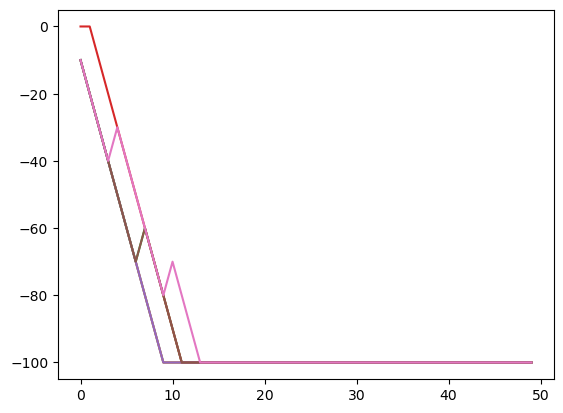

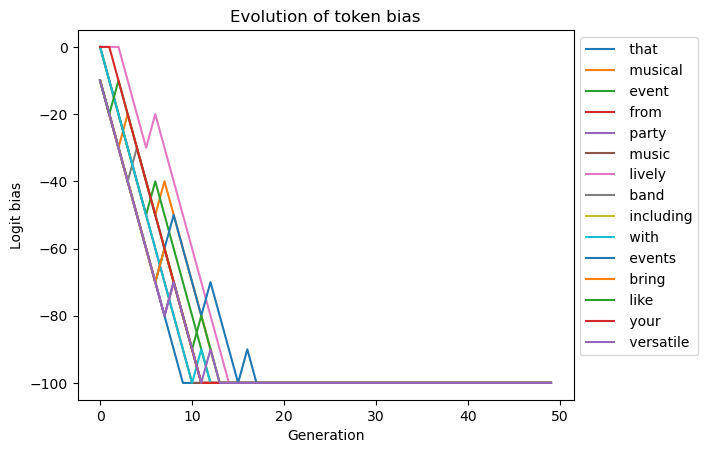

In [ ]:
top_bias = sorted(logit_bias_hist[-1], key=logit_bias_hist[-1].get, reverse=True)[:15]

# token_bias_hist = []
for token in top_bias:
  #extract bias from each generation
  token_bias = []
  for i in range(len(logit_bias_hist)):
    if token not in logit_bias_hist[i]:
      token_bias.append(0)
    else:
      token_bias.append(max(logit_bias_hist[i][token]*(-10), -100))
  
  # token_bias_hist.append({token:token_bias})

  token_name = encoding.decode_single_token_bytes(token).decode("utf-8")

  plt.plot(token_bias, label=token_name)

# Add a legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

# Set the title and labels
plt.title('Evolution of token bias')
plt.xlabel('Generation')
plt.ylabel('Logit bias')

# Show the plot
plt.show()

## Prompt variation

### Data order and presence/modification

- reorder prompt
- shuffle data in genres and events

In [ ]:
# ######### Uncomment if you wish to rerun the base test
# ResultsDF_tmp, errors = promptVarTest(task1_para, 'Shuffle-GPT4', model = 'gpt-4-1106-preview', evalModel = 'gpt-4-1106-preview')
# ResultsDF = pd.concat([ResultsDF, ResultsDF_tmp], ignore_index=True)
# print(errors)
# ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

In [ ]:
testShuffle = ResultsDF[ResultsDF.Experiment == "Shuffle-GPT4"].explode('Parameters')
testShuffle['Instance'] = testShuffle['Parameters'].apply(lambda x: int(x['Rand']) if isinstance(x, dict) else None)

# Define the maximum values for each column
max_values = {'Geval_eng': 5, 'Geval_flu': 3, 'Geval_nat': 3, 'Geval_inf': 4, 'Geval_qua': 5}
min_val = 0

# Apply the normalization
for col in ['Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'Geval_qua']:
    testShuffle[col] = (testShuffle[col]-min_val) / (max_values[col]-min_val)

styled = (testShuffle.groupby(['Instance'])[['Geval_eng','Geval_flu','Geval_nat','Geval_inf', 'Geval_qua','OverallScore']] #TTR left out
 .apply(lambda x: x.mean()) #can remove values of -1 [x >= 0]
 .style.background_gradient(cmap='viridis', vmin=0.6, vmax=1) #, vmin=0, vmax=1
)

# Convert the styled DataFrame to an HTML string
html = styled.to_html(table_attributes="border=3px")

# Write the HTML string to a file
with open(savepath + '/Output/ShuffleTestGPT4.html', 'w') as f:
    f.write(html)
#TODO: convert to png/vectorfile or other

styled

In [ ]:
testShuffle_pivot = testShuffle.pivot(index='f_key', columns='Instance', values='Answer')
testShuffle_pivot

Instance                                                                  0  \
f_key                                                                         
bandwarning               ⚠️ Band WARNING: Your Ultimate Event Energizer...   
djdenki                   Introducing DJ Denki – Röthlein's electrifying...   
djpartybombe2             Introducing DJ PARTYBOMBE – Friedberg's premie...   
djsoundbar                Nestled in the heart of the idyllic Bavarian s...   
entprimalivepoploungedan  Hailing from the picturesque heart of Kempten,...   
intakt                    Introducing Intakt – Biberbach's dynamic ensem...   
livehouse                 Embark on a sonic adventure with LIVE HOUSE, D...   
martyhisrockincomets      Get ready to be swept off your feet by the ele...   
n8vision                  Set the stage for an unforgettable entertainme...   
troublemakersriot         Delve into the high-energy world of Troublemak...   

Instance                                                                  1  \
f_key                                                                         
bandwarning               Immerse yourself in the vibrant energy of Band...   
djdenki                   Embark on an electrifying musical journey with...   
djpartybombe2             Nestled in the heart of Friedberg, DJ PARTYBOM...   
djsoundbar                Get ready to have your spirits lifted and your...   
entprimalivepoploungedan  Entprima Live | Pop Lounge Dan is a vibrant an...   
intakt                    Step into the vibrant world of Intakt, Biberba...   
livehouse                 Introducing LIVE HOUSE, the quintessential mus...   
martyhisrockincomets      Ladies and gentlemen, get ready to be transpor...   
n8vision                  Get ready to elevate your event with the elect...   
troublemakersriot         Get ready to kick up some dust and let loose w...   

Instance                                                                  2  
f_key                                                                        
bandwarning               Energize your event with an electrifying perfo...  
djdenki                   Introducing DJ Denki, Röthlein's premier DJ ac...  
djpartybombe2             Introducing DJ PARTYBOMBE, Friedberg's premier...  
djsoundbar                Introducing DJ Soundbär, the ultimate musical ...  
entprimalivepoploungedan  Immerse yourself in the enthralling rhythms an...  
intakt                    Introducing "Intakt" – your premier musical se...  
livehouse                 Based in the vibrant city of Düsseldorf, LIVE ...  
martyhisrockincomets      Transport your guests to a timeless era of foo...  
n8vision                  Introducing N8Vision, your quintessential live...  
troublemakersriot         Ignite your event with the electrifying sounds...

In [ ]:
matrix, mean = evaluation.jaccard_sim_score(testShuffle, 'Shuffle-GPT4', n={3,4})
print(mean)
#print(matrix)

0.005773457184635453


In [ ]:
SimText = evaluation.inspectSimMatrix(matrix, testShuffle, top=15)
#evaluation.highlightNgram()
SimText
#SimText = SimText[SimText.f_key1 == SimText.f_key2].reset_index(drop=True)

f_key1  \
0   entprimalivepoploungedan   
1       martyhisrockincomets   
2   entprimalivepoploungedan   
3                 djsoundbar   
4                   n8vision   
5                 djsoundbar   
6   entprimalivepoploungedan   
7   entprimalivepoploungedan   
8   entprimalivepoploungedan   
9                     intakt   
10               bandwarning   
11                djsoundbar   
12      martyhisrockincomets   
13                djsoundbar   
14      martyhisrockincomets   

                                              Answer1  \
0   Immerse yourself in the enthralling rhythms an...   
1   Get ready to be swept off your feet by the ele...   
2   Entprima Live | Pop Lounge Dan is a vibrant an...   
3   Nestled in the heart of the idyllic Bavarian s...   
4   Get ready to elevate your event with the elect...   
5   Nestled in the heart of the idyllic Bavarian s...   
6   Entprima Live | Pop Lounge Dan is a vibrant an...   
7   Entprima Live | Pop Lounge Dan is a vibrant an...   
8   Immerse yourself in the enthralling rhythms an...   
9   Introducing Intakt – Biberbach's dynamic ensem...   
10  ⚠️ Band WARNING: Your Ultimate Event Energizer...   
11  Nestled in the heart of the idyllic Bavarian s...   
12  Ladies and gentlemen, get ready to be transpor...   
13  Nestled in the heart of the idyllic Bavarian s...   
14  Get ready to be swept off your feet by the ele...   

                      f_key2  \
0                 djsoundbar   
1       martyhisrockincomets   
2   entprimalivepoploungedan   
3                 djsoundbar   
4                   n8vision   
5                 djsoundbar   
6                 djsoundbar   
7                    djdenki   
8                 djsoundbar   
9                     intakt   
10               bandwarning   
11                   djdenki   
12      martyhisrockincomets   
13               bandwarning   
14      martyhisrockincomets   

                                              Answer2     Score  
0   Nestled in the heart of the idyllic Bavarian s...  0.042365  
1   Ladies and gentlemen, get ready to be transpor...  0.041160  
2   Immerse yourself in the enthralling rhythms an...  0.036238  
3   Get ready to have your spirits lifted and your...  0.028846  
4   Introducing N8Vision, your quintessential live...  0.028143  
5   Introducing DJ Soundbär, the ultimate musical ...  0.025352  
6   Nestled in the heart of the idyllic Bavarian s...  0.025239  
7   Introducing DJ Denki – Röthlein's electrifying...  0.023622  
8   Get ready to have your spirits lifted and your...  0.022147  
9   Step into the vibrant world of Intakt, Biberba...  0.019763  
10  Immerse yourself in the vibrant energy of Band...  0.018851  
11  Introducing DJ Denki, Röthlein's premier DJ ac...  0.018584  
12  Transport your guests to a timeless era of foo...  0.018538  
13  ⚠️ Band WARNING: Your Ultimate Event Energizer...  0.018382  
14  Transport your guests to a timeless era of foo...  0.017653

In [ ]:
row = 0

print("Score: " + str(SimText.loc[row,'Score']))
evaluation.highlightNgram(SimText.loc[row,'Answer1'], SimText.loc[row,'Answer2'], max_n=4)

Score: 0.04236540158870256
n = 2
Immerse yourself in the enthralling rhythms and sublime melodies of Entprima Live Pop Lounge Dan Kempten's premier music act, perfect for any event seeking that touch of auditory elegance and excitement. Whether it's the bespoke ambiance of a corporate event, the effervescent vibe of a summer party, the dynamic atmosphere of a city festival or gala, the sanctified aura of a church gathering, the heartfelt emotions of a wedding party, the electric energy of a concert, the anticipatory joy of a wedding or wedding eve, the buzzing milieu of a fairground, the festive cheer of a christmas party, the sacred celebration of a baptism, the pulsating night at a club, the boundless freedom of an open-air event, the personal commemoration of a birthday bash, the somber respectfulness of a funeral, or the intense revelry of a club festival, Entprima Live Pop Lounge Dan transcends the ordinary and elevates your event into an unforgettable experience. Our repertoire e

In [ ]:
for i in range(len(testShuffle[testShuffle.f_key == 'djsoundbar'])):
  print(testShuffle[testShuffle.f_key == 'djsoundbar']['Answer'].iloc[i])
  print("\n\n")

Nestled in the heart of the idyllic Bavarian spa town of Bad Reichenhall, DJ Soundbär is the lifeblood of every festivity, a master at weaving the sonic tapestry that turns any event into an unforgettable experience. As the moniker suggests, DJ Soundbär offers a robust selection of music, encompassing the vibrant beats of party anthems, the heartfelt strums of country tunes, the soothing harmonies of light and lounge music, as well as the rich traditions found within folk music.

Renowned for his versatility and the ability to read the room, DJ Soundbär is the consummate professional for a wide array of events. Whether it's the romantic ambiance of a wedding party, the joyous celebration of a birthday, the rhythmic allure of a club festival, the serene dedication of a baptism, the festive cheer of a Christmas party, the formal signature of a corporate event, the laid-back vibes of a summer party, the pulsating energy of a club night, the communal spirit of a city festival, or the nosta

In [ ]:
task1_para
task1_div
#TODO: Analyze

f_name                       f_key  \
2                     The Letters                  theletters   
23                    Tromposaund                 tromposaund   
32                        mix2max                     mix2max   
34       Partyband-Non Plus Ultra      partyband-nonplusultra   
37                        Luckies                     luckies   
39                  TAKE IT EASY                   takeiteasy   
63                        Airplay                     airplay   
65               Undercover Lover             undercoverlover   
67                         Intakt                      intakt   
68                      TOP SOUND                   topsound2   
72          The Roaring Zucchinis         theroaringzucchinis   
81                The Violet Band               thevioletband   
83                Connection Five              connectionfive   
85       Pianissimo-Die Eventband     pianissimo-dieeventband   
89                BayernLive-Band             bayernlive-band   
94                     Atlas Cube                   atlascube   
99                 Danny´s Angels                dannysangels   
107                 Bavaria Sound                bavariasound   
108                    HAPPY HOUR                   happyhour   
110                       Kubus M                      kubusm   
121                Lino & Friends                 linofriends   
156  Alleinunterhalter Peter Gent  alleinunterhalterpetergent   
157                   Daisy Ultra                  daisyultra   
159           Partyband Sappralot          partybandsappralot   
168                LOOPS Liveband               loopsliveband   
181                 Stephan Worbs                stephanworbs   
182           RotzFrech Partyband          rotzfrechpartyband   
216                  Band WARNING                 bandwarning   
217           The Swinging Jangos           theswingingjangos   
222                         KOANA                       koana   
232                   WO IST ROSI                   woistrosi   
233                      Zwoastoa                    zwoastoa   
239           MUSIKDUO WIRsindWIR          musikduowirsindwir   
245                     THE ROSES                    theroses   
247               Hühnerbach Musi              huhnerbachmusi   
271                      N8Vision                    n8vision   
274                       SUPPORT                     support   
291              de 5 blousad'n 6                de5blousadn6   
308    Marty & his Rockin' Comets        martyhisrockincomets   
309               Woodsidejumpers             woodsidejumpers   
312                        Quincy                      quincy   
319                       BaXtage                     baxtage   
320                 Got the Beat                   gotthebeat   
345                   Brass Tacks                  brasstacks   
347           Troublemaker's Riot           troublemakersriot   
352               Happy Bavarians              happybavarians   
381          Dinner- und Barmusik          dinner-undbarmusik   
383                     Stingrays                   stingrays   
393                       BigBeat                     bigbeat   
404                    KROHN BAND                  krohnband2   

                                         f_description    f_distance  \
2    Wir machen Ihr Fest zu einem unvergessenem Erl...  1.100000e+02   
23   Tromposaund ist eine bayerische Musikgruppe au...  5.000000e+02   
32   WIR MACHEN LIVEMUSIK. 100% SHOWFREI. Was ist L...  4.000000e+02   
34   Rock - Pop - Schlager - Spass Handgemachte gut...  6.000000e+01   
37   Wir bieten Party-, Stimmungs- und Tanzmusik.\r...  2.000000e+02   
39   âTake it easyâ ! Die Band, die bereits meh...  1.000000e+02   
63   Sie planen eine Veranstaltung und suchen eine ...  1.000000e+03   
65   5 leidenschaftliche Musiker aus München haben ...  2.000000e+02   
67   Feste soll man feiern wie sie fallen. Ein stil...  7.00000

### Alternative instructions

Alternative formulations at the beginning or ending.\
Could be adjectives or incentives for the model to generate diverse content

In [ ]:
######### Uncomment if you wish to rerun the base test
# ResultsDF_tmp, errors = altInsTest(task1_para, 'AltIns-GPT4', model = 'gpt-4-1106-preview', evalModel = 'gpt-4-1106-preview')
# ResultsDF = pd.concat([ResultsDF, ResultsDF_tmp], ignore_index=True)
# print(errors)
# ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

In [ ]:
testAltIns = ResultsDF[ResultsDF.Experiment == "AltIns-GPT4"].explode('Parameters')
testAltIns['Instance'] = testAltIns['Parameters'].apply(lambda x: int(x['Rand']) if isinstance(x, dict) else None)

# Define the maximum values for each column
max_values = {'Geval_eng': 5, 'Geval_flu': 3, 'Geval_nat': 3, 'Geval_inf': 4, 'Geval_qua': 5}
min_val = 0

# Apply the normalization
for col in ['Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'Geval_qua']:
    testAltIns[col] = (testAltIns[col]-min_val) / (max_values[col]-min_val)

styled = (testAltIns.groupby(['Instance'])[['Geval_eng','Geval_flu','Geval_nat','Geval_inf', 'Geval_qua','OverallScore']] #TTR left out
 .apply(lambda x: x.mean()) #can remove values of -1 [x >= 0]
 .style.background_gradient(cmap='viridis', vmin=0, vmax=1) #, vmin=0, vmax=1
)

# Convert the styled DataFrame to an HTML string
html = styled.to_html(table_attributes="border=3px")

# Write the HTML string to a file
with open(savepath + '/Output/AltInsTestGPT4.html', 'w') as f:
    f.write(html)
#TODO: convert to png/vectorfile or other

styled


In [ ]:
# Find the index of the row with the lowest 'OverallScore' or 'Geval_qua'
worst_index = testAltIns[['OverallScore', 'Geval_qua']].mean(axis=1).idxmin()

# Get the worst description
worst_description = testAltIns.loc[worst_index, 'Answer']

print(worst_description)

Marty & his Rockin' Comets – Hailing from the vibrant heart of München, these electrifying performers have been setting stages ablaze with their dynamic infusion of rock 'n' roll, swing, and blues. Imagine the magnetic energy of the '50s and '60s, wrapped up in a contemporary package that's just as irresistible now as it was then.

As a versatile ensemble, Marty & his Rockin' Comets are the perfect highlight for any occasion. Whether you're looking to add that extra flair to an open-air spectacle, bring down the house at a city festival, or get the crowd jiving at a summer party, this band knows exactly how to cater to the mood. And when it comes to galas, who better to inject sophistication with pizzazz, ensuring your guests are shimmying throughout the evening?

Weddings come alive with their melodies as Marty & his Rockin' Comets craft the perfect backdrop for love and celebration, ensuring a wedding party that's talked about for years to come. They seamlessly transition the ambianc

In [ ]:
testAltIns_pivot = testAltIns.pivot(index='f_key', columns='Instance', values='Answer')
testAltIns_pivot

Instance                                                                  0  \
f_key                                                                         
bandwarning               Introducing Band WARNING – your ultimate sonic...   
djdenki                   Introducing DJ Denki, Röthlein's electrifying ...   
djpartybombe2             Elevate your event with the exhilarating energ...   
djsoundbar                Elevating every event with an irresistible ble...   
entprimalivepoploungedan  Get ready to elevate your event with the versa...   
intakt                    Bring an irresistible groove to your next even...   
livehouse                 Elevate your event with the effervescent sound...   
martyhisrockincomets      Introducing Marty & his Rockin' Comets, Munich...   
n8vision                  Introducing N8Vision, Dingolfing's premier liv...   
troublemakersriot         Crank up the volume and brace for impact, beca...   

Instance                                                                  1  \
f_key                                                                         
bandwarning               **WARNING: The Quintessential Vibe for Every O...   
djdenki                   Elevate your event's ambiance with the electri...   
djpartybombe2             Unleash the Ultimate Celebration with DJ PARTY...   
djsoundbar                Introducing DJ Soundbär, the ultimate sound ma...   
entprimalivepoploungedan  Introducing **Entprima Live | Pop Lounge Dan**...   
intakt                    Introducing Intakt, your premier live music ex...   
livehouse                 Introducing LIVE HOUSE—Düsseldorf's premier mu...   
martyhisrockincomets      Introducing Marty & His Rockin' Comets – Münch...   
n8vision                  Introducing N8Vision, Dingolfing's premier liv...   
troublemakersriot         Unleash the raw energy of Munich's own Trouble...   

Instance                                                                  2  
f_key                                                                        
bandwarning               Hailing from the vibrant heart of Dingolfing, ...  
djdenki                   Elevate your event's energy with DJ Denki, Röt...  
djpartybombe2             Introducing DJ PARTYBOMBE, your premier choice...  
djsoundbar                Introducing DJ Soundbär—an electrifying musica...  
entprimalivepoploungedan  Entprima Live | Pop Lounge Dan hails from the ...  
intakt                    Looking to set the perfect mood for your weddi...  
livehouse                 Infuse your event with the unstoppable energy ...  
martyhisrockincomets      Marty & his Rockin' Comets – Hailing from the ...  
n8vision                  Introducing N8Vision, Dingolfing's premier ban...  
troublemakersriot         Unleash the raw energy of the blues, the heart...

In [ ]:
matrix, mean = evaluation.jaccard_sim_score(testAltIns, 'AltIns-GPT4', n={3,4})
print(mean)
#print(matrix)

0.004176047128251424


In [ ]:
SimText = evaluation.inspectSimMatrix(matrix, testAltIns, top=15)
#e
# valuation.highlightNgram()
SimText
#SimText = SimText[SimText.f_key1 == SimText.f_key2].reset_index(drop=True)

f_key1  \
0                     intakt   
1          troublemakersriot   
2                    djdenki   
3   entprimalivepoploungedan   
4       martyhisrockincomets   
5                bandwarning   
6                bandwarning   
7                  livehouse   
8                 djsoundbar   
9                bandwarning   
10  entprimalivepoploungedan   
11  entprimalivepoploungedan   
12                  n8vision   
13                  n8vision   
14                  n8vision   

                                              Answer1                f_key2  \
0   Introducing Intakt, your premier live music ex...                intakt   
1   Unleash the raw energy of Munich's own Trouble...     troublemakersriot   
2   Introducing DJ Denki, Röthlein's electrifying ...               djdenki   
3   Get ready to elevate your event with the versa...            djsoundbar   
4   Introducing Marty & his Rockin' Comets, Munich...  martyhisrockincomets   
5   **WARNING: The Quintessential Vibe for Every O...             livehouse   
6   Hailing from the vibrant heart of Dingolfing, ...              n8vision   
7   Elevate your event with the effervescent sound...             livehouse   
8   Elevating every event with an irresistible ble...             livehouse   
9   Hailing from the vibrant heart of Dingolfing, ...             livehouse   
10  Get ready to elevate your event with the versa...               djdenki   
11  Entprima Live | Pop Lounge Dan hails from the ...                intakt   
12  Introducing N8Vision, Dingolfing's premier liv...  martyhisrockincomets   
13  Introducing N8Vision, Dingolfing's premier liv...              n8vision   
14  Introducing N8Vision, Dingolfing's premier ban...  martyhisrockincomets   

                                              Answer2     Score  
0   Looking to set the perfect mood for your weddi...  0.023810  
1   Unleash the raw energy of the blues, the heart...  0.021277  
2   Elevate your event's energy with DJ Denki, Röt...  0.020438  
3   Introducing DJ Soundbär—an electrifying musica...  0.018559  
4   Marty & his Rockin' Comets – Hailing from the ...  0.018405  
5   Elevate your event with the effervescent sound...  0.017857  
6   Introducing N8Vision, Dingolfing's premier liv...  0.017403  
7   Infuse your event with the unstoppable energy ...  0.016367  
8   Elevate your event with the effervescent sound...  0.015046  
9   Elevate your event with the effervescent sound...  0.014516  
10  Elevate your event's ambiance with the electri...  0.014461  
11  Looking to set the perfect mood for your weddi...  0.014374  
12  Introducing Marty & His Rockin' Comets – Münch...  0.013966  
13  Introducing N8Vision, Dingolfing's premier ban...  0.013308  
14  Marty & his Rockin' Comets – Hailing from the ...  0.012809

In [ ]:
row = 0

print("Score: " + str(SimText.loc[row,'Score']))
evaluation.highlightNgram(SimText.loc[row,'Answer1'], SimText.loc[row,'Answer2'], max_n=2)

Score: 0.023809523809523808
n = 2
Introducing Intakt, your premier live music experience hailing from the picturesque town of Biberbach. With our vibrant blend of genres, we infuse every performance with the infectious energy of pop, the irresistible groove of dance music, the chic ambiance of lounge tunes, as well as the soulful rhythms of funk and the sophisticated improvisations of jazz. Whether you're stepping into the magical threshold of matrimony and searching for the ultimate soundtrack to your wedding party, seeking to elevate the atmosphere at a bustling fairground, or aiming to impress at a high-profile corporate event, Intakt is the ensemble of choice. Our diverse musical selection caters to a variety of occasions, promising to captivate and charm audiences of all ages and tastes. Dressed to impress and skilled at engaging with our listeners, we pride ourselves on creating unforgettable musical experiences. Let Intakt take your event to the next level, ensuring that the sou

## Few shot learning

We have a repository of existing banddescriptions with good ratings, now use them in the prompt (verify length)

In [ ]:
# ######### Uncomment if you wish to rerun the top_p test
# ResultsDF_tmp, errors = fewShotTest(task1_para, experiment = 'Fewshot-GPT4', model='gpt-4-1106-preview', evalModel='gpt-3.5-turbo-1106')
# ResultsDF = pd.concat([ResultsDF, ResultsDF_tmp], ignore_index=True)
# #print(errors)
# ResultsDF.to_pickle(savepath+"/Datasets/ResultsDF.pkl")

In [ ]:
testFewshot = ResultsDF[ResultsDF.Experiment == "Fewshot-GPT4"].explode('Parameters')
testFewshot['Instance'] = testFewshot['Parameters'].apply(lambda x: int(x['Rand']) if isinstance(x, dict) else None)

# Define the maximum values for each column
max_values = {'Geval_eng': 5, 'Geval_flu': 3, 'Geval_nat': 3, 'Geval_inf': 4, 'Geval_qua': 5}
min_val = 0

# Apply the normalization
for col in ['Geval_eng', 'Geval_flu', 'Geval_nat', 'Geval_inf', 'Geval_qua']:
    testFewshot[col] = (testFewshot[col]-min_val) / (max_values[col]-min_val)

styled = (testFewshot.groupby(['Instance'])[['Geval_eng','Geval_flu','Geval_nat','Geval_inf', 'Geval_qua','OverallScore']] #TTR left out
 .apply(lambda x: x.mean()) #can remove values of -1 [x >= 0]
 .style.background_gradient(cmap='viridis', vmin=0., vmax=1) #, vmin=0, vmax=1
)

# Convert the styled DataFrame to an HTML string
html = styled.to_html(table_attributes="border=3px")

# Write the HTML string to a file
with open(savepath + '/Output/FewshotTestGPT4.html', 'w') as f:
    f.write(html)
#TODO: convert to png/vectorfile or other

styled

In [ ]:
# Find the index of the row with the lowest 'OverallScore' or 'Geval_qua'
worst_index = testFewshot[['OverallScore', 'Geval_qua']].mean(axis=1).idxmin()

# Get the worst description
worst_description = testFewshot.loc[worst_index, 'Answer']

print(worst_description)

Introducing DJ PARTYBOMBE, the ultimate musical dynamo hailing from the heart of Friedberg, ready to deliver an electrifying soundtrack for every occasion you can think of! Whether you're marking a cherished baptism, throwing the birthday bash of the century, reveling in the frenetic joys of carnival, getting festive at a Christmas party, or celebrating love at a wedding – DJ PARTYBOMBE is your go-to disc jockey and entertainer.

DJ PARTYBOMBE's vast repertoire spans across a dazzling array of genres. Feel the pulse of country's rustic charm, lose yourself in the rhythmic ecstasy of dance music, experience the warm embrace of folk tunes, elevate your gala with sophisticated light music, or let loose as party anthems flood the airwaves. This DJ is adept in tailoring the music to suit the spirit of your event, capable of setting the mood for a dazzling city festival, a vibrant club festival, a professional corporate event, the lively buzz of a fairground, and even providing a respectful,

In [ ]:
testFewshot_pivot = testFewshot.pivot(index='f_key', columns='Instance', values='Answer')
testFewshot_pivot

Instance                                                                  0  \
f_key                                                                         
bandwarning               Ignite the energy and spirit of celebration at...   
djdenki                   **DJ Denki - Electrifying Your Events with Vib...   
djpartybombe2             Invigorate your event with an explosion of son...   
djsoundbar                Name: DJ Soundbär\nLocation: Bad Reichenhall, ...   
entprimalivepoploungedan  Step into the vibrant world of Entprima Live |...   
intakt                    Introducing Intakt, the vibrant and versatile ...   
livehouse                 Immerse yourself in a musical oasis as "LIVE H...   
martyhisrockincomets      Get ready to be swept off your feet with the e...   
n8vision                  Introducing N8Vision, your ultimate musical se...   
troublemakersriot         Get ready to stir up some excitement with Trou...   

Instance                                                                  1  \
f_key                                                                         
bandwarning               Ignite your event with the electrifying tunes ...   
djdenki                   Introducing DJ Denki, Röthlein's electrifying ...   
djpartybombe2             Unleash the ultimate celebration soundtrack wi...   
djsoundbar                Introducing DJ Soundbär, your go-to entertainm...   
entprimalivepoploungedan  Entprima Live | Pop Lounge Dan is the electrif...   
intakt                    Introducing Intakt: Biberbach's premier ensemb...   
livehouse                 Immerse yourself in the pulsating rhythms and ...   
martyhisrockincomets      Title: Marty & His Rocking Comets: Swinging Bl...   
n8vision                  Introducing N8Vision, the dynamic ensemble hai...   
troublemakersriot         Introducing Troublemaker's Riot – your premier...   

Instance                                                                  2  
f_key                                                                        
bandwarning               Step into the electrifying soundscape of WARNI...  
djdenki                   Introducing the vibrant and versatile beats of...  
djpartybombe2             Introducing DJ PARTYBOMBE, the ultimate musica...  
djsoundbar                Introducing DJ Soundbär, Bad Reichenhall's pre...  
entprimalivepoploungedan  Introducing Entprima Live, also known as Pop L...  
intakt                    Introducing Intakt, the vibrant heartbeat of B...  
livehouse                 LIVE HOUSE: The Ultimate Fusion of Bands and D...  
martyhisrockincomets      Step back in time and ignite your event with t...  
n8vision                  Introducing N8Vision, the quintessential energ...  
troublemakersriot         Get ready to ignite your event with the electr...

In [ ]:
matrix, mean = evaluation.jaccard_sim_score(testFewshot, 'Fewshot-GPT4', n={3,4})
print(mean)
#print(matrix)

0.00443140550341172


In [ ]:
SimText = evaluation.inspectSimMatrix(matrix, testFewshot, top=15)
#evaluation.highlightNgram()
SimText
#SimText = SimText[SimText.f_key1 == SimText.f_key2].reset_index(drop=True)

f_key1  \
0   entprimalivepoploungedan   
1                 djsoundbar   
2       martyhisrockincomets   
3                    djdenki   
4                  livehouse   
5                    djdenki   
6   entprimalivepoploungedan   
7                  livehouse   
8              djpartybombe2   
9   entprimalivepoploungedan   
10  entprimalivepoploungedan   
11      martyhisrockincomets   
12  entprimalivepoploungedan   
13                djsoundbar   
14               bandwarning   

                                              Answer1  \
0   Step into the vibrant world of Entprima Live |...   
1   Introducing DJ Soundbär, Bad Reichenhall's pre...   
2   Get ready to be swept off your feet with the e...   
3   Introducing DJ Denki, Röthlein's electrifying ...   
4   Immerse yourself in a musical oasis as "LIVE H...   
5   Introducing the vibrant and versatile beats of...   
6   Step into the vibrant world of Entprima Live |...   
7   Immerse yourself in a musical oasis as "LIVE H...   
8   Invigorate your event with an explosion of son...   
9   Step into the vibrant world of Entprima Live |...   
10  Entprima Live | Pop Lounge Dan is the electrif...   
11  Get ready to be swept off your feet with the e...   
12  Step into the vibrant world of Entprima Live |...   
13  Introducing DJ Soundbär, Bad Reichenhall's pre...   
14  Ignite the energy and spirit of celebration at...   

                      f_key2  \
0              djpartybombe2   
1              djpartybombe2   
2       martyhisrockincomets   
3                    djdenki   
4              djpartybombe2   
5              djpartybombe2   
6              djpartybombe2   
7                  livehouse   
8              djpartybombe2   
9   entprimalivepoploungedan   
10             djpartybombe2   
11      martyhisrockincomets   
12                   djdenki   
13                 livehouse   
14               bandwarning   

                                              Answer2     Score  
0   Unleash the ultimate celebration soundtrack wi...  0.029864  
1   Invigorate your event with an explosion of son...  0.029575  
2   Title: Marty & His Rocking Comets: Swinging Bl...  0.024762  
3   Introducing the vibrant and versatile beats of...  0.023377  
4   Invigorate your event with an explosion of son...  0.023277  
5   Unleash the ultimate celebration soundtrack wi...  0.023050  
6   Invigorate your event with an explosion of son...  0.022302  
7   LIVE HOUSE: The Ultimate Fusion of Bands and D...  0.021570  
8   Unleash the ultimate celebration soundtrack wi...  0.020755  
9   Entprima Live | Pop Lounge Dan is the electrif...  0.020725  
10  Unleash the ultimate celebration soundtrack wi...  0.020073  
11  Step back in time and ignite your event with t...  0.018727  
12  Introducing the vibrant and versatile beats of...  0.018395  
13  Immerse yourself in a musical oasis as "LIVE H...  0.017437  
14  Ignite your event with the electrifying tunes ...  0.016821

In [ ]:
row = 0

print("Score: " + str(SimText.loc[row,'Score']))
evaluation.highlightNgram(SimText.loc[row,'Answer1'], SimText.loc[row,'Answer2'], max_n=2)

Score: 0.02986425339366516
n = 2
Step into the vibrant world of Entprima Live Pop Lounge Dan, where the pulse of Kempten’s music scene comes alive in a symphony of dance, lounge, party, and pop rhythms. As a versatile ensemble adept at both commanding the stage as a band and electrifying the room as a DJ, Entprima Live transcends traditional entertainment boundaries to deliver a comprehensive musical experience. Perfectly at home across a vast array of events from the sacred ambiance of a baptism, the joyful revelry of a birthday, the festive spirit of a Christmas party, and the solemn reflection during a funeral, to the grandeur of gala evenings, and the organic vibe of city festivals and club events Entprima Live is the sonic glue that binds moments to memories. With a repertoire that's as expansive as their travel radius, Entprima Live brings their dynamic performance to life within a 500km radius of Kempten, encompassing cities such as Frankfurt, Zurich, Stuttgart, and Munich, amon

# Results, condensed

In [34]:
ResultsDF = ResultsDF.replace({col: {0: np.nan, -1: np.nan} for col in ResultsDF.filter(like='Geval').columns})

Series([], dtype: float64)

In [294]:
ResultsDF.Experiment.unique()

array(['Original', 'Original_Quality', 'Temp-GPT3.5-1106',
       'Base-GPT-3.5-1106', 'Base-GPT-4-1106', 'Temp-GPT4', 'Topp-GPT3.5',
       'Shuffle-GPT4', 'Shuffle-GPT3.5', 'Fewshot-GPT3.5', 'Fewshot-GPT4',
       'AltIns-GPT3.5', 'AltIns-GPT4', 'Original_para', 'Original_div',
       'Base-Llama2-13b-chat', 'Base-Para-GPT3.5', 'Base-Para-GPT4',
       'T5-div', 'T5-div-2', 'logitBias-GPT3.5', 'LogitBias-GPT4',
       'Shuffle-Llama2-13b-chat', 'AltIns-Llama2-13b-chat',
       'adaptlogitBias-GPT3.5', 'AdaptLogitBias-GPT4', 'OriginalDiv_en',
       'FlanT5-div-2', 'AltInsDiv-GPT3.5', 'AltInsDiv-GPT4',
       'FewshotDiv-GPT3.5', 'FewshotDiv-GPT4', 'ShuffleDiv-GPT3.5',
       'ShuffleDiv-GPT4', 'Base-Triplets-GPT3.5'], dtype=object)

## RQ 1

In [68]:
ResultsDF

f_key           Experiment  \
Experiment                                                              
AdaptLogitBias-GPT4 1744              theletters  AdaptLogitBias-GPT4   
                    1745             tromposaund  AdaptLogitBias-GPT4   
                    1746                 mix2max  AdaptLogitBias-GPT4   
                    1747  partyband-nonplusultra  AdaptLogitBias-GPT4   
                    1748                 luckies  AdaptLogitBias-GPT4   
...                                          ...                  ...   
logitBias-GPT3.5    1539          happybavarians     logitBias-GPT3.5   
                    1540      dinner-undbarmusik     logitBias-GPT3.5   
                    1541               stingrays     logitBias-GPT3.5   
                    1542                 bigbeat     logitBias-GPT3.5   
                    1543              krohnband2     logitBias-GPT3.5   

                                       Model  \
Experiment                                     
AdaptLogitBias-GPT4 1744  gpt-4-1106-preview   
                    1745  gpt-4-1106-preview   
                    1746  gpt-4-1106-preview   
                    1747  gpt-4-1106-preview   
                    1748  gpt-4-1106-preview   
...                                      ...   
logitBias-GPT3.5    1539  gpt-3.5-turbo-1106   
                    1540  gpt-3.5-turbo-1106   
                    1541  gpt-3.5-turbo-1106   
                    1542  gpt-3.5-turbo-1106   
                    1543  gpt-3.5-turbo-1106   

                                                                     Prompt  \
Experiment                                                                    
AdaptLogitBias-GPT4 1744  Create a captivating and comprehensive band de...   
                    1745  Create a captivating and comprehensive band de...   
                    1746  Create a captivating and comprehensive band de...   
                    1747  Create a captivating and comprehensive band de...   
                    1748  Create a captivating and comprehensive band de...   
...                                                                     ...   
logitBias-GPT3.5    1539  Create a captivating and comprehensive band de...   
                    1540  Create a captivating and comprehensive band de...   
                    1541  Create a captivating and comprehensive band de...   
                    1542  Create a captivating and comprehensive band de...   
                    1543  Create a captivating and comprehensive band de...   

                                                                     Answer  \
Experiment                                                                    
AdaptLogitBias-GPT4 1744  Welcome to the vibrant world of "The Letters,"...   
                    1745  Nestled in the heart of Holzhausen, Tromposaun...   
                    1746  Introducing mix2max, Pollenfeld's pulse-raisin...   
                    1747  Immerse yourself in the unadulterated, electri...   
                    1748  Hailing proudly and loudly out of the vibrant ...   
...                                                                     ...   
logitBias-GPT3.5    1539  The Happy Bavarians are a highly sought-after ...   
                    1540  Introducing Dinner- und Barmusik, the ultimate...   
                    1541  The Stingrays are a dynamic and electrifying f...   
                    1542  BigBeat is a highly sought-after, upbeat and p...   
                    1543  Hitting the streets and stages of the iconic a...   

                                                                 Parameters  \
Experiment                                                                    
AdaptLogitBias-GPT4 1744  [{'genpara': {'Temperature': 1.0}, 'gendata': ...   
                    1745  [{'genpara': {'Temperature': 1.0}, 'gendata': ...   
                    1746  [{'genpara': {'Temperature': 1.0}, 'gendata': ...   
                 

In [69]:
ResultsDF[['Geval_eng','Geval_flu','Geval_nat','Geval_inf','OverallScore', 'Geval_qua', 'JaccardScore']].apply(lambda x: x[x >= 0].mean())

Geval_eng       3.511788
Geval_flu       2.337306
Geval_nat       2.578025
Geval_inf       2.657235
OverallScore    0.751417
Geval_qua       3.498622
JaccardScore    0.007897
dtype: float64

In [30]:
#Relevant experiments
selection = ['Base-GPT-3.5-1106', 'Base-GPT-4-1106',
       'Original_div', 'Base-Llama2-13b-chat', 'T5-div-2', 'logitBias-GPT3.5', 'LogitBias-GPT4',
       'Shuffle-Llama2-13b-chat', 'AltIns-Llama2-13b-chat',
       'adaptlogitBias-GPT3.5', 'AdaptLogitBias-GPT4', 'OriginalDiv_en',
       'FlanT5-div-2', 'AltInsDiv-GPT3.5', 'AltInsDiv-GPT4',
       'FewshotDiv-GPT3.5', 'FewshotDiv-GPT4', 'ShuffleDiv-GPT3.5',
       'ShuffleDiv-GPT4', 'Base-Triplets-GPT3.5']

#Define additional columns
def add_jaccard_score(group):
    matrix, mean = evaluation.jaccard_sim_score(ResultsDF, group.name, n={3,4})
    return pd.Series({'JaccardScore': mean})

def add_avg_length(group):
    return pd.Series({'AvgLength': np.mean(group['Answer'].apply(lambda x: len(x)))})

def add_model(group):
    return pd.Series({'Model': group['Model'].iloc[0]})

#Prepare additional columns
jaccard_scores = ResultsDF.groupby('Experiment').apply(add_jaccard_score)
avg_length = ResultsDF.groupby('Experiment').apply(add_avg_length)
models = ResultsDF.groupby('Experiment').apply(add_model)

#main grouping
ResultsGrouped = ResultsDF.groupby(['Experiment'])[['Geval_eng','Geval_flu','Geval_nat','Geval_inf','OverallScore']].apply(lambda x: x[x >= 0].mean())

#Add additional columns
ResultsGrouped = ResultsGrouped.join(jaccard_scores)
ResultsGrouped = ResultsGrouped.join(avg_length)
ResultsGrouped = ResultsGrouped.join(models)

#Select relevant experiments
ResultsGrouped = ResultsGrouped.loc[selection]
#Sort
ResultsGrouped.sort_values(by=['JaccardScore'], ascending=False)


ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivisionError: setting to 0
ZeroDivi

Geval_eng  Geval_flu  Geval_nat  Geval_inf  \
Experiment                                                            
Base-GPT-3.5-1106         3.724947   2.916890   2.986000   2.968000   
ShuffleDiv-GPT3.5         3.964912   2.915380   2.932456   2.978684   
Base-Llama2-13b-chat      4.000053   2.943489   2.871322   2.937053   
T5-div-2                  1.280458   1.320159   1.047053   1.256947   
AltIns-Llama2-13b-chat    4.002053   2.876842   2.986534   2.979000   
Base-Triplets-GPT3.5      3.872000   2.787402   2.858246   2.907211   
Shuffle-Llama2-13b-chat   4.006000   2.969898   2.963053   2.983000   
AltInsDiv-GPT3.5          3.876000   2.933418   2.988789   2.918000   
FewshotDiv-GPT3.5         4.321500   2.577769   2.987536   3.881304   
FlanT5-div-2              2.068492   1.785631   1.533226   1.768579   
AltInsDiv-GPT4            4.021000   2.998000   2.981222   2.994000   
ShuffleDiv-GPT4           4.039000   2.933731   2.982000   3.012000   
Base-GPT-4-1106           4.008000   2.943621   2.978000   3.007000   
logitBias-GPT3.5          3.913947   2.435953   2.753789   2.903895   
adaptlogitBias-GPT3.5     3.824895   2.401370   2.608374   2.849684   
AdaptLogitBias-GPT4       4.041000   2.817941   2.856579   2.994947   
LogitBias-GPT4            3.982158   2.494817   2.628034   2.995053   
OriginalDiv_en            3.782737   2.511470   2.743047   2.689526   
Original_div              3.547421   2.485881   2.750060   2.634770   
FewshotDiv-GPT4           1.395634   1.090420   0.777690   1.771491   

                         OverallScore  JaccardScore  AvgLength  \
Experiment                                                       
Base-GPT-3.5-1106            0.863655      0.035258     530.00   
ShuffleDiv-GPT3.5            0.871733      0.025087     745.60   
Base-Llama2-13b-chat         0.868136      0.016719    1880.92   
T5-div-2                     0.339850      0.015427     609.66   
AltIns-Llama2-13b-chat       0.874905      0.014785    1329.68   
Base-Triplets-GPT3.5         0.845771      0.014192     421.12   
Shuffle-Llama2-13b-chat      0.881150      0.012283    1702.20   
AltInsDiv-GPT3.5             0.869692      0.010581     580.48   
FewshotDiv-GPT3.5            0.922432      0.006657    1024.34   
FlanT5-div-2                 0.490532      0.005261     543.58   
AltInsDiv-GPT4               0.886444      0.005123    1439.38   
ShuffleDiv-GPT4              0.883178      0.005073    1883.22   
Base-GPT-4-1106              0.881806      0.004378    1627.68   
logitBias-GPT3.5             0.809669      0.003955    1327.40   
adaptlogitBias-GPT3.5        0.786829      0.003185    1206.72   
AdaptLogitBias-GPT4          0.862111      0.001999    2222.00   
LogitBias-GPT4               0.813203      0.001914    2204.56   
OriginalDiv_en               0.795109      0.000741     901.36   
Original_div                 0.778373      0.000265     954.06   
FewshotDiv-GPT4              0.336176      0.000250    2403.14   

                                      Model  
Experiment                                   
Base-GPT-3.5-1106        gpt-3.5-turbo-1106  
ShuffleDiv-GPT3.5        gpt-3.5-turbo-1106  
Base-Llama2-13b-chat       Llama-2-13b-chat  
T5-div-2                           T5-small  
AltIns-Llama2-13b-chat     Llama-2-13b-chat  
Base-Triplets-GPT3.5     gpt-3.5-turbo-1106  
Shuffle-Llama2-13b-chat    Llama-2-13b-chat  
AltInsDiv-GPT3.5         gpt-3.5-turbo-1106  
FewshotDiv-GPT3.5        gpt-3.5-turbo-1106  
FlanT5-div-2                   Flan-t5-base  
AltInsDiv-GPT4           gpt-4-1106-preview  
ShuffleDiv-GPT4          gpt-4-1106-preview  
Base-GPT-4-1106          gpt-4-1106-preview  
logitBias-GPT3.5         gpt-3.5-turbo-1106  
adaptlogitBias-GPT3.5    gpt-3.5-turbo-1106  
AdaptLogitBias-GPT4      gpt-4-1106-preview  
LogitBias-GPT4           gpt-4-1106-preview  
OriginalDiv_en                          NaN  
Original_div                            NaN  
FewshotDiv-GPT4          gpt-4-1106-preview

In [35]:
ResultsGrouped.sort_values(by=['AvgLength'], ascending=False)

Geval_eng  Geval_flu  Geval_nat  Geval_inf  \
Experiment                                                            
FewshotDiv-GPT4           1.395634   1.090420   0.777690   1.771491   
AdaptLogitBias-GPT4       4.041000   2.817941   2.856579   2.994947   
LogitBias-GPT4            3.982158   2.494817   2.628034   2.995053   
ShuffleDiv-GPT4           4.039000   2.933731   2.982000   3.012000   
Base-Llama2-13b-chat      4.000053   2.943489   2.871322   2.937053   
Shuffle-Llama2-13b-chat   4.006000   2.969898   2.963053   2.983000   
Base-GPT-4-1106           4.008000   2.943621   2.978000   3.007000   
AltInsDiv-GPT4            4.021000   2.998000   2.981222   2.994000   
AltIns-Llama2-13b-chat    4.002053   2.876842   2.986534   2.979000   
logitBias-GPT3.5          3.913947   2.435953   2.753789   2.903895   
adaptlogitBias-GPT3.5     3.824895   2.401370   2.608374   2.849684   
FewshotDiv-GPT3.5         4.321500   2.577769   2.987536   3.881304   
Original_div              3.547421   2.485881   2.750060   2.634770   
OriginalDiv_en            3.782737   2.511470   2.743047   2.689526   
ShuffleDiv-GPT3.5         3.964912   2.915380   2.932456   2.978684   
T5-div-2                  1.280458   1.320159   1.047053   1.256947   
AltInsDiv-GPT3.5          3.876000   2.933418   2.988789   2.918000   
FlanT5-div-2              2.068492   1.785631   1.533226   1.768579   
Base-GPT-3.5-1106         3.724947   2.916890   2.986000   2.968000   
Base-Triplets-GPT3.5      3.872000   2.787402   2.858246   2.907211   

                         OverallScore  JaccardScore  AvgLength  \
Experiment                                                       
FewshotDiv-GPT4              0.336176      0.000250    2403.14   
AdaptLogitBias-GPT4          0.862111      0.001999    2222.00   
LogitBias-GPT4               0.813203      0.001914    2204.56   
ShuffleDiv-GPT4              0.883178      0.005073    1883.22   
Base-Llama2-13b-chat         0.868136      0.016719    1880.92   
Shuffle-Llama2-13b-chat      0.881150      0.012283    1702.20   
Base-GPT-4-1106              0.881806      0.004378    1627.68   
AltInsDiv-GPT4               0.886444      0.005123    1439.38   
AltIns-Llama2-13b-chat       0.874905      0.014785    1329.68   
logitBias-GPT3.5             0.809669      0.003955    1327.40   
adaptlogitBias-GPT3.5        0.786829      0.003185    1206.72   
FewshotDiv-GPT3.5            0.922432      0.006657    1024.34   
Original_div                 0.778373      0.000265     954.06   
OriginalDiv_en               0.795109      0.000741     901.36   
ShuffleDiv-GPT3.5            0.871733      0.025087     745.60   
T5-div-2                     0.339850      0.015427     609.66   
AltInsDiv-GPT3.5             0.869692      0.010581     580.48   
FlanT5-div-2                 0.490532      0.005261     543.58   
Base-GPT-3.5-1106            0.863655      0.035258     530.00   
Base-Triplets-GPT3.5         0.845771      0.014192     421.12   

                                      Model  
Experiment                                   
FewshotDiv-GPT4          gpt-4-1106-preview  
AdaptLogitBias-GPT4      gpt-4-1106-preview  
LogitBias-GPT4           gpt-4-1106-preview  
ShuffleDiv-GPT4          gpt-4-1106-preview  
Base-Llama2-13b-chat       Llama-2-13b-chat  
Shuffle-Llama2-13b-chat    Llama-2-13b-chat  
Base-GPT-4-1106          gpt-4-1106-preview  
AltInsDiv-GPT4           gpt-4-1106-preview  
AltIns-Llama2-13b-chat     Llama-2-13b-chat  
logitBias-GPT3.5         gpt-3.5-turbo-1106  
adaptlogitBias-GPT3.5    gpt-3.5-turbo-1106  
FewshotDiv-GPT3.5        gpt-3.5-turbo-1106  
Original_div                            NaN  
OriginalDiv_en                          NaN  
ShuffleDiv-GPT3.5        gpt-3.5-turbo-1106  
T5-div-2                           T5-small  
AltInsDiv-GPT3.5         gpt-3.5-turbo-1106  
FlanT5-div-2                   Flan-t5-base  
Base-GPT-3.5-1106        gpt-3.5-turbo-1106  
Base-Triplets-GPT3.5     gpt-3.5-turbo-1106

In [43]:
ResultsDF.to_csv(savepath + '/Output/ResultsDF.csv', sep=",",index=False)

In [27]:
print(ResultsDF[(ResultsDF.Experiment == "FlanT5-div-2") & (ResultsDF.f_key == "tromposaund")]['Answer'].iloc[0])

The band Tromposaund is a 5-piece formation (one woman with four men), which can also be booked as a trio. Tromposaund plays in a 5-piece line-up with drummer, bassist and keyboards. The repertoire is adapted to the musical tastes of the audience, e.g. young, young, old, with or without vocals. The repertoire is adapted to the audience with a lot of wit, charm and playful class. Tromposaund plays in a 5-piece line-up, which is booked for about 80 events a year. The band's repertoire is based in the area of blues, swing, swing and ballads. Tromposaund plays in a 5-piece line-up with drummer, bassist and keyboards. The repertoire is adapted to the musical tastes of the audience, e.g.: The jazz 


TypeError: 'value' must be an instance of str or bytes, not a float

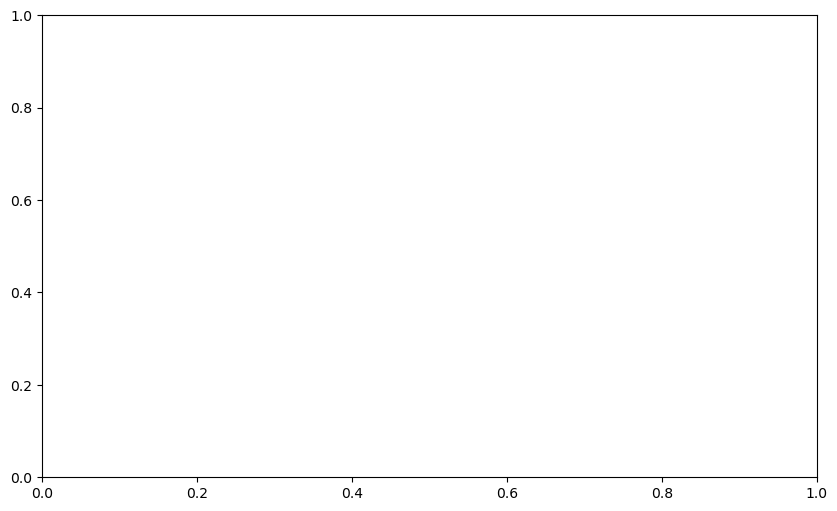

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Create a new column that combines 'Model' and 'Experiment'
ResultsGrouped['ModelExperiment'] = ResultsGrouped['Model'] + ' - ' + ResultsGrouped['Experiment']

# Create a bar plot with 'ModelExperiment' on the x-axis and 'JaccardScore' on the y-axis
plt.figure(figsize=(10,6))
bar_plot = plt.bar(ResultsGrouped['ModelExperiment'], ResultsGrouped['JaccardScore'])

# Get the unique models
models = ResultsGrouped['Model'].unique()

# Get the positions of the models in the 'ModelExperiment' column
positions = [ResultsGrouped['ModelExperiment'].tolist().index(model + ' - ' + ResultsGrouped.loc[ResultsGrouped['Model'] == model, 'Experiment'].iloc[0]) for model in models]

# Set the x-ticks and x-tick labels to the models
plt.xticks(positions, models, rotation=90)

# Set the labels and title
plt.xlabel('Model')
plt.ylabel('Jaccard Score')

# Show the plot
plt.show()

In [64]:
ResultsDF[ResultsDF.Experiment.isin(selection)].groupby(['Experiment'])[['Geval_eng','Geval_flu','Geval_nat','Geval_inf','OverallScore', 'Geval_qua']].size()

Experiment
AdaptLogitBias-GPT4        50
AltIns-Llama2-13b-chat     50
AltInsDiv-GPT3.5           50
AltInsDiv-GPT4             50
Base-GPT-3.5-1106          50
Base-GPT-4-1106            50
Base-Llama2-13b-chat       50
Base-Triplets-GPT3.5       50
FewshotDiv-GPT3.5          50
FewshotDiv-GPT4            50
FlanT5-div-2               50
LogitBias-GPT4             50
OriginalDiv_en             50
Original_div               50
Shuffle-Llama2-13b-chat    50
ShuffleDiv-GPT3.5          60
ShuffleDiv-GPT4            50
T5-div-2                   50
adaptlogitBias-GPT3.5      50
logitBias-GPT3.5           50
dtype: int64

## RQ 3

## RQ 4: Are generated texts as fluent and coherent as human-written text?

In [257]:
selection = ['Base-GPT-3.5-1106', 'Base-GPT-4-1106', 
       'Shuffle-GPT4', 'Shuffle-GPT3.5', 
       'OriginalDiv_en', 'Base-Llama2-13b-chat', 'T5-div', 'T5-div-2', 
       'logitBias-GPT3.5', 'LogitBias-GPT4',
       'Shuffle-Llama2-13b-chat', 'AltIns-Llama2-13b-chat',
       'adaptlogitBias-GPT3.5', 'AdaptLogitBias-GPT4']

columns_to_rank = ['Geval_eng','Geval_flu','Geval_nat','Geval_inf','TTR','OverallScore', 'Geval_qua']

for column in columns_to_rank:
    ResultsDF[f'{column}_Rank'] = ResultsDF[ResultsDF.Experiment.isin(selection)].groupby('f_key')[column].rank(method='min',ascending=False)

# original_div_df = ResultsDF[ResultsDF['Experiment'] == 'Original_div']

# Rank the OverallScore within each band
# ResultsDF['OverallScore_rank'] = ResultsDF.groupby('f_key')['OverallScore'].rank(ascending=False)

# Now original_div_df contains a new column 'OverallScore_rank' with the rank of OverallScore within each band

In [259]:
df

index                   f_key  Geval_flu  Geval_flu_Rank  Geval_nat  \
0      924              theletters   3.000000             1.0       2.95   
1      925             tromposaund   3.000000             1.0       3.00   
2      926                 mix2max   2.894737             6.0       3.00   
3      927  partyband-nonplusultra   3.000000             1.0       3.00   
4      928                 luckies   3.000000             1.0       3.00   
..     ...                     ...        ...             ...        ...   
625   1859          happybavarians   2.900000             7.0       2.95   
626   1860      dinner-undbarmusik   3.000000             1.0       3.00   
627   1861               stingrays   3.000000             1.0       3.00   
628   1862                 bigbeat   3.000000             1.0       3.00   
629   1863              krohnband2   2.944444             5.0       2.80   

     Geval_nat_Rank  
0               7.0  
1               1.0  
2               1.0  
3               1.0  
4               1.0  
..              ...  
625             6.0  
626             1.0  
627             1.0  
628             1.0  
629             6.0  

[630 rows x 6 columns]

In [269]:
df = ResultsDF[ResultsDF.Experiment.isin(['Base-GPT-3.5-1106'])][['f_key','Geval_flu','Geval_flu_Rank','Geval_nat','Geval_nat_Rank']].reset_index()
# Assuming `df` is your DataFrame
count_flu_rank = (df['Geval_flu'] >= 2.9).sum()
count_nat_rank = (df['Geval_nat'] >= 2.9).sum()

print(f"Count of Geval_flu_Rank == 3: {count_flu_rank}/{len(df)}, avg: {df['Geval_flu'].mean()}/3")
print(f"Count of Geval_nat_Rank == 3: {count_nat_rank}/{len(df)}, avg: {df['Geval_nat'].mean()}/3")

Count of Geval_flu_Rank == 3: 41/50, avg: 2.740890350877193/3
Count of Geval_nat_Rank == 3: 49/50, avg: 2.986/3


In [265]:
ResultsDF.Experiment.unique()

array(['Original', 'Original_Quality', 'Temp-GPT3.5-1106',
       'Base-GPT-3.5-1106', 'Base-GPT-4-1106', 'Temp-GPT4', 'Topp-GPT3.5',
       'Shuffle-GPT4', 'Shuffle-GPT3.5', 'Fewshot-GPT3.5', 'Fewshot-GPT4',
       'AltIns-GPT3.5', 'AltIns-GPT4', 'Original_para', 'Original_div',
       'Base-Llama2-13b-chat', 'Base-Para-GPT3.5', 'Base-Para-GPT4',
       'T5-div', 'T5-div-2', 'logitBias-GPT3.5', 'LogitBias-GPT4',
       'Shuffle-Llama2-13b-chat', 'AltIns-Llama2-13b-chat',
       'adaptlogitBias-GPT3.5', 'AdaptLogitBias-GPT4', 'OriginalDiv_en',
       'FlanT5-div-2', 'AltInsDiv-GPT3.5', 'AltInsDiv-GPT4',
       'FewshotDiv-GPT3.5', 'FewshotDiv-GPT4'], dtype=object)

In [ ]:
#TODO: Show diversity results here. Separate task1_div and task1_para though!
# Replace NaN values in the Model column with 'Original'
ResultsDF['Model'] = ResultsDF['Model'].fillna('Original')

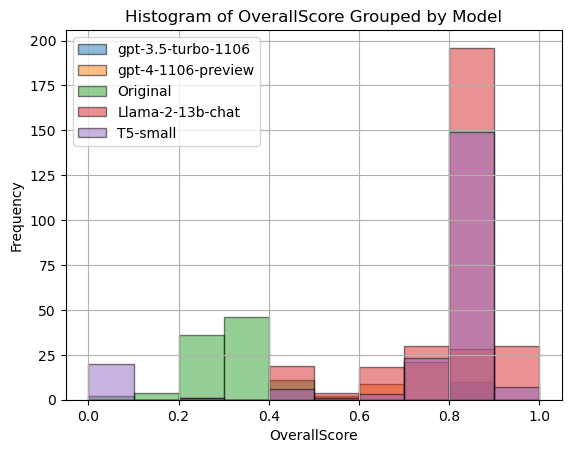

In [ ]:
# Filter out 'Original' and 'Original_Quality' from the experiments
filtered_df = ResultsDF[~ResultsDF['Experiment'].isin(['Original', 'Original_Quality'])]

# Define the bin edges
bin_edges = np.arange(0, 1.1, 0.1)  # Bins from 0 to 1, in steps of 0.1

# Group by 'Experiment' and create a histogram of 'Model'
filtered_df.groupby('Model')['OverallScore'].hist(bins=bin_edges, alpha=0.5, edgecolor='black')

# Set the title and labels
plt.title('Histogram of OverallScore Grouped by Model')
plt.xlabel('OverallScore')
plt.ylabel('Frequency')

# Add a legend
plt.legend(filtered_df['Model'].unique())

# Show the plot
plt.show()

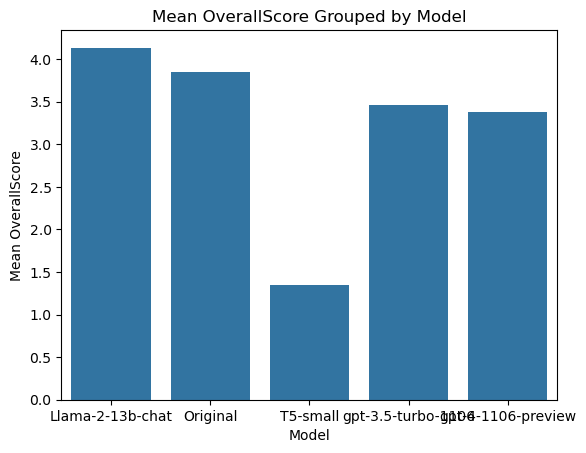

In [ ]:
import seaborn as sns

# Calculate the mean OverallScore for each Model
mean_scores = filtered_df.groupby('Model')['Geval_qua'].mean().reset_index()

# Create a bar plot of the mean OverallScore for each Model
sns.barplot(x='Model', y='Geval_qua', data=mean_scores)

# Set the title and labels
plt.title('Mean OverallScore Grouped by Model')
plt.xlabel('Model')
plt.ylabel('Mean OverallScore')

# Show the plot
plt.show()

In [ ]:
task1_div


f_name                       f_key  \
2                     The Letters                  theletters   
23                    Tromposaund                 tromposaund   
32                        mix2max                     mix2max   
34       Partyband-Non Plus Ultra      partyband-nonplusultra   
37                        Luckies                     luckies   
39                  TAKE IT EASY                   takeiteasy   
63                        Airplay                     airplay   
65               Undercover Lover             undercoverlover   
67                         Intakt                      intakt   
68                      TOP SOUND                   topsound2   
72          The Roaring Zucchinis         theroaringzucchinis   
81                The Violet Band               thevioletband   
83                Connection Five              connectionfive   
85       Pianissimo-Die Eventband     pianissimo-dieeventband   
89                BayernLive-Band             bayernlive-band   
94                     Atlas Cube                   atlascube   
99                 Danny´s Angels                dannysangels   
107                 Bavaria Sound                bavariasound   
108                    HAPPY HOUR                   happyhour   
110                       Kubus M                      kubusm   
121                Lino & Friends                 linofriends   
156  Alleinunterhalter Peter Gent  alleinunterhalterpetergent   
157                   Daisy Ultra                  daisyultra   
159           Partyband Sappralot          partybandsappralot   
168                LOOPS Liveband               loopsliveband   
181                 Stephan Worbs                stephanworbs   
182           RotzFrech Partyband          rotzfrechpartyband   
216                  Band WARNING                 bandwarning   
217           The Swinging Jangos           theswingingjangos   
222                         KOANA                       koana   
232                   WO IST ROSI                   woistrosi   
233                      Zwoastoa                    zwoastoa   
239           MUSIKDUO WIRsindWIR          musikduowirsindwir   
245                     THE ROSES                    theroses   
247               Hühnerbach Musi              huhnerbachmusi   
271                      N8Vision                    n8vision   
274                       SUPPORT                     support   
291              de 5 blousad'n 6                de5blousadn6   
308    Marty & his Rockin' Comets        martyhisrockincomets   
309               Woodsidejumpers             woodsidejumpers   
312                        Quincy                      quincy   
319                       BaXtage                     baxtage   
320                 Got the Beat                   gotthebeat   
345                   Brass Tacks                  brasstacks   
347           Troublemaker's Riot           troublemakersriot   
352               Happy Bavarians              happybavarians   
381          Dinner- und Barmusik          dinner-undbarmusik   
383                     Stingrays                   stingrays   
393                       BigBeat                     bigbeat   
404                    KROHN BAND                  krohnband2   

                                         f_description    f_distance  \
2    Wir machen Ihr Fest zu einem unvergessenem Erl...  1.100000e+02   
23   Tromposaund ist eine bayerische Musikgruppe au...  5.000000e+02   
32   WIR MACHEN LIVEMUSIK. 100% SHOWFREI. Was ist L...  4.000000e+02   
34   Rock - Pop - Schlager - Spass Handgemachte gut...  6.000000e+01   
37   Wir bieten Party-, Stimmungs- und Tanzmusik.\r...  2.000000e+02   
39   âTake it easyâ ! Die Band, die bereits meh...  1.000000e+02   
63   Sie planen eine Veranstaltung und suchen eine ...  1.000000e+03   
65   5 leidenschaftliche Musiker aus München haben ...  2.000000e+02   
67   Feste soll man feiern wie sie fallen. Ein stil...  7.00000

## Testing Grounds

# LLama2

In [ ]:
#TODO: transfer form colab to here

# Testing of model

In [ ]:
row=8

#T5-small
modelT5small.eval()
input_ids = tokenizerT5small.encode("data: "+ task1_in_test['input_text'].iloc[row], return_tensors="pt")
input_ids=input_ids.to(dev)
outputT5small = modelT5small.generate(input_ids, max_length=200)

#chatgpt
outputChatGPT = openai.ChatCompletion.create(model="text-davinci-003", prompt=generate_prompt(row), temperature=0.6, max_tokens=200)

#Flan-T5
modelFlanT5.eval()
input_ids2 = tokenizerFlanT5.encode("Generate a band description: "+ task1_in_test['input_text'].iloc[row], return_tensors="pt")
input_ids2=input_ids2.to(dev)
outputFlanT5 = modelFlanT5.generate(input_ids2, max_length=200)

print("T5-small:\n\n" + tokenizerT5small.decode(outputT5small[0], skip_special_tokens=True))
print("\nChatGPt: " + outputChatGPT.choices[0].text)
print("\nFlan T5:\n\n" + tokenizerFlanT5.decode(outputFlanT5[0], skip_special_tokens=True))
print("\nExpected german:\n\n" + task1_in_test['target_text_de'].iloc[row])
print("\nExpected english:\n\n" + task1_in_test['target_text_en'].iloc[row])

NameError: name 'modelT5small' is not defined

In [ ]:
#"data: "+ task1_in_test['input_text'].iloc[row]
train.generate_prompt(row)

# Task2: Including Gigs

This extends task1 by a including gigs from single bands. This requires a layer of abstraction, because a model might not have to mention all gigs, just the most important ones.

As I wanted to get more up to date data, I used a recent database image (as of 09.12.23), not accessible on the usual server. 

In [ ]:
gigs = pd.read_csv(savepath + 'Datasets/ConnactzGigs.csv')

In [ ]:
# prepare.SetRegion(gigs)
# gigs.to_csv(savepath + 'Datasets/ConnactzGigs.csv', sep=',', index=False)

Adding regions


  0%|          | 0/1224 [00:00<?, ?it/s]

100%|██████████| 1224/1224 [17:18<00:00,  1.18it/s]


In [ ]:
gigs = gigs[['f_name', 'f_key','g_name','s_event_start_date','s_event_end_date','g_eventtypes','s_name','s_adr_locality','s_description','s_adr_country_code','s_genres','region']]
gigs = gigs.rename(columns={'f_name': 'BandName', 'g_name': 'gig status', 's_event_start_date': 'start date', 's_event_end_date': 'end date', 'g_eventtypes': 'event type', 's_name': 'event name', 's_adr_locality': 'city', 's_description': 'event description', 's_adr_country_code': 'country', 's_genres': 'genres'})
gigs.head(1)

BandName             f_key               gig status  \
0  Partyband Hi!light  partybandhilight  Formation 1 to Search 1   

            start date             end date    event type    event name  \
0  2021-06-26 14:00:19  2021-06-26 21:45:19  weddingparty  1 Deggendorf   

         city event description country   genres  region  
0  Deggendorf               NaN      DE  country  Bayern

In [ ]:
aaa =gigs.groupby(['f_key']).count().sort_values('f_key', ascending=False)
descriptiveBands = aaa[aaa['event description'] > 1].index.tolist() # XXX: probably don't use event_description
task1_test = task1_in[task1_in['f_key'].isin(descriptiveBands)]

In [ ]:
#task1_div.reset_index(inplace=True)

In [ ]:
row=1

rel_gigs = gigs[gigs['f_key'] == task1_div.loc[row,'f_key']]
task2_prompt = train.gen_prompt2(task1_div.iloc[row], rel_gigs)

print(task2_prompt)
print("\n\n")



Create a short news article about the following band and some of their recent gigs.
Name: Tromposaund
Location: Holzhausen
Music Genres: blues,brassmusic,folkmusic,jazz,swing
Event Type(s): birthday,fairground,weddingparty
We are a band,brassband
For the recent gigs, summarize them, such that readers get a feel for the bands strengths. Now the recent gigs: 
BandName;f_key;gig status;start date;end date;event type;event name;city;event description;country;genres;region
Tromposaund;tromposaund;Answer 40 to Search 22;2022-05-28 13:00:07;2022-05-28 22:00:07;weddingparty;21 Mamming;Mamming;"Wir sind auf der Suche nach einer Band, die mit uns unseren schönsten Tag im Leben feiert! Dabei bräuchten wir eine Truppe, die nicht nur musikalisch überzeugt (Musikerfamilie), sondern vor allem unsere internationalen Gäste mitnehmen kann (evtl. manche Moderation auf Englisch); Auch ein typisch bayerisches Brautstehlen soll dabei sein, das lustig, aber mit Niveau ablaufen soll. Gerne bauen wir hier auch

In [ ]:
APIquery = openai.ChatCompletion.create(
    model= 'gpt-4-1106-preview',
    messages=[{"role": "user", "content": task2_prompt}],
    temperature=1.0,
    max_tokens=500
  )

print(APIquery.choices[0].message.content)

Holzhausen's Very Own Tromposaund Enchants Audiences Across Bavaria

In the heart of Bavaria, one band has been making waves with its eclectic mix of genres and feel-good performances. Meet Tromposaund, Holzhausen's homegrown ensemble that has perfected the blend of blues, brass music, folk, jazz, and swing. Their performances, as varied as their music, range from intimate wedding parties to lively fairgrounds, ensuring there's never a dull moment when they're on stage.

Tromposaund has recently dazzled at several significant events, showcasing their ability to not only entertain but also to connect with diverse crowds. On May 28, 2022, they were the heart and soul of a wedding party in Mamming. The event was a unique challenge, as the couple sought a band capable of celebrating their love and impressing a Musikerfamilie. Tromposaund rose to the occasion, engaging international guests in multiple languages and even incorporating a traditional Bavarian 'Brautstehlen' with class and humo

In [ ]:
APIquery

<OpenAIObject chat.completion id=chatcmpl-8VhDaFCI0TXvlgJ0xeOgBYED629YP at 0x26de8612630> JSON: {
  "id": "chatcmpl-8VhDaFCI0TXvlgJ0xeOgBYED629YP",
  "object": "chat.completion",
  "created": 1702564990,
  "model": "gpt-4-1106-preview",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "Tromposaund - Die Band, die jede Feier zum Erlebnis macht!\n\nHolzhausen \u2013 Die Band Tromposaund aus dem malerischen Holzhausen mausert sich zu einem echten Geheimtipp auf Festen aller Art. Mit einem Repertoire, das von Blues \u00fcber Brassmusik bis hin zu Jazz und Swing reicht, begeistern sie mittlerweile weit \u00fcber die Grenzen ihrer Heimat Bayern hinaus.\n\nJ\u00fcngst sorgte Tromposaund auf verschiedenen Hochzeitsfeiern f\u00fcr unvergessliche Momente. Am 28. Mai 2022 heizten sie einer feierfreudigen, internationalen Gesellschaft in Mamming kr\u00e4ftig ein. Ihre F\u00e4higkeit, sich musikalisch auf eine Musikerfamilie einzustellen und 

In [ ]:
import io

output = io.StringIO()
rel_gigs.to_csv(output, sep=';', index=False)
csv_string = output.getvalue()
csv_string

'BandName;f_key;gig status;start date;end date;event type;event name;city;event description;country;genres\r\nTromposaund;tromposaund;Answer 40 to Search 22;2022-05-28 13:00:07;2022-05-28 22:00:07;weddingparty;21 Mamming;Mamming;"Wir sind auf der Suche nach einer Band, die mit uns unseren schönsten Tag im Leben feiert! Dabei bräuchten wir eine Truppe, die nicht nur musikalisch überzeugt (Musikerfamilie), sondern vor allem unsere internationalen Gäste mitnehmen kann (evtl. manche Moderation auf Englisch); Auch ein typisch bayerisches Brautstehlen soll dabei sein, das lustig, aber mit Niveau ablaufen soll. Gerne bauen wir hier auch unsere eigene Musikerverwandschaft ein. Da wir Gäste von überall haben und auch selbst viele Jahre unterwegs waren, übernehmen wir gerne während der Pausen mit unserer eigenen Playlist. Wir freuen rießig uns über eure Vorschläge! PS: ein bisschen 90er Jahre wäre richtig toll!";DE;dance\r\nTromposaund;tromposaund;Answer 40 to Search 57;2022-04-09 10:00:23;2022-

# Task3: Regional reports

In [ ]:
gigs.region.unique()

array(['Bayern', 'Wien', nan, 'Hessen', 'Baden-Württemberg',
       'Brandenburg', 'Niedersachsen', 'Sachsen', 'Bezirk Vöcklabruck',
       'Berlin', 'Mecklenburg-Vorpommern', 'Bezirk Ried im Innkreis',
       'Rheinland-Pfalz', 'Salzburg', 'Nordrhein-Westfalen', 'Thüringen',
       'Oberösterreich', 'Hamburg', 'Schleswig-Holstein', 'Steiermark',
       'Saarland', 'Aargau', 'Solothurn', 'St. Gallen', 'Sachsen-Anhalt'],
      dtype=object)

In [ ]:
gigs

BandName                 f_key                 gig status  \
0       Partyband Hi!light      partybandhilight    Formation 1 to Search 1   
1                     naja                  naja  Formation 362 to Search 2   
2          Verena&Johannes        verenajohannes     Answer 306 to Search 3   
3                   Quincy                quincy     Answer 350 to Search 4   
4       Partyband Hi!light      partybandhilight       Answer 1 to Search 5   
...                    ...                   ...                        ...   
1219         Bavaria Sound          bavariasound                Rott am Inn   
1220        LOOPS Liveband         loopsliveband                   Arnstorf   
1221  Lets-Dance-Partyband  lets-dance-partyband                   Arnstorf   
1222  JACK POINT Partyband    jackpointpartyband                   Arnstorf   
1223              Sardonic              sardonic                   Arnstorf   

               start date             end date    event type      event name  \
0     2021-06-26 14:00:19  2021-06-26 21:45:19  weddingparty    1 Deggendorf   
1     2021-07-10 19:00:11  2021-07-10 23:00:11  weddingparty          2 Wien   
2     2021-07-10 10:00:18  2021-07-10 10:30:18       wedding  3 Wiesenfelden   
3     2021-08-14 16:00:03  2021-08-15 00:00:03  weddingparty      4 Augsburg   
4     2021-09-20 17:00:27  2021-09-20 21:45:27  weddingparty     5 Straubing   
...                   ...                  ...           ...             ...   
1219  2024-09-14 12:00:00  2024-09-14 21:45:00  weddingparty        Hochzeit   
1220  2024-10-12 13:00:00  2024-10-12 21:45:00  weddingparty        Hochzeit   
1221  2024-10-12 13:00:00  2024-10-12 21:45:00  weddingparty        Hochzeit   
1222  2024-10-12 13:00:00  2024-10-12 21:45:00  weddingparty        Hochzeit   
1223  2024-10-12 13:00:00  2024-10-12 21:45:00  weddingparty        Hochzeit   

              city                             event description country  \
0       Deggendorf                                           NaN      DE   
1             Wien                                           NaN      AT   
2     Wiesenfelden  Interesse wäre bei dem Duo Verena &Johannes       DE   
3         Augsburg                                           NaN      DE   
4        Straubing                                           NaN      DE   
...            ...                                           ...     ...   
1219   Rott am Inn    Wir suchen Musik für unsere Hochzeitsfeier      DE   
1220      Arnstorf    Wir suchen Musik für unsere Hochzeitsfeier      DE   
1221      Arnstorf    Wir suchen Musik für unsere Hochzeitsfeier      DE   
1222      Arnstorf    Wir suchen Musik für unsere Hochzeitsfeier      DE   
1223      Arnstorf    Wir suchen Musik für unsere Hochzeitsfeier      DE   

           genres  region  
0         country  Bayern  
1         country    Wien  
2             NaN  Bayern  
3         country  Bayern  
4             NaN  Bayern  
...           ...     ...  
1219  loungemusic  Bayern  
1220    breakbeat  Bayern  
1221    breakbeat  Bayern  
1222    breakbeat  Bayern  
1223    breakbeat     NaN  

[1224 rows x 12 columns]

In [ ]:
gigs_sorted = gigs.sort_values('start date', ascending=False)

In [ ]:
from datetime import timedelta

# Get today's date
today = pd.to_datetime('today')

# Calculate the start and end dates of the 6-month window
start_date = today - timedelta(days=6*30)
end_date = today + timedelta(days=6*30)

# Convert 'start date' to datetime
gigs_sorted['start date'] = pd.to_datetime(gigs_sorted['start date'])

# Filter the DataFrame
gigs_filtered = gigs_sorted[(gigs_sorted['start date'] >= start_date) & (gigs_sorted['start date'] <= end_date)]
gigs_filtered

BandName                 f_key  \
1168  Notausstieg Partyband  notausstiegpartyband   
1183  Notausstieg Partyband  notausstiegpartyband   
1073     Partyband Hi!light      partybandhilight   
957   Notausstieg Partyband  notausstiegpartyband   
843   Notausstieg Partyband  notausstiegpartyband   
...                     ...                   ...   
603                  MATRIX                matrix   
604           Bavaria Sound          bavariasound   
605    Lets-Dance-Partyband  lets-dance-partyband   
606              Top Secret             topsecret   
607             Deifes Buam            deifesbuam   

                               gig status          start date  \
1168                                  NaN 2024-06-10 14:00:00   
1183                                  NaN 2024-06-08 14:00:00   
1073  Hochzeit Simon und Daniela Lobmeier 2024-06-08 12:00:00   
957                                   NaN 2024-06-07 14:00:00   
843                               Barbing 2024-06-01 13:00:00   
...                                   ...                 ...   
603                            Osterhofen 2023-06-17 13:00:00   
604                            Osterhofen 2023-06-17 13:00:00   
605                            Osterhofen 2023-06-17 13:00:00   
606                            Osterhofen 2023-06-17 13:00:00   
607                            Osterhofen 2023-06-17 13:00:00   

                 end date    event type                           event name  \
1168  2024-06-10 18:00:00  clubfestival                                  NaN   
1183  2024-06-08 18:00:00    fairground                                  NaN   
1073  2024-06-07 22:00:00       wedding  Hochzeit Simon und Daniela Lobmeier   
957   2024-06-07 18:00:00    fairground                                  NaN   
843   2024-06-01 18:00:00    fairground                              Barbing   
...                   ...           ...                                  ...   
603   2023-06-17 23:00:00  weddingparty                                  NaN   
604   2023-06-17 23:00:00  weddingparty                                  NaN   
605   2023-06-17 23:00:00  weddingparty                                  NaN   
606   2023-06-17 23:00:00  weddingparty                                  NaN   
607   2023-06-17 23:00:00  weddingparty                                  NaN   

             city                                  event description country  \
1168  Prackenbach                                                NaN      DE   
1183    Mengkofen                                                NaN      DE   
1073      Windorf                                                NaN      DE   
957    Neukirchen                                                NaN      DE   
843       Barbing                                                NaN      DE   
...           ...                                                ...     ...   
603    Osterhofen  Wir suchen eine Hochzeitsband die gute Laune u...      DE   
604    Osterhofen  Wir suchen eine Hochzeitsband die gute Laune u...      DE   
605    Osterhofen  Wir suchen eine Hochzeitsband die gute Laune u...      DE   
606    Osterhofen  Wir suchen eine Hochzeitsband die gute Laune u...      DE   
607    Osterhofen  Wir suchen eine Hochzeitsband die gute Laune u...      DE   

         genres  region  
1168        NaN  Bayern  
1183       rock  Bayern  
1073        NaN  Bayern  
957         NaN  Hessen  
843   classical  Bayern  
...         ...     ...  
603       party  Bayern  
604       party  Bayern  
605       party  Bayern  
606       party  Bayern  
607       party  Bayern  

[437 rows x 12 columns]

In [ ]:
gigs_sorted.groupby('region').count()

BandName  f_key  gig status  start date  end date  \
region                                                                       
Aargau                          2      2           1           2         2   
Baden-Württemberg              38     38          35          38        38   
Bayern                        948    948         921         973       973   
Berlin                         16     16          16          17        17   
Bezirk Ried im Innkreis         6      6           6           6         6   
Bezirk Vöcklabruck              1      1           1           1         1   
Brandenburg                    19     19          18          19        19   
Hamburg                         5      5           5           5         5   
Hessen                         31     31          32          34        34   
Mecklenburg-Vorpommern          3      3           3           3         3   
Niedersachsen                  12     12          12          12        12   
Nordrhein-Westfalen            32     32          37          37        37   
Oberösterreich                  1      1           1           1         1   
Rheinland-Pfalz                11     11           9          11        11   
Saarland                        1      1           1           1         1   
Sachsen                         7      7           7           8         8   
Sachsen-Anhalt                  2      2           2           2         2   
Salzburg                        2      2           2           2         2   
Schleswig-Holstein              0      0           1           1         1   
Solothurn                       1      1           1           1         1   
St. Gallen                      1      1           0           1         1   
Steiermark                      1      1           1           1         1   
Thüringen                       5      5           5           5         5   
Wien                            5      5           5           5         5   

                         event type  event name  city  event description  \
region                                                                     
Aargau                            2           1     2                  0   
Baden-Württemberg                38          22    38                 10   
Bayern                          973         673   963                373   
Berlin                           17          16    17                  0   
Bezirk Ried im Innkreis           6           5     6                  5   
Bezirk Vöcklabruck                1           1     1                  0   
Brandenburg                      19           6    19                 10   
Hamburg                           5           3     5                  0   
Hessen                           34          21    34                 14   
Mecklenburg-Vorpommern            3           3     3                  1   
Niedersachsen                    12           7    12                  2   
Nordrhein-Westfalen              37          29    37                  0   
Oberösterreich                    1           1     1                  0   
Rheinland-Pfalz                  11           8    11                  4   
Saarland                          1           1     1                  0   
Sachsen                           8           7     8                  1   
Sachsen-Anhalt                    2           2     2                  0   
Salzburg                          2           1     2                  0   
Schleswig-Holstein                1           0     1                  0   
Solothurn                         1           1     1                  0   
St. Gallen                        1           0     1                  0   
Steiermark                        1           1     1                  0   
Thüringen                         5           5     5                  0   
Wien                              5           5     5                  0   

                   

In [ ]:
slct_region = 0
all_regions = gigs_filtered.region.unique()

print("Selected region: " + all_regions[slct_region])
rel_gigs = gigs_filtered[gigs_filtered['region'] == all_regions[slct_region]]

#Reduce data length
rel_gigs = rel_gigs[['BandName','start date','event type','event name','city','event description', 'genres']]


task3_prompt = train.gen_prompt3(rel_gigs, all_regions[slct_region])
print("input length: " + str(len(task3_prompt)))
print("N° of events: " + str(len(rel_gigs)))

Selected region: Bayern
input length: 57686
N° of events: 368


In [ ]:
print(task3_prompt)

BandName;start date;event type;event name;city;event description;genres
Notausstieg Partyband;2024-06-07 14:00:00;fairground;;Neukirchen;;
AC Angry;2023-09-30 14:00:00;openair;Metalstorm Festival 2023;Kelsterbach;;
The Sound Section;2023-09-08 16:45:00;weddingparty;;Darmstadt;;
4 to the bar;2023-09-02 16:00:00;corporateevent;;Frankfurt am Main;;
Dance the Funky Chicken;2023-08-19 17:45:00;cityfestival;Kirmes Weichersbach;Sinntal;Wir suchen für unsere Kirmes eine Band die in unserem Zelt einheitzt.;
TIMEOUT 4 music;2023-08-19 17:45:00;cityfestival;Kirmes Weichersbach;Sinntal;Wir suchen für unsere Kirmes eine Band die in unserem Zelt einheitzt.;
Use the data about recent events and concerts in Hessen to generate a regional summary. 
  Prioritize recent events and abstract from the data to create a summary of the region's music scene. 
  Mention planned events or popular locations and bands.
  The summary should be under 400 tokens.


In [ ]:
APIquery = openai.ChatCompletion.create(
    model= 'gpt-4-1106-preview',
    messages=[{"role": "user", "content": task3_prompt}],
    temperature=1.0,
    max_tokens=500
  )

print(APIquery.choices[0].message.content)

Pollenfeld, Deutschland: Mix2Max, das energiegeladene Tanzmusikduo aus Pollenfeld, begeistert weiterhin Musikliebhaber mit einer Reihe von Live-Auftritten bei verschiedensten Events. Vom Geburtstag über Firmenveranstaltungen bis hin zu ausgelassenen Sommerpartys - das Duo bringt überall eine mitreißende Stimmung mit.

In den letzten Monaten hat sich Mix2Max als eine der heißesten Adressen für hochqualitative Unterhaltung bei Events aller Art erwiesen. Bei einer exklusiven Geburtstagsfeier in der Stadt gelang es ihnen mühelos, das Publikum mit ihren rhythmischen Dance-Beats zum Tanzen zu bringen. Ihre Fähigkeit, eine feierliche Atmosphäre zu schaffen, wurde beim 'Summer Swing' - einer sommerlichen Freiluftveranstaltung, auf der die Menge förmlich zu ihren Beats schmolz - erneut unter Beweis gestellt.

Auch im Bereich der Firmenevents hat Mix2Max eine starke Präsenz gezeigt. Sie verliehen kürzlich einer renommierten Firmenfeier in Pollenfeld einen modernen und schwungvollen Charakter, de

In [ ]:
print("The music scene in Bayern is vibrant and diverse, with a wide range of genres represented in ongoing and upcoming events. The summer season appears to be particularly busy with local fairgrounds and weddings being the most common event types, showcasing a strong tradition of festive celebrations across the region.\n\nNotausstieg Partyband is one notable group that has marked its presence in multiple venues, including club festivals and fairgrounds in towns like Prackenbach, Mengkofen, and Barbing, indicating their versatility in both rock and classical genres. Their performances are not only limited to fairgrounds but also encompass weddings and other celebrations, suggesting their popularity in the local circuit.\n\nAnother band, Partyband Hi!light, has been sought after for weddings, bringing their celebratory energy to intimate events, just as Lets-Dance-Partyband and LUPOS have been gearing up for wedding parties with their own unique styles. Wedding celebrations seem to have a special place in the hearts of Bayern residents, with many bands like BaXtage, MATRIX, and LOOPS Liveband also contributing to the soundtrack of these special days.\n\nLooking at the genres, there's a mix of party, classical, rockabilly, and lounge music, indicating diverse tastes among the population. The desire for live music, be it for the energy of a party or the romance of a wedding, is clear. On the more traditional side, bands that can perform brass music and folksy tunes remain in demand, especially for events like Volksfest, showcasing the region's cultural heritage.\n\nPopular locations include Passau, highlighting the town's vibrant cultural life, and other towns like Landau an der Isar and Osterhofen also host a variety of musical performances, from weddings to summer parties. The fairground events, like those in Straubing and Grafenau, attract family-friendly crowds and feature a mix of contemporary hits and traditional music, performed by bands like Herb'n Beets or Deifes Buam.\n\nIn upcoming events, the scene doesn't show any signs of slowing down, with bands already booked for summer festivities and wedding seasons, ensuring the spread of joy and entertainment across Bayern. Overall, the music scene in Bayern reflects the region's strong cultural traditions and love for celebrations, with a wide range of musical acts that are ready to cater to every listener's taste.")

The music scene in Bayern is vibrant and diverse, with a wide range of genres represented in ongoing and upcoming events. The summer season appears to be particularly busy with local fairgrounds and weddings being the most common event types, showcasing a strong tradition of festive celebrations across the region.

Notausstieg Partyband is one notable group that has marked its presence in multiple venues, including club festivals and fairgrounds in towns like Prackenbach, Mengkofen, and Barbing, indicating their versatility in both rock and classical genres. Their performances are not only limited to fairgrounds but also encompass weddings and other celebrations, suggesting their popularity in the local circuit.

Another band, Partyband Hi!light, has been sought after for weddings, bringing their celebratory energy to intimate events, just as Lets-Dance-Partyband and LUPOS have been gearing up for wedding parties with their own unique styles. Wedding celebrations seem to have a special

#### Just testing with new and updated data

In [ ]:
task1_new = pd.read_csv(savepath + '/Datasets/ConnactzTask1New.csv', sep=",", index_col=False)

In [ ]:
df_diff = task1_quality.merge(task1_new, on='f_key', how='left',suffixes=('_old', '_new'), indicator=True)[['f_key', 'f_description_old', 'f_description_new', '_merge']]
df_diff = df_diff[df_diff['f_description_old'] != df_diff['f_description_new']]

# Testing metrics


## Bleu

In [ ]:
#Simple bleu test

for i in range(len(output)):
  print(sentence_bleu(output.output[i], str(output.target_text_en[i])))

## Self Bleu test

In [ ]:
#taken from here: https://blog.paperspace.com/automated-metrics-for-evaluating-generated-text/

import numpy as np
import copy
from nltk.translate.bleu_score import sentence_bleu

def get_bleu_score(sentence, remaining_sentences):
    lst = []
    for i in remaining_sentences:
        bleu = sentence_bleu(sentence, i)
        lst.append(bleu)
    return lst


def calculate_selfBleu(sentences):
    '''
    sentences - list of sentences generated by NLG system
    '''
    bleu_scores = []

    for i in sentences:
        sentences_copy = copy.deepcopy(sentences)
        remaining_sentences = sentences_copy.remove(i)
        #print("\nCalculating for: "+ str(i))
        bleu = get_bleu_score(i,sentences_copy)
        bleu_scores.append(bleu)

    return (bleu_scores) #np.mean


In [ ]:
calculate_selfBleu(list(output.output))

c:\Users\alex\.conda\envs\xai39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\alex\.conda\envs\xai39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\alex\.conda\envs\xai39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use Smoothi

[[8.667696882672467e-232,
  9.600277660870101e-232,
  9.728190034465344e-232,
  9.297575142709791e-232,
  9.057706921859633e-232,
  9.686107743458562e-232,
  9.045589002047864e-232,
  9.697869887461275e-232,
  8.98982024702321e-232,
  8.860766779686792e-232,
  9.006517714622284e-232,
  9.231787263313528e-232,
  8.876833512530215e-232,
  9.412591710486053e-232,
  9.588560343689711e-232,
  8.621257749007841e-232,
  9.109159947227211e-232,
  9.713416734391049e-232,
  9.477099905719937e-232,
  9.007674992862096e-232,
  9.004415475414015e-232,
  8.101954432160763e-232,
  8.874878262738776e-232,
  9.48688413430962e-232,
  8.657863578199087e-232,
  8.852538924852978e-232,
  9.104258594929673e-232,
  9.470048426210709e-232,
  9.324655390114502e-232,
  8.669612184277444e-232,
  8.963913508982269e-232,
  9.870453685436245e-232,
  8.708784398657149e-232,
  9.177126558672114e-232,
  9.70119088671068e-232,
  8.694097917400415e-232,
  9.013853677934755e-232,
  9.336117803135294e-232,
  9.06088035811